# Lightcurve Plots

In [77]:
"""
IMPORTS
"""
import numpy as np
import re
import matplotlib.pyplot as plt
import lmfit
from lmfit import Parameters, fit_report, minimize
from lmfit.models import ExponentialModel, GaussianModel, PowerLawModel, ExpressionModel, LinearModel
import random
from scipy.stats import spearmanr
from scipy.odr import RealData
from scipy import odr
import pprint
import sys

In [78]:
"""
CONSTANTS
"""
H0 = 70
WM = 0.27
WV = 0.73

WR = 0.        # Omega(radiation)
WK = 0.        # Omega curvaturve = 1-Omega(total)
c = 299792.458 # velocity of light in km/sec
Tyr = 977.8    # coefficent for converting 1/H into Gyr
DTT = 0.5      # time from z to now in units of 1/H0
DTT_Gyr = 0.0  # value of DTT in Gyr
age = 0.5      # age of Universe in units of 1/H0
age_Gyr = 0.0  # value of age in Gyr
zage = 0.1     # age of Universe at redshift z in units of 1/H0
zage_Gyr = 0.0 # value of zage in Gyr
DCMR = 0.0     # comoving radial distance in units of c/H0
DCMR_Mpc = 0.0 
DCMR_Gyr = 0.0
DA = 0.0       # angular size distance
DA_Mpc = 0.0
DA_Gyr = 0.0
kpc_DA = 0.0
DL = 0.0       # luminosity distance
DL_Mpc = 0.0
DL_Gyr = 0.0   # DL in units of billions of light years
V_Gpc = 0.0
a = 1.0        # 1/(1+z), the scale factor of the Universe
az = 0.5       # 1/(1+z(object))
n = 1000       # no of points to integrate over

beta = 1/3
T_s = 10       # chosen early time

In [79]:
"""
FUNCTIONS
"""
# luminosity function
def L(flux, d_l, z, beta):
    
    # empty array for the luminosity
    lum = []
    
    # define luminosity function
    for i in flux:
        
        F = i*1e-29 # convert units to erg s^-1 cm^-2 Hz^-1
        L_f = (F*4*np.pi*(d_l**2)*(1+z)**(-beta))/(1+z)
        lum.append(L_f)
        
    return lum



# luminosity error function
def L_err(flux_err, d_l, z, beta):

    # empty array for the error
    lum_err = []
    
    # define error function
    for j in flux_err:
        
        # convert units to erg s^-1 cm^-2 Hz^-1
        F_err = j*1e-29

        err = (F_err*4*np.pi*(d_l**2)*(1+z)**(-beta))/(1+z)
        lum_err.append(err)
        
    return lum_err



# rest time frame function
def T_rest(time, z):
    
    # empty array for the new times
    time_rest = []
    
    # convert to rest frame
    for k in time:
        
        rest = k/(1+z)
        time_rest.append(rest)
        
    return time_rest

    
    
# weight of the error in luminosity
def weight(lum_err):
    
    # empty array for the weights
    weight_lum = []
    
    # define weight function
    for m in lum_err:
        
        weight = 1/m
        weight_lum.append(weight)
    
    return weight_lum



# simple power law of form L = Nx^-a
def power_law1(time, N, a): 
    
    # empty array for the data
    prediction = []
    
    for n in time:
    
        y = N*np.power(n,a)
        prediction.append(y)
    
    return prediction

In [80]:
"""
RADIO DATA
"""

# open afterglow data
with open("Radio_Data.txt") as file_1:
    # splits data into lines
    data_1 = file_1.readlines()

names = []
GRB_sample = []         # names of all GRBs in sample

# generate list of GRBs in sample
for i in data_1:
    
    # splits data into rows
    row = i.split()
    names.append(row[0])

for GRB in names[1:]:
    if GRB not in GRB_sample:
        GRB_sample.append(GRB)

print(f'The number of GRBs in the sample is {len(GRB_sample)}.')

The number of GRBs in the sample is 305.


In [81]:
"""
REDSHIFTS
"""

# open redshift data

GRB_redshift =[]    # GRBs and their redshift
redshift_all = []   # all redshifts
GRB_all = []        # GRBs with redshifts

with open('Redshift_complete.txt') as file_2:

    for line in file_2.readlines():
        row = line.split()

        try:
            if float(row[1]) <10:
                
                z = float(row[1])
                GRB_redshift.append([row[0], z])     
                redshift_all.append(z)
                GRB_all.append(row[0])

        except:
            pass          
        
print(f'The number of GRBs with redshift is {len(GRB_all)} (for the extended sample).')

The number of GRBs with redshift is 250 (for the extended sample).


In [82]:
"""
LUMINOSITY DISTANCE
"""

# empty list for data
d_l_all = []        # all luminosity distances

for z in redshift_all:

    h = H0/100
    WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
    WK = 1-WM-WR-WV
    az = 1.0/(1+1.0*z)
    age = 0.
    n=1000         # number of points in integrals
    for i in range(n):
        a = az*(i+0.5)/n
        adot = np.sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
        age = age + 1./adot

    zage = az*age/n
    zage_Gyr = (Tyr/H0)*zage
    DTT = 0.0
    DCMR = 0.0

    # do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
    for i in range(n):
        a = az+(1-az)*(i+0.5)/n
        adot = np.sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
        DTT = DTT + 1./adot
        DCMR = DCMR + 1./(a*adot)

    DTT = (1.-az)*DTT/n
    DCMR = (1.-az)*DCMR/n
    age = DTT+zage
    age_Gyr = age*(Tyr/H0)
    DTT_Gyr = (Tyr/H0)*DTT
    DCMR_Gyr = (Tyr/H0)*DCMR
    DCMR_Mpc = (c/H0)*DCMR

    # tangential comoving distance

    ratio = 1.00
    x = np.sqrt(abs(WK))*DCMR
    if x > 0.1:
        if WK > 0:
            ratio =  0.5*(np.exp(x)-exp(-x))/x 
        else:
            ratio = np.sin(x)/x
    else:
        y = x*x
        if WK < 0:
            y = -y
            ratio = 1. + y/6. + y*y/120.
            DCMT = ratio*DCMR
            DA = az*DCMT
            DA_Mpc = (c/H0)*DA
            kpc_DA = DA_Mpc/206.264806
            DA_Gyr = (Tyr/H0)*DA
            DL = DA/(az*az)
            DL_Mpc = (c/H0)*DL
            DL_Gyr = (Tyr/H0)*DL

    # luminosuity distance in cm
    d_l = DL_Mpc * 3.08568e24
    
    d_l_all.append(d_l)
    
# empty list to store data
GRB_z_d_l = []      # GRB name with corresponding redshift and lum distance

for name, z, d_l in zip(GRB_all, redshift_all, d_l_all):
    GRB_z_d_l.append([name, z, d_l])

In [83]:
"""
DATA FOR SPECIFIC FREQUENCY
"""

# empty array to hold data for 8.46GHz

GRB_name_8 = []
time_array = []
flux_array = []
flux_err_array = []
data_freq_8 = []
            
# loop to get data for given frequency
for i in data_1:
    
    # splits data into rows
    row = i.split()
    
    name = row[0]
    freq = row[6]
    
    # chosen frequency = 8.46GHz
    if freq == '8.46':
        time_raw = float(row[5])
        flux_raw = float(row[7])
        flux_err_raw = float(row[8])
        
        # only store data points with recorded data
        if flux_raw >= 0:
            
            time_array.append(time_raw)
            flux_array.append(flux_raw)
            flux_err_array.append(flux_err_raw)
            data_freq_8.append([name, time_raw, flux_raw, flux_err_raw])    # all datapoints taken at 8.46GHz
            if name not in GRB_name_8:
                GRB_name_8.append(name)


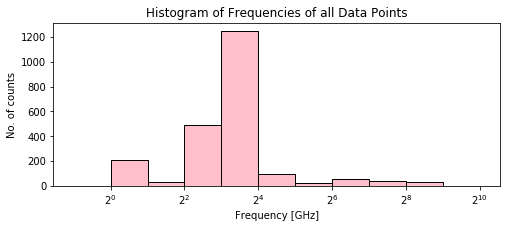

In [85]:
"""
HISTOGRAM OF DATA POINTS
"""

# empty lists for data
all_frequencies = []                # all frequencies with data taken
freq_plot = []           # list to put into bins to plot on histogram

# split data by GRB
for i in data_1[1:]:
    
    # splits data into rows
    row = i.split()
    flux = float(row[7])
    
    # removes no recorded data entries
    if flux <= 0:
        continue
    
    # adds remaining data points to array
    else:
        freq_plot.append(float(row[6]))
        
        freq_test = float(row[6])
        
        if freq_test not in all_frequencies:
            all_frequencies.append(freq_test)                   
        
# plot histogram of frequencies of all data points
plt.figure(figsize=(8,3))
plt.title('Histogram of Frequencies of all Data Points')
plt.hist(freq_plot, color='pink', edgecolor='black', bins = [0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])
plt.xlabel("Frequency [GHz]")
plt.semilogx(basex=2)
plt.ylabel("No. of counts")
plt.show()

all_frequencies.sort()
#print('List of all the frequencies data was taken in:')
#print(all_frequencies)

In [87]:
"""
GRBS TO EXCLUDE
"""

# empty lists for GRBs to exclude and ones to keep
GRB_exclude = []
GRB_keep = []

# GRBs with confirmed SNe connections
GRB_SNe_c = ['011121', '021211', '030329', '031203', '050525A', '060218', '101219B']
GRB_exclude.extend(GRB_SNe_c)

# GRBs with suspected SNe connections
GRB_SNe_s = ['090228', '980326', '980425', '990712', '991208', '970828', '000911', '020305', '020405', '020819', '020903', '030329', '030723', '040924', '041006', '050416A', '050509B', '050824', '080319B', '090618', '091127', '100418A']
GRB_exclude.extend(GRB_SNe_s)

# Short GRBs
SHB = ['001025B', '001204', '010119', '020531', '021201', '050202', '051221A', '050509B', '050709', '050724', '050813', '050906', '050911', '051021A', '051103', '051105A', '051114', '051221A', '051227', '060313', '060502B', '060505', '060801', '061210', '070429B', '070714B', '070724A', '070729', '070923', '071112B', '080503', '080702A', '081024B', '090328', '090417B']
GRB_exclude.extend(SHB)

# X-Ray Flashes
XRF = ['010213', '011030', '011130', '020427', '020903', '030429', '030528', '030723', '040701', '040812', '040912', '040916', '050215B', '050416A', '050509C', '050522', '051109B', '060218', '060428B']
GRB_exclude.extend(XRF)

GRB_exclude.sort()

# new list excluding these GRBs
for burst in GRB_name_8:
    if burst not in GRB_exclude:
        GRB_keep.append(burst)
        
GRB_keep.sort()


#print(f'The GRBs to be exluded are: {GRB_exclude}')
print(f'The number of GRBs to exclude is {len(GRB_exclude)}.')

#print(f'The GRBs which can be plot are: {GRB_keep}')
print(f'The number of GRBs that can be plot is {len(GRB_keep)} (with redshift, but not taking length of flux into account).')


The number of GRBs to exclude is 83.
The number of GRBs that can be plot is 116 (with redshift, but not taking length of flux into account).


In [96]:
"""
NUMBER OF GRBS WITH THREE OR MORE POINTS IN 8.46GHz
"""

GRBs_3_8 = []

# first GRB in the radio data with a redshift
first_GRB =  GRB_sample[0]

# loop through rows in data for 8.46GHz
for row in data_freq_8:
    
    # get name of GRB for that row
    GRB = row[0]
    
    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):

        # Adds data to array for that GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        
        time.append(t)
        flux.append(f)
        flux_err.append(f_err)
                
    # when it stops matching, store data for that GRB and reset
    else:
        
        if len(flux) > 3:
            
            GRBs_3_8.append(GRB)
            
        # reset arrays
        time = []
        flux = []
        flux_err = []
        
        # store first data point for next GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        time.append(t)
        flux.append(f)
        flux_err.append(f_err)
        
        # move to next GRB
        first_GRB = GRB 

keep_these = []        
        
for burst in GRBs_3_8:
    if burst not in GRB_exclude:
        keep_these.append(burst)
        
print(f'The number of GRBs with three or more points in 8.46GHz is {len(keep_these)}.')

The number of GRBs with three or more points in 8.46GHz is 50.


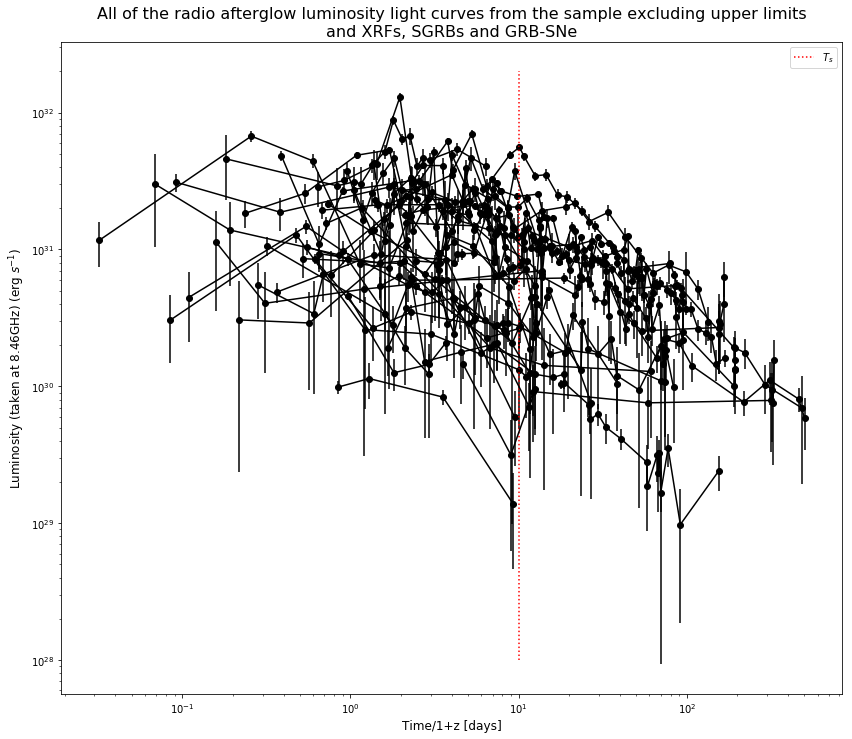

The number of GRB with redshift and three or more points at 8.46GHz is 37.
The GRBs to keep are: ['970508', '971214', '980703', '981226', '990123', '990506', '991216', '000210', '000301C', '000418', '000926', '010222', '010921', '011211', '020813', '021004', '030115', '030226', '041219', '050603', '050820A', '050904', '051022', '060116', '061121', '070125', '070612A', '071003', '071010B', '090313', '090323', '090423', '090424', '090715B', '090902B', '091020', '100414A']


In [98]:
"""
PLOT OF ALL DATA FOR 8.46GHz
"""

# first GRB in the radio data with a redshift
first_GRB =  GRB_sample[0]

# empty arrays to store data in loop
time = []
flux = []
flux_err = []

dot_lum = []
dot_lum_err = []
dot_time = []

star_lum = []
star_lum_err = []
star_time = []

# end product empty arrays
data_all = []
data_dot = []
data_star = []

# loop through rows in data for 8.46GHz
for row in data_freq_8:
    
    # get name of GRB for that row
    GRB = row[0]
    
    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):

        # Adds data to array for that GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        
        time.append(t)
        flux.append(f)
        flux_err.append(f_err)
                
    # when it stops matching, store data for that GRB and reset
    else:
        
        # identify redshift and luminosity distance for that GRB
        for j in GRB_z_d_l:

            x = j[0]
            
            if re.match(first_GRB, x):
                
                z = j[1]
                d_l = j[2]
        
                lum = L(flux, d_l, z, beta)
                lum_err = L_err(flux_err, d_l, z, beta)
                time_rest = T_rest(time, z)

                # all data (including upper limits)
                data_all.append([first_GRB, lum, lum_err, time_rest])

                # join the two lists to compare them and check if point is an upper limit
                data_point = list(zip(lum, lum_err, time_rest))

                # compare each lum to it's error
                for data in data_point:
                    lum_i = data[0]
                    lum_err_i = data[1]
                    time_i = data[2]

                    # if lum>err, plot as a dot
                    if lum_i > lum_err_i:
                        dot_lum.append(lum_i)
                        dot_lum_err.append(lum_err_i)
                        dot_time.append(time_i)

                    # if lum<err, plot as an upside down triangle
                    if lum_i < lum_err_i:
                        star_lum.append(lum_i)
                        star_lum_err.append(lum_err_i)
                        star_time.append(time_i)
                              
                # store data depending on if they're an upper limit or not
                data_dot.append([first_GRB, dot_lum, dot_lum_err, dot_time])
                data_star.append([first_GRB, star_lum, star_lum_err, star_time])
        
        # reset arrays
        time = []
        flux = []
        flux_err = []
        z = []
        d_l = []
        
        dot_lum = []
        dot_lum_err = []
        dot_time = []
        
        star_lum = []
        star_lum_err = []
        star_time = []
        
        # store first data point for next GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        time.append(t)
        flux.append(f)
        flux_err.append(f_err)
        
        # move to next GRB
        first_GRB = GRB        
    
"""               
# plot scatter graph of all data points coloured by GRB
plt.figure(figsize = (14.5, 12))
plt.title('All of the radio afterglow luminosity light curves from the sample')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")        
for gammarayburst in data_all:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]
    
    plt.scatter(time, lum, label = f'{name}')
    plt.errorbar(time, lum, lum_err, fmt = ' ')
    
plt.vlines(x=T_s, ymin=1e26, ymax=1e33, colors='grey', linestyles=':', label='T_s')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()        
""" 

"""
# plot scatter graph of all data points split by upper limit/not
plt.figure(figsize = (14.5, 12))
plt.title('All of the radio afterglow luminosity light curves from the sample showing upper limits')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")

for gammarayburst in data_dot:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]
    
    plt.scatter(time, lum, c = "black")
    plt.errorbar(time, lum, lum_err, fmt = ' ', c = "black")
    
for gammarayburst in data_star:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    time = gammarayburst[3]
    
    plt.scatter(time, lum, c = "red", marker=r'$\star$')
    
plt.vlines(x=T_s, ymin=1e26, ymax=1e33, colors='grey', linestyles=':', label='T_s')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()     
"""

"""
# plot scatter graph of all data points in same colour excluding upper limits
plt.figure(figsize = (14.5, 12))
plt.title('All of the radio afterglow luminosity light curves from the sample excluding upper limits')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")        
for gammarayburst in data_dot:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]
    
    plt.scatter(time, lum, c = "black")
    plt.errorbar(time, lum, lum_err, fmt = ' ', c = "black")
    
plt.vlines(x=T_s, ymin=1e26, ymax=1e33, colors='grey', linestyles=':', label='T_s')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()       
"""

keepers = []

# plot scatter graph of all data points in same colour excluding upper limits and GRB with SNe connection
fig = plt.figure(figsize = (14,12))
plt.title('All of the radio afterglow luminosity light curves from the sample excluding upper limits\nand XRFs, SGRBs and GRB-SNe', fontsize=16)
plt.xscale("log")
plt.xlabel("Time/1+z [days]", fontsize=12)
plt.yscale("log")
plt.ylabel("Luminosity (taken at 8.46GHz) (erg $s^{-1}$)", fontsize=12)        
for gammarayburst in data_dot:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]
    
    if name in GRB_keep:
    
        if len(lum) > 3:

            plt.scatter(time, lum, c = "black")
            plt.errorbar(time, lum, lum_err, fmt = ' ', c = "black")
            plt.plot(time, lum, c = "black")
            
            keepers.append(name)
    
plt.vlines(x=T_s, ymin=1e28, ymax=2e32, colors='red', linestyles=':', label='$T_{s}$')
plt.legend(bbox_to_anchor = (1 , 1))
plt.savefig('plot_of_all.png', bbox_inches='tight', dpi=300)
plt.show()

print(f'The number of GRB with redshift and three or more points at 8.46GHz is {len(keepers)}.')
print(f'The GRBs to keep are: {keepers}')

970228
[76.0, 20.0, 2.0, 4.0, 55.0, 13.0, 25.0]
[50.0, 40.0, 36.0, 12.0, 30.0, 26.0, 19.0]
[6.9, 11.0, 22.9, 29.7, 32.9, 60.8, 99.6]
[8.362956795170749e+29, 2.200778103992302e+29, 2.2007781039923016e+28, 4.401556207984603e+28, 6.052139785978831e+29, 1.4305057675949965e+29, 2.750972629990377e+29]
[5.501945259980754e+29, 4.401556207984604e+29, 3.961400587186144e+29, 1.3204668623953811e+29, 3.301167155988453e+29, 2.861011535189993e+29, 2.0907391987926873e+29]
[4.058823529411765, 6.470588235294118, 13.470588235294118, 17.470588235294116, 19.352941176470587, 35.76470588235294, 58.588235294117645]
0.7
1.3329099584160232e+28


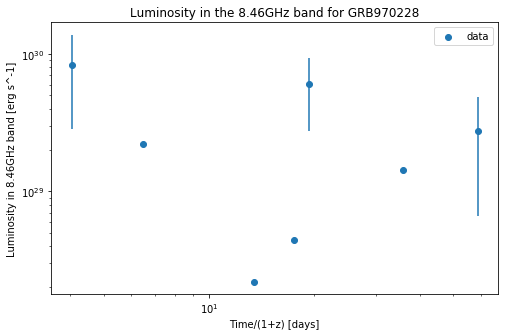

970508
[430.0, 610.0, 520.0, 602.0, 604.0, 610.0, 1270.0, 930.0, 570.0, 880.0, 1260.0, 960.0, 550.0, 470.0, 480.0, 500.0, 538.0, 835.0, 1200.0, 810.0, 290.0, 720.0, 940.0, 960.0, 760.0, 670.0, 690.0, 530.0, 600.0, 460.0, 560.0, 630.0, 800.0, 645.0, 680.0, 565.0, 805.0, 710.0, 725.0, 680.0, 630.0, 575.0, 515.0, 440.0, 455.0, 380.0, 445.0, 430.0, 640.0, 565.0, 400.0, 300.0, 470.0, 315.0, 355.0, 370.0, 350.0, 370.0, 330.0, 310.0, 280.0, 240.0, 300.0, 240.0, 240.0, 170.0, 160.0, 150.0, 95.0, 105.0, 8.0]
[25.0, 33.0, 18.0, 24.0, 56.0, 51.0, 120.0, 120.0, 42.0, 33.0, 100.0, 100.0, 44.0, 43.0, 45.0, 49.0, 100.0, 100.0, 47.0, 48.0, 46.0, 62.0, 27.0, 40.0, 45.0, 43.0, 28.0, 38.0, 39.0, 66.0, 40.0, 63.0, 32.0, 38.0, 46.0, 36.0, 43.0, 49.0, 40.0, 46.0, 37.0, 61.0, 41.0, 51.0, 85.0, 42.0, 50.0, 39.0, 40.0, 49.0, 60.0, 35.0, 44.0, 70.0, 47.0, 70.0, 47.0, 39.0, 45.0, 56.0, 37.0, 34.0, 37.0, 24.0, 30.0, 30.0, 30.0, 36.0, 24.0, 15.0, 19.0]
[5.06, 6.23, 7.59, 7.89, 8.4, 9.95, 12.1, 12.23, 13.2, 13.59, 

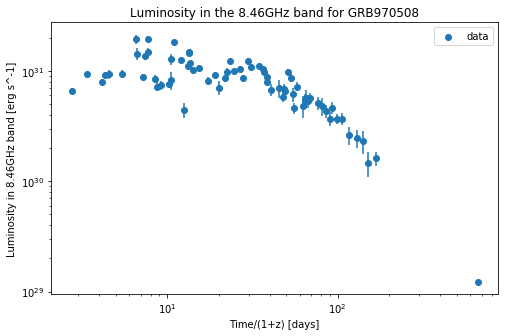

970828
[37.0, 147.0, 110.0, 65.0, 22.0, 20.0, 7.0, 20.0, 7.0, 19.0, 40.0, 32.0, 27.0]
[30.0, 33.0, 50.0, 33.0, 30.0, 14.0, 18.0, 21.0, 21.0, 50.0, 36.0, 13.0, 14.0]
[2.45, 3.53, 5.62, 18.45, 21.37, 41.39, 49.32, 49.99, 54.5, 55.26, 55.5, 82.25, 90.25]
[7.380573917965826e+29, 2.932282070110747e+30, 2.1942246783141642e+30, 1.296587309912915e+30, 4.3884493566283284e+29, 3.9894994151166626e+29, 1.396324795290832e+29, 3.9894994151166626e+29, 1.396324795290832e+29, 3.790024444360829e+29, 7.978998830233325e+29, 6.38319906418666e+29, 5.3858242104074944e+29]
[5.984249122674993e+29, 6.582674034942491e+29, 9.973748537791654e+29, 6.582674034942491e+29, 5.984249122674993e+29, 2.792649590581664e+29, 3.590549473604995e+29, 4.1889743858724955e+29, 4.1889743858724955e+29, 9.973748537791654e+29, 7.18109894720999e+29, 2.5931746198258304e+29, 2.792649590581664e+29]
[1.2500000000000002, 1.8010204081632653, 2.86734693877551, 9.41326530612245, 10.903061224489797, 21.117346938775512, 25.16326530612245, 25.505

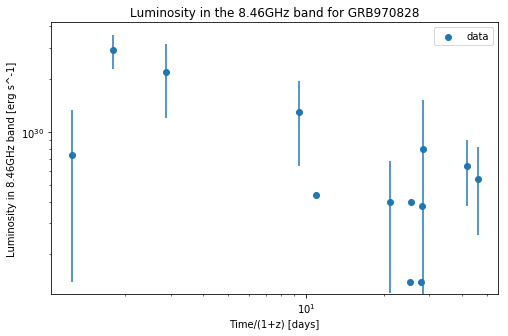

971214
[73.0, 26.0, 13.0, 33.0, 5.0, 45.0]
[50.0, 18.0, 17.0, 31.0, 55.0, 35.0]
[0.7, 1.37, 3.36, 5.3, 13.3, 60.6]
[1.1342614504959427e+31, 4.0398353031362344e+30, 2.0199176515681172e+30, 5.127483269365219e+30, 7.768914044492758e+29, 6.992022640043482e+30]
[7.768914044492757e+30, 2.796809056017393e+30, 2.6414307751275374e+30, 4.816726707585509e+30, 8.545805448942034e+30, 5.43823983114493e+30]
[0.15844273426889993, 0.31009506564056133, 0.7605251244907197, 1.1996378451788139, 3.010411951109099, 13.71661385242191]
3.418
9.467617383491483e+28


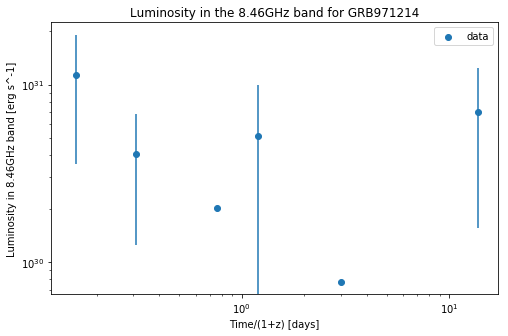

980329
[166.0, 256.0, 84.0, 109.0, 135.0, 194.0, 58.0, 179.0, 274.0, 227.0, 205.0, 291.0, 245.0, 465.0, 299.0, 219.0, 321.0, 210.0, 167.0, 248.0, 200.0, 167.0, 169.0, 108.0, 151.0, 157.0, 40.0, 13.0]
[50.0, 16.0, 23.0, 47.0, 21.0, 26.0, 37.0, 41.0, 34.0, 22.0, 17.0, 17.0, 37.0, 90.0, 51.0, 32.0, 43.0, 45.0, 38.0, 25.0, 23.0, 46.0, 33.0, 36.0, 35.0, 47.0, 23.0, 11.0]
[1.07, 2.97, 3.99, 4.98, 5.95, 6.96, 8.73, 9.9, 12.93, 19.88, 20.84, 23.75, 24.94, 28.86, 31.94, 36.76, 39.85, 40.68, 53.81, 56.8, 63.82, 69.68, 75.82, 84.61, 113.54, 121.27, 492.44, 579.27]
980519
[49.0, 64.0, 103.0, 127.0, 40.0, 142.0, 230.0, 1.0, 82.0, 66.0, 78.0, 1.0, 42.0]
[28.0, 27.0, 19.0, 20.0, 25.0, 29.0, 31.0, 32.0, 40.0, 23.0, 27.0, 30.0, 32.0]
[0.3, 1.08, 2.84, 5.45, 12.03, 14.05, 16.63, 18.92, 23.43, 30.07, 48.75, 61.72, 62.74]
[1.2716921483832013e+29, 1.7803690077364818e+29]
[6.104122312239365e+29, 7.121476030945927e+29]
[1.8121989603700703, 4.244360722972007]
1.0969
2.3306990933913433e+28


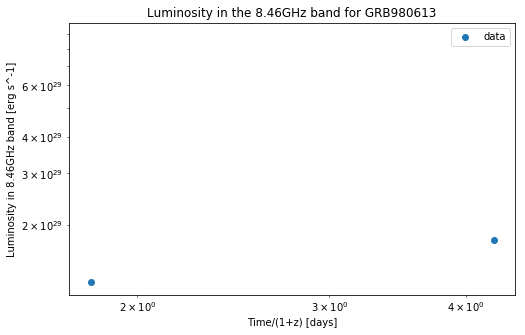

980703
[890.0, 965.0, 1050.0, 840.0, 882.0, 720.0, 564.0, 709.0, 504.0, 584.0, 502.0, 593.0, 510.0, 465.0, 480.0, 412.0, 386.0, 277.0, 214.0, 205.0, 281.0, 260.0, 131.0, 167.0, 143.0, 80.0, 110.0, 103.0, 70.0, 38.0, 55.0, 40.0, 29.0]
[21.0, 55.0, 35.0, 72.0, 51.0, 56.0, 75.0, 52.0, 20.0, 57.0, 67.0, 42.0, 43.0, 34.0, 40.0, 22.0, 49.0, 35.0, 35.0, 40.0, 37.0, 26.0, 33.0, 26.0, 33.0, 18.0, 20.0, 16.0, 17.0, 8.0, 19.0, 8.0, 12.0]
[4.17, 5.31, 12.23, 14.38, 17.15, 18.16, 21.26, 22.28, 23.15, 24.24, 25.23, 28.27, 30.18, 31.26, 33.23, 39.11, 49.1, 52.04, 56.04, 63.17, 65.31, 73.39, 85.04, 89.14, 95.14, 129.9, 143.79, 176.86, 210.71, 428.64, 611.52, 909.39, 986.8]
[1.7964991459430975e+31, 1.947889523410212e+31, 2.119465284539609e+31, 1.695572227631687e+31, 1.7803508390132716e+31, 1.4533476236843035e+31, 1.1384556385527042e+31, 1.431143701655793e+31, 1.0173433365790126e+31, 1.1788264058772683e+31, 1.013306259846556e+31, 1.1969932511733222e+31, 1.0294545667763815e+31, 9.386203402961126e+30, 9.6

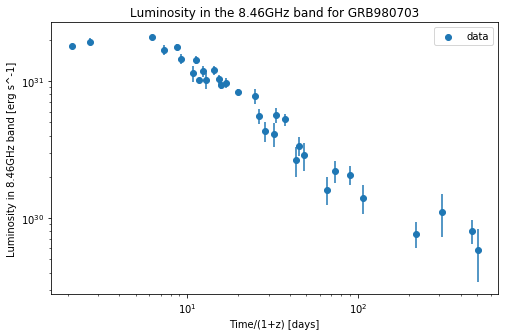

981226
[73.0, 143.0, 169.0, 67.0, 80.0, 27.0, 37.0, 9.0, 15.0]
[27.0, 45.0, 28.0, 29.0, 30.0, 14.0, 20.0, 25.0, 20.0]
[3.51, 4.54, 8.54, 12.57, 15.65, 24.48, 26.44, 92.33, 152.03]
[1.8967784418858356e+30, 3.7156070847900615e+30, 4.391172009297345e+30, 1.740878843922616e+30, 2.0786613061762586e+30, 7.015481908344871e+29, 9.613808541065193e+29, 2.3384939694482902e+29, 3.8974899490804845e+29]
[7.015481908344871e+29, 1.169246984724145e+30, 7.275314571616902e+29, 7.535147234888936e+29, 7.794979898160969e+29, 3.637657285808451e+29, 5.1966532654406464e+29, 6.495816581800806e+29, 5.1966532654406464e+29]
[1.663507109004739, 2.1516587677725116, 4.047393364928909, 5.9573459715639805, 7.417061611374407, 11.601895734597155, 12.53080568720379, 43.75829383886255, 72.0521327014218]
1.11
2.3655397157264717e+28


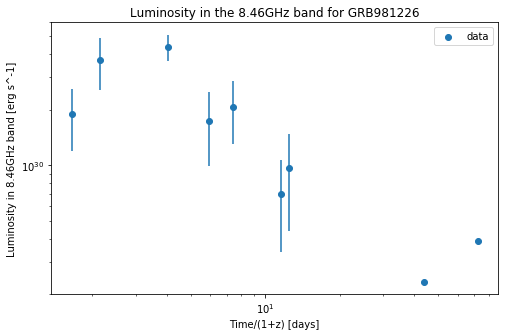

990123
[62.0, 260.0, 53.0, 18.0, 22.0, 49.0, 4.0, 14.0, 10.0, 16.0, 17.0, 27.0, 24.0, 14.0, 8.0, 6.0, 9.0]
[32.0, 32.0, 39.0, 25.0, 25.0, 19.0, 26.0, 16.0, 23.0, 16.0, 18.0, 17.0, 12.0, 14.0, 13.0, 10.0, 10.0]
[0.22, 1.24, 3.17, 4.21, 4.91, 7.86, 10.11, 12.02, 14.95, 18.96, 22.03, 26.02, 28.93, 34.96, 39.86, 102.88, 104.0]
[3.0394931625883207e+30, 1.2746261649563927e+31, 2.5982764131803394e+30, 8.824334988159642e+29, 1.0785298318861784e+30, 2.402180080110124e+30, 1.9609633307021426e+29, 6.8633716574575e+29, 4.902408326755357e+29, 7.84385332280857e+29, 8.334094155484105e+29, 1.3236502482239464e+30, 1.1765779984212854e+30, 6.8633716574575e+29, 3.921926661404285e+29, 2.9414449960532136e+29, 4.412167494079821e+29]
[1.568770664561714e+30, 1.568770664561714e+30, 1.911939247434589e+30, 1.225602081688839e+30, 1.225602081688839e+30, 9.314575820835176e+29, 1.2746261649563927e+30, 7.84385332280857e+29, 1.1275539151537318e+30, 7.84385332280857e+29, 8.824334988159642e+29, 8.334094155484105e+29, 5.8

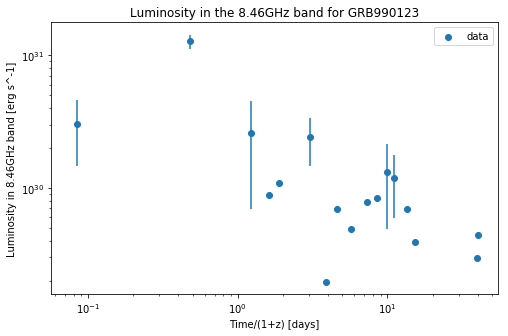

990506
[447.0, 581.0, 55.0, 41.0, 8.0, 25.0, 37.0]
[50.0, 45.0, 41.0, 36.0, 31.0, 30.0, 25.0]
[1.66, 2.7, 15.66, 32.56, 37.52, 108.35, 141.23]
[1.5503229512069615e+31, 2.0150730081683324e+31, 1.907556203945926e+30, 1.4219964429415081e+30, 2.7746272057395282e+29, 8.670710017936026e+29, 1.283265082654532e+30]
[1.734142003587205e+30, 1.560727803228485e+30, 1.4219964429415081e+30, 1.2485822425827877e+30, 1.0751680422240672e+30, 1.0404852021523232e+30, 8.670710017936026e+29]
[0.7196802191989872, 1.1705642119501598, 6.789272429310927, 14.116137311517484, 16.2665071231, 46.97430828325919, 61.2291791310078]
1.30658
2.900223113203003e+28


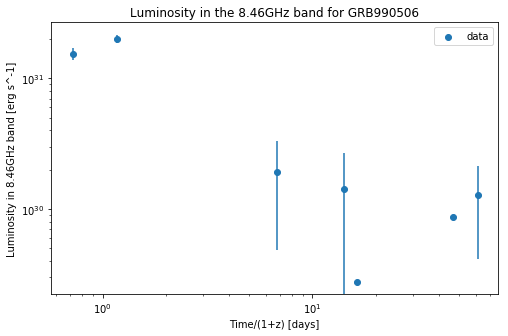

991208
[707.0, 1630.0, 1900.0, 1990.0, 999.0, 1182.0, 1930.0, 1173.0, 1146.0, 782.0, 693.0, 464.0, 679.0, 646.0, 337.0, 574.0, 400.0, 458.0, 442.0, 290.0, 239.0, 232.0, 172.0, 177.0, 123.0, 106.0, 152.0, 38.0, 29.0, 31.0, 44.0, 20.0, 51.0, 48.0]
[39.0, 51.0, 66.0, 33.0, 50.0, 52.0, 53.0, 49.0, 66.0, 40.0, 38.0, 44.0, 30.0, 58.0, 34.0, 25.0, 23.0, 31.0, 23.0, 21.0, 24.0, 27.0, 33.0, 47.0, 26.0, 23.0, 25.0, 40.0, 30.0, 27.0, 21.0, 19.0, 15.0, 20.0]
[2.73, 3.85, 5.62, 7.72, 9.62, 10.62, 11.73, 12.73, 13.77, 15.61, 18.59, 20.79, 21.3, 28.75, 32.7, 36.6, 40.66, 44.73, 48.66, 53.66, 58.61, 64.59, 96.44, 110.38, 127.48, 148.43, 151.45, 181.26, 189.21, 263.57, 277.66, 283.59, 291.58, 293.91]
[7.914658668891486e+30, 1.8247374300273158e+31, 2.126994550338589e+31, 2.22774692377568e+31, 1.1183513451517108e+31, 1.323214504473796e+31, 2.1605786748176194e+31, 1.3131392671300867e+31, 1.2829135550989593e+31, 8.754261780867246e+30, 7.757932754656012e+30, 5.194344586090028e+30, 7.601206840420535e+30, 7.2

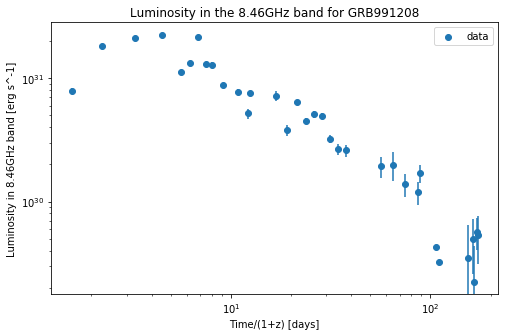

991216
[960.0, 607.0, 343.0, 127.0, 170.0, 211.0, 136.0, 123.0, 130.0, 131.0, 123.0, 79.0, 148.0, 3.0, 10.0, 47.0]
[67.0, 32.0, 43.0, 58.0, 72.0, 25.0, 37.0, 39.0, 22.0, 36.0, 30.0, 31.0, 33.0, 30.0, 24.0, 19.0]
[1.49, 2.68, 6.63, 7.62, 9.73, 11.57, 12.76, 14.59, 16.34, 17.44, 20.48, 38.28, 42.49, 50.51, 60.4, 78.18]
[2.140116123010832e+31, 1.3531775902787242e+31, 7.646456564507452e+30, 2.83119528773308e+30, 3.789788967831682e+30, 4.703796895367558e+30, 3.0318311742653454e+30, 2.742023782607628e+30, 2.8980739165771684e+30, 2.9203667928585315e+30, 2.742023782607628e+30, 1.761137226227664e+30, 3.299345689641699e+30, 6.68786288440885e+28, 2.2292876281362835e+29, 1.0477651852240531e+30]
[1.49362271085131e+30, 7.133720410036107e+29, 9.585936800986019e+29, 1.2929868243190443e+30, 1.605087092258124e+30, 5.573219070340708e+29, 8.248364224104247e+29, 8.694221749731505e+29, 4.904432781899824e+29, 8.02543546129062e+29, 6.68786288440885e+29, 6.910791647222478e+29, 7.356649172849734e+29, 6.68786288

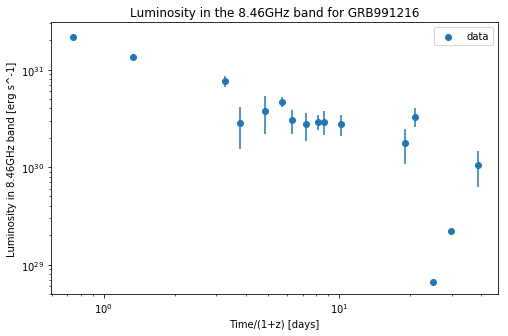

000210
[34.0, 15.0, 93.0, 20.0, 58.0, 45.0, 48.0, 7.0, 10.0, 50.0, 22.0, 60.0, 1.0, 31.0, 48.0, 98.0]
[70.0, 37.0, 21.0, 16.0, 33.0, 45.0, 26.0, 30.0, 51.0, 29.0, 22.0, 35.0, 22.0, 33.0, 31.0, 39.0]
[0.62, 4.54, 8.59, 16.59, 22.56, 46.45, 108.37, 584.04, 584.95, 585.95, 588.98, 593.93, 595.92, 599.92, 600.93, 609.93]
[5.364721134261934e+29, 2.3667887357037947e+29, 1.4674090161363532e+30, 3.155718314271727e+29, 9.151583111388008e+29, 7.100366207111384e+29, 7.573723954252142e+29, 1.1045014099951043e+29, 1.5778591571358635e+29, 7.889295785679316e+29, 3.471290145698899e+29, 9.467154942815179e+29, 1.577859157135863e+28, 4.891363387121176e+29, 7.573723954252142e+29, 1.546301973993146e+30]
[1.1045014099951043e+30, 5.838078881402694e+29, 3.313504229985312e+29, 2.5245746514173807e+29, 5.206935218548349e+29, 7.100366207111384e+29, 4.102433808553245e+29, 4.7335774714075894e+29, 8.047081701392905e+29, 4.575791555694004e+29, 3.471290145698899e+29, 5.522507049975522e+29, 3.471290145698899e+29, 5.206

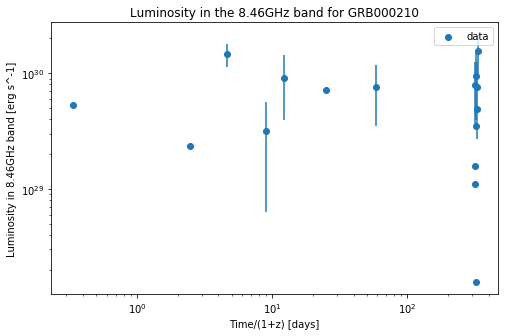

000301C
[316.0, 289.0, 483.0, 312.0, 380.0, 324.0, 338.0, 281.0, 281.0, 325.0, 227.0, 91.0, 233.0, 145.0, 150.0, 144.0, 105.0, 114.0, 110.0, 96.0, 45.0, 77.0, 48.0, 35.0, 37.0, 41.0, 33.0, 39.0, 18.0, 55.0, 87.0, 20.0]
[41.0, 34.0, 26.0, 62.0, 29.0, 36.0, 69.0, 34.0, 25.0, 27.0, 33.0, 38.0, 37.0, 36.0, 20.0, 31.0, 25.0, 24.0, 26.0, 33.0, 24.0, 21.0, 20.0, 12.0, 18.0, 24.0, 16.0, 19.0, 19.0, 26.0, 25.0, 21.0]
[4.26, 4.98, 12.17, 14.17, 16.2, 20.11, 22.14, 26.14, 30.12, 34.18, 39.95, 42.06, 45.02, 48.06, 64.08, 67.09, 82.04, 83.04, 96.99, 100.9, 104.85, 104.88, 122.65, 164.66, 471.82, 472.94, 473.92, 475.96, 503.63, 505.71, 506.73, 508.65]
[2.296600504779152e+31, 2.100371980636629e+31, 3.510310265216235e+31, 2.2675296123135936e+31, 2.761734784228094e+31, 2.35474228971027e+31, 2.4564904133397255e+31, 2.0422301957055116e+31, 2.0422301957055116e+31, 2.3620100128266598e+31, 1.6497731474204664e+31, 6.613628035914644e+30, 1.6933794861188053e+31, 1.0538198518765094e+31, 1.090158467458458e+31, 1

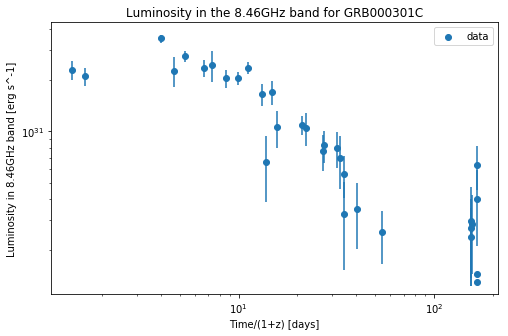

000418
[856.0, 795.0, 684.0, 1240.0, 1020.0, 926.0, 963.0, 660.0, 643.0, 341.0, 556.0, 517.0, 238.0, 230.0, 325.0, 316.0, 306.0, 296.0, 274.0, 178.0, 152.0, 168.0, 119.0, 87.0, 166.0, 100.0, 148.0, 55.0, 85.0, 94.0, 38.0, 51.0, 72.0, 50.0, 59.0]
[33.0, 37.0, 48.0, 46.0, 53.0, 53.0, 34.0, 50.0, 38.0, 50.0, 43.0, 34.0, 38.0, 33.0, 30.0, 30.0, 29.0, 22.0, 22.0, 24.0, 23.0, 22.0, 25.0, 31.0, 27.0, 25.0, 25.0, 20.0, 22.0, 14.0, 11.0, 21.0, 25.0, 26.0, 27.0]
[10.66, 11.66, 12.65, 14.63, 16.56, 20.84, 27.72, 29.83, 33.8, 38.51, 43.73, 45.63, 49.6, 54.52, 57.72, 62.69, 65.78, 69.67, 75.57, 82.63, 95.4, 101.09, 121.33, 125.24, 129.37, 131.48, 145.32, 153.27, 161.21, 202.14, 405.76, 408.82, 409.68, 410.78, 411.67]
[2.253420609579737e+31, 2.0928380661400593e+31, 1.8006304870940887e+31, 3.2643008830360673e+31, 2.685150726368378e+31, 2.4376956594285475e+31, 2.535098185777204e+31, 1.7374504700030683e+31, 1.6926979578969284e+31, 8.976827428349187e+30, 1.4636703959419787e+31, 1.36100286816907e+31, 6.2

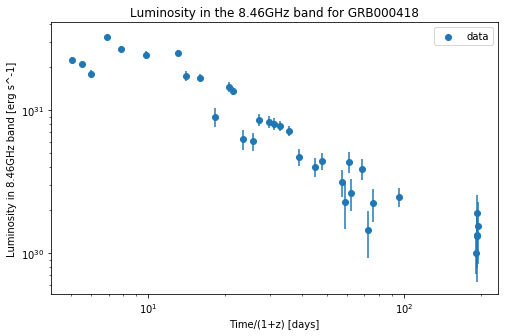

000911
[165.0, 278.0, 230.0, 90.0, 88.0, 42.0, 80.0, 54.0, 45.0, 30.0, 26.0]
[60.0, 36.0, 34.0, 22.0, 25.0, 23.0, 26.0, 24.0, 26.0, 30.0, 18.0]
[2.19, 3.06, 4.06, 6.19, 11.05, 17.2, 20.92, 22.93, 32.94, 57.08, 125.78]
[3.93476814794843e+30, 6.629488152300992e+30, 5.484828327443267e+30, 2.1462371716082348e+30, 2.0985430122391626e+30, 1.0015773467505096e+30, 1.9077663747628753e+30, 1.2877423029649408e+30, 1.0731185858041174e+30, 7.154123905360782e+29, 6.2002407179793456e+29]
[1.4308247810721564e+30, 8.584948686432938e+29, 8.10800709274222e+29, 5.2463575305979065e+29, 5.9617699211339844e+29, 5.4848283274432656e+29, 6.2002407179793456e+29, 5.723299124288625e+29, 6.2002407179793456e+29, 7.154123905360782e+29, 4.292474343216469e+29]
[1.0638814670876853, 1.4865193101773135, 1.9723099344182655, 3.007043964051494, 5.367986397862522, 8.355598736944376, 10.16273985912072, 11.139179013845032, 16.001943162496964, 27.72892883167355, 61.102744717026965]
1.0585
2.2291874206440903e+28


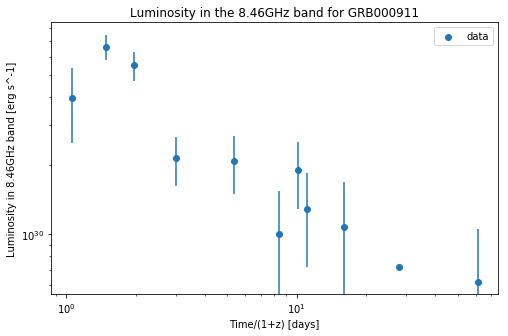

000926
[666.0, 150.0, 368.0, 440.0, 566.0, 564.0, 143.0, 242.0, 644.0, 379.0, 277.0, 170.0, 192.0, 143.0, 160.0, 10.0, 71.0, 75.0, 44.0, 30.0, 57.0]
[60.0, 55.0, 26.0, 34.0, 34.0, 76.0, 77.0, 130.0, 126.0, 36.0, 34.0, 79.0, 41.0, 35.0, 21.0, 40.0, 12.0, 21.0, 18.0, 17.0, 27.0]
[1.18, 1.98, 2.73, 7.19, 8.22, 10.78, 11.3, 13.29, 15.78, 18.69, 26.17, 30.14, 33.19, 60.65, 82.96, 124.45, 135.74, 257.43, 262.52, 287.72, 288.98]
[4.833959860189659e+31, 1.088729698240914e+31, 2.6710168596843753e+31, 3.1936071148400145e+31, 4.108140061362382e+31, 4.093623665385836e+31, 1.0379223123230048e+31, 1.756483913162008e+31, 4.674279504447657e+31, 2.7508570375553757e+31, 2.0105208427515544e+31, 1.2338936580063692e+31, 1.39357401374837e+31, 1.0379223123230048e+31, 1.1613116781236415e+31, 7.25819798827276e+29, 5.15332057167366e+30, 5.44364849120457e+30, 3.1936071148400146e+30, 2.177459396481828e+30, 4.137172853315473e+30]
[4.354918792963656e+30, 3.992008893550018e+30, 1.8871314769509175e+30, 2.467787316012

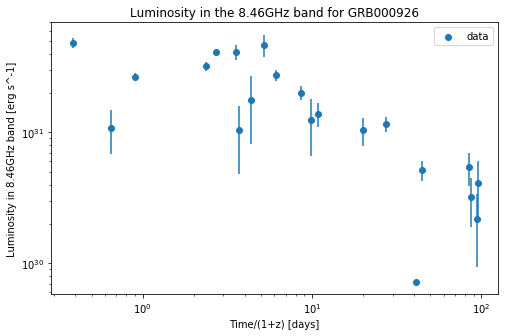

001007
[222.0, 101.0, 50.0, 34.0]
[33.0, 28.0, 48.0, 61.0]
[7.09, 14.23, 22.2, 31.23]
001018
[258.0, 405.0, 117.0, 111.0, 131.0, 55.0, 85.0]
[65.0, 50.0, 26.0, 38.0, 43.0, 19.0, 27.0]
[1.17, 2.05, 18.94, 28.85, 38.78, 57.71, 93.77]
010222
[104.0, 344.0, 226.0, 128.0, 114.0, 111.0, 56.0, 89.0, 60.0, 29.0, 68.0, 40.0, 43.0, 40.0, 52.0, 28.0, 15.0, 6.0, 14.0, 22.0, 46.0, 39.0, 25.0, 43.0, 23.0]
[55.0, 39.0, 42.0, 31.0, 33.0, 36.0, 29.0, 28.0, 16.0, 24.0, 22.0, 16.0, 24.0, 24.0, 18.0, 17.0, 19.0, 10.0, 21.0, 19.0, 24.0, 31.0, 15.0, 18.0, 14.0]
[0.27, 1.35, 2.24, 5.44, 6.91, 8.31, 10.26, 11.05, 20.22, 28.88, 31.25, 38.13, 49.0, 73.22, 88.11, 94.98, 121.93, 125.87, 126.68, 128.74, 173.69, 183.46, 183.92, 185.81, 206.63]
[4.453699484606198e+30, 1.4731467526005112e+31, 9.678231572317313e+30, 5.481476288746087e+30, 4.881939819664485e+30, 4.7534677191469987e+30, 2.3981458763264136e+30, 3.8113389820187636e+30, 2.569442010349729e+30, 1.2418969716690355e+30, 2.912034278396359e+30, 1.712961340233152

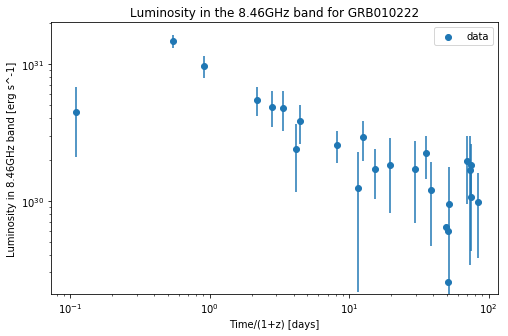

010921
[222.0, 229.0, 158.0, 123.0, 135.0, 108.0, 89.0, 60.0, 40.0, 68.0, 50.0, 70.0, 36.0, 76.0, 21.0, 2.0, 4.0, 52.0]
[16.0, 22.0, 26.0, 26.0, 24.0, 27.0, 15.0, 20.0, 21.0, 25.0, 24.0, 17.0, 34.0, 21.0, 17.0, 23.0, 13.0, 15.0]
[25.93, 27.01, 37.77, 38.77, 42.92, 47.95, 58.75, 83.86, 84.67, 96.83, 97.81, 99.7, 101.53, 112.3, 132.77, 175.75, 221.41, 225.42]
[1.03333630029352e+30, 1.0659189764289015e+30, 7.354375470557484e+29, 5.7252416637884205e+29, 6.283801826109243e+29, 5.027041460887394e+29, 4.142654537212759e+29, 2.7928008116041083e+29, 1.8618672077360722e+29, 3.1651742531513217e+29, 2.3273340096700897e+29, 3.258267613538126e+29, 1.675680486962465e+29, 3.537547694698536e+29, 9.774802840614378e+28, 9.309336038680359e+27, 1.8618672077360717e+28, 2.4204273700568935e+29]
[7.447468830944287e+28, 1.0240269642548395e+29, 1.2102136850284467e+29, 1.2102136850284467e+29, 1.1171203246416431e+29, 1.2567603652218485e+29, 6.982002029010271e+28, 9.309336038680361e+28, 9.774802840614378e+28, 1.163

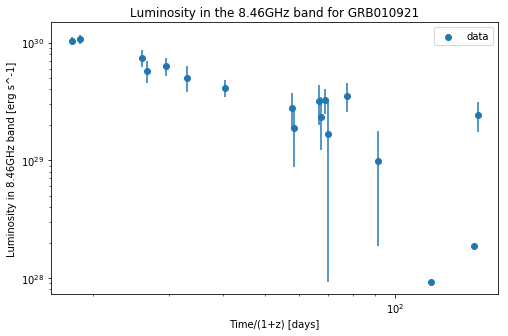

011030
[58.0, 61.0, 43.0, 174.0, 114.0, 155.0, 118.0, 99.0, 132.0, 52.0, 110.0, 158.0, 49.0, 48.0, 219.0, 161.0, 202.0, 30.0, 94.0, 145.0, 81.0, 83.0, 6.0, 53.0, 61.0, 13.0, 36.0, 46.0, 0.0, 81.0, 18.0, 5.0, 11.0, 22.0]
[19.0, 31.0, 31.0, 20.0, 27.0, 40.0, 35.0, 14.0, 24.0, 27.0, 31.0, 22.0, 29.0, 25.0, 31.0, 19.0, 36.0, 22.0, 19.0, 21.0, 10.0, 13.0, 29.0, 27.0, 24.0, 27.0, 29.0, 23.0, 23.0, 24.0, 19.0, 24.0, 26.0, 23.0]
[0.86, 2.52, 5.55, 9.53, 9.86, 10.65, 11.12, 12.76, 14.09, 15.7, 15.88, 16.9, 21.07, 21.88, 24.31, 24.98, 25.93, 28.66, 30.5, 32.81, 34.63, 37.3, 41.72, 46.98, 51.8, 54.79, 59.97, 79.85, 84.86, 111.65, 132.53, 163.27, 172.78, 423.72]
011211
[39.0, 37.0, 150.0, 105.0, 102.0, 163.0, 136.0, 27.0, 68.0, 24.0]
[36.0, 25.0, 17.0, 23.0, 23.0, 22.0, 27.0, 28.0, 21.0, 16.0]
[0.68, 1.79, 6.78, 7.72, 10.75, 11.79, 16.79, 25.79, 27.62, 36.68]
[3.057731647966013e+30, 2.900924896788268e+30, 1.1760506338330818e+31, 8.232354436831571e+30, 7.997144310064957e+30, 1.2779750220986153e+31,

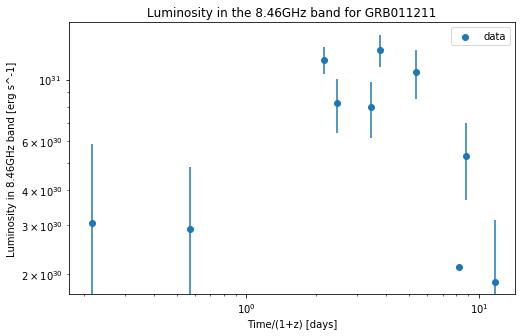

020124
[84.0, 45.0, 49.0]
[30.0, 25.0, 17.0]
[1.77, 2.77, 7.95]
[1.1900906323113024e+31, 6.375485530239119e+30, 6.942195355149263e+30]
[4.25032368682608e+30, 3.5419364056883997e+30, 2.4085167558681114e+30]
[0.421629347308242, 0.6598380181038589, 1.8937589328251547]
3.198
8.737899919012435e+28


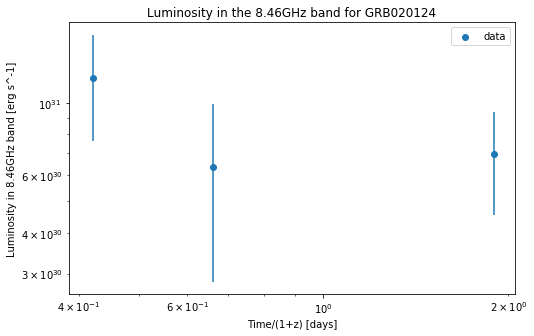

020305
[57.0, 76.0, 3.5, 65.0, 48.0]
[22.0, 15.0, 25.0, 25.0, 23.0]
[7.91, 22.89, 62.8, 78.57, 85.7]
020405
[487.0, 144.0, 128.0, 75.0, 37.0, 106.0, 57.0, 60.0, 8.0, 26.0]
[34.0, 43.0, 41.0, 18.0, 27.0, 20.0, 20.0, 25.0, 21.0, 25.0]
[1.19, 3.33, 4.37, 5.25, 8.21, 16.25, 32.21, 46.13, 49.14, 52.16]
[5.210751166421592e+30, 1.540755991713982e+30, 1.3695608815235395e+30, 8.02477079017699e+29, 3.9588869231539815e+29, 1.1341676050116812e+30, 6.098825800534512e+29, 6.41981663214159e+29, 8.559755509522122e+28, 2.7819205405946898e+29]
[3.637896091546901e+29, 4.600868586368141e+29, 4.386874698630087e+29, 1.9259449896424775e+29, 2.888917484463716e+29, 2.139938877380531e+29, 2.139938877380531e+29, 2.674923596725663e+29, 2.246935821249557e+29, 2.674923596725663e+29]
[0.7042003479578189, 1.9705774442853254, 2.5860130425005625, 3.1067662409903782, 4.858390635910668, 9.616181222113076, 19.060750594723824, 27.298119370835458, 29.079332015669937, 30.866462310487258]
0.68986
1.3091253680293973e+28


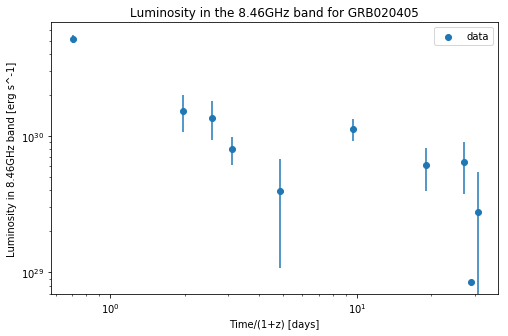

020813
[323.0, 263.0, 87.4, 195.0, 47.0, 26.0, 55.0, 63.0, 38.0, 36.0, 11.0, 38.0]
[39.0, 27.0, 33.0, 31.0, 34.0, 35.0, 32.0, 30.0, 23.0, 22.0, 15.0, 18.0]
[1.24, 2.17, 4.02, 5.16, 6.22, 9.01, 10.2, 16.13, 28.12, 36.11, 41.11, 42.07]
[1.0425426386861185e+31, 8.488814674131554e+30, 2.820997728209497e+30, 6.293988066371303e+30, 1.5170125083048784e+30, 8.391984088495072e+29, 1.775227403335496e+30, 2.0334422983661135e+30, 1.2265207513954336e+30, 1.1619670276377792e+30, 3.550454806670992e+29, 1.2265207513954336e+30]
[1.2587976132742607e+30, 8.714752707283344e+29, 1.0651364420012975e+30, 1.000582718243643e+30, 1.0974133038801245e+30, 1.129690165758952e+30, 1.0328595801224702e+30, 9.68305856364816e+29, 7.423678232130256e+29, 7.100909613341985e+29, 4.84152928182408e+29, 5.809835138188896e+29]
[0.5501330967169477, 0.9627329192546583, 1.7834960070984913, 2.2892635314995564, 2.759538598047915, 3.997338065661047, 4.525288376220053, 7.1561668145519075, 12.475598935226264, 16.020408163265305, 18.238

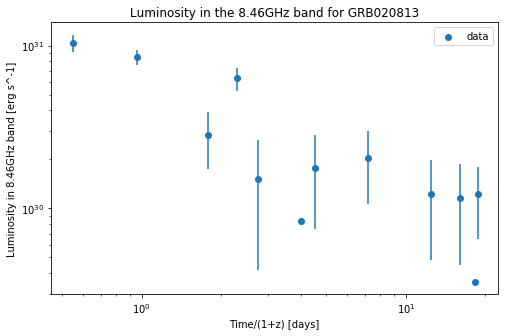

020819
[315.0, 176.0, 264.0, 161.0, 109.0, 43.0, 79.0, 32.0, 62.0, 5.7]
[18.0, 19.0, 30.0, 24.0, 20.0, 31.0, 25.0, 26.0, 25.0, 14.0]
[1.75, 3.72, 9.7, 21.65, 29.64, 44.55, 126.45, 130.4, 143.44, 157.28]
[2.1519963338394475e+31, 1.202385253192834e+31, 1.803577879789251e+31, 1.0999092372957175e+31, 7.446590488523801e+30, 2.9376457890506745e+30, 5.397070170581472e+30, 2.186155005805153e+30, 4.235675323747484e+30, 3.894088604090429e+29]
[1.2297121907653987e+30, 1.2980295346968093e+30, 2.0495203179423307e+30, 1.6396162543538646e+30, 1.3663468786282208e+30, 2.117837661873742e+30, 1.7079335982852758e+30, 1.776250942216687e+30, 1.7079335982852758e+30, 9.564428150397547e+29]
[0.5907970696465346, 1.2558657709057763, 3.274703757469363, 7.3090037473414124, 10.006414368184734, 15.040005401573207, 42.68930826103103, 44.02282164680464, 48.425103811485094, 53.0974646365754]
1.9621
4.809061880877613e+28


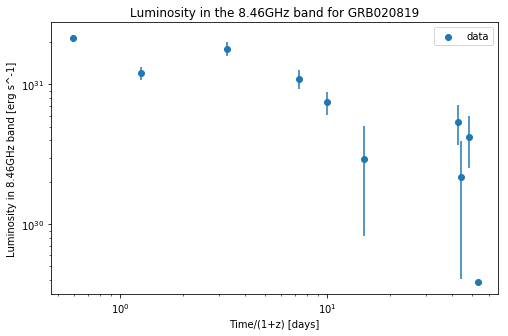

020903
[1058.0, 746.0, 765.0, 640.0, 190.0]
[19.0, 37.0, 41.0, 40.0, 30.0]
[23.8, 25.69, 28.65, 36.72, 70.6]
[1.5168662687534805e+30, 1.069548427684401e+30, 1.0967889372366848e+30, 9.175750586032397e+29, 2.724050955228368e+29]
[2.7240509552283675e+28, 5.304730807549979e+28, 5.8782152191770035e+28, 5.734844116270248e+28, 4.301133087202686e+28]
[19.03086518471134, 20.542139772909007, 22.90900367823445, 29.36190628498321, 56.45290260674876]
0.2506
3.920771180849781e+27


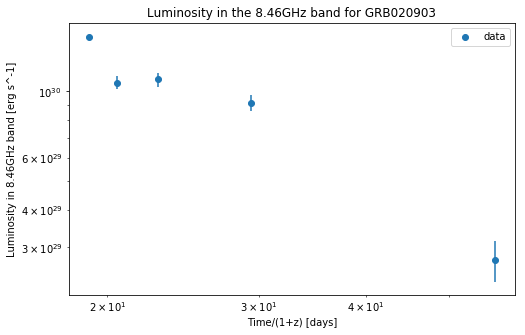

021004
[206.0, 288.0, 546.0, 598.0, 252.0, 352.0, 691.0, 423.0, 780.0, 324.0, 551.0, 625.0, 535.0, 386.0, 394.0, 279.0, 272.0, 215.0, 166.0, 94.0, 47.0, 42.0, 79.0, 69.0, 71.0, 71.0, 52.0, 44.0]
[45.0, 46.0, 33.0, 33.0, 57.0, 39.0, 44.0, 47.0, 51.0, 40.0, 38.0, 35.0, 36.0, 29.0, 42.0, 28.0, 27.0, 19.0, 15.0, 16.0, 24.0, 24.0, 16.0, 16.0, 20.0, 24.0, 16.0, 12.0]
[0.79, 1.79, 3.62, 5.68, 6.63, 8.51, 12.61, 13.5, 17.53, 21.48, 29.52, 33.69, 35.88, 41.79, 48.51, 56.78, 64.52, 79.53, 94.42, 140.24, 142.2, 168.2, 171.25, 172.29, 174.3, 179.23, 185.26, 199.26]
[1.8388704767628762e+31, 2.5708480451830506e+31, 4.873899418992866e+31, 5.338080316039806e+31, 2.249492039535169e+31, 3.1421476107792837e+31, 6.1682499972968325e+31, 3.7759330663626048e+31, 6.962713455704095e+31, 2.8922040508309317e+31, 4.918532197555071e+31, 5.579097320275717e+31, 4.775707306156014e+31, 3.4456505050022833e+31, 3.5170629507018124e+31, 2.4905090437710797e+31, 2.428023153783992e+31, 1.9192094781748466e+31, 1.4818082482652

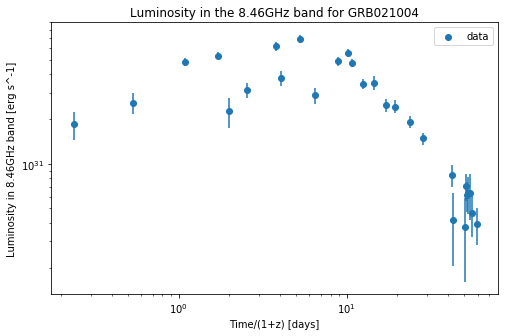

021206
[137.0, 102.0, 22.0, 72.0, 61.0, 64.0, 79.0]
[35.0, 36.0, 35.0, 25.0, 23.0, 32.0, 26.0]
[68.63, 73.5, 78.44, 88.47, 107.5, 109.61, 113.61]
021211
[12.0, 9.0, 45.0, 60.0, 0.3, 33.0, 2.4, 46.0]
[36.0, 45.0, 23.0, 28.0, 27.0, 28.0, 24.0, 24.0]
[0.1, 1.93, 3.85, 8.85, 10.79, 17.08, 23.92, 25.81]
[2.598975475700326e+29, 1.9492316067752448e+29, 9.746158033876223e+29, 1.2994877378501628e+30, 6.497438689250815e+27, 7.147182558175898e+29, 5.197950951400652e+28, 9.962739323517918e+29]
[7.796926427100979e+29, 9.746158033876223e+29, 4.981369661758959e+29, 6.064276109967428e+29, 5.8476948203257346e+29, 6.064276109967428e+29, 5.197950951400652e+29, 5.197950951400652e+29]
[0.0499001996007984, 0.9630738522954091, 1.9211576846307385, 4.416167664670659, 5.384231536926147, 8.522954091816366, 11.936127744510978, 12.879241516966067]
1.004
2.0867512411917965e+28


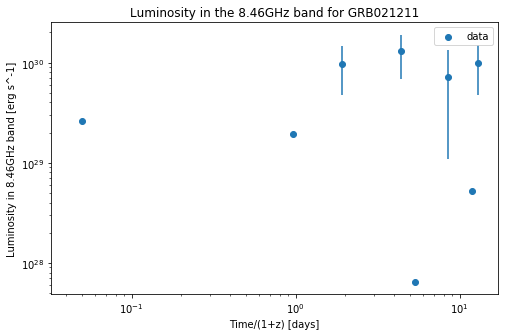

030115
[94.0, 80.0, 83.0, 61.0, 21.0, 45.0]
[22.0, 37.0, 23.0, 31.0, 20.0, 21.0]
[2.28, 5.23, 7.26, 11.1, 32.17, 42.09]
[9.328045249509516e+30, 7.938761914476184e+30, 8.236465486269042e+30, 6.053305959788089e+30, 2.083925002549998e+30, 4.465553576892853e+30]
[2.1831595264809504e+30, 3.671677385445235e+30, 2.2823940504119028e+30, 3.076270241859521e+30, 1.984690478619046e+30, 2.083925002549998e+30]
[0.6514285714285714, 1.4942857142857144, 2.0742857142857143, 3.1714285714285713, 9.191428571428572, 12.025714285714287]
2.5
6.477963442919521e+28


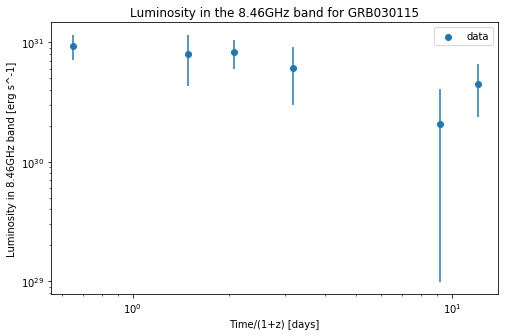

030226
[70.0, 131.0, 121.0, 44.0, 5.2, 40.0, 35.0]
[12.0, 27.0, 27.0, 37.0, 23.0, 21.0, 18.0]
[1.09, 4.1, 11.11, 16.24, 19.28, 22.19, 25.03]
[4.8784866463123795e+30, 9.12973929524174e+30, 8.432812631482827e+30, 3.06647732053921e+30, 3.62401865154634e+29, 2.787706655035646e+30, 2.4392433231561897e+30]
[8.363119965106936e+29, 1.8817019921490608e+30, 1.8817019921490608e+30, 2.5786286559079725e+30, 1.602931326645496e+30, 1.4635459938937137e+30, 1.2544679947660406e+30]
[0.3649256254791742, 1.3726560224445998, 3.71956302667305, 5.437057025487879, 6.454831247007777, 7.429082228791628, 8.379897619948375]
1.98691
4.884311641852732e+28


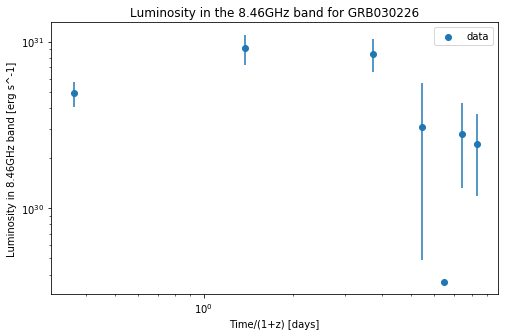

[2.4708694577427772e+30]
[9.265760466535414e+29]
[2.7656903765690384]
1.39
3.1332514466875746e+28


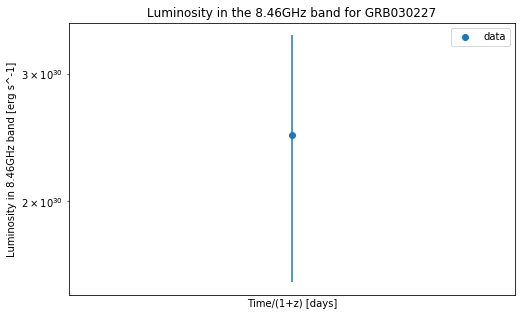

[4.269773815303821e+30]
[5.794693035055184e+30]
[0.7891486344297544]
3.3718
9.31376646703699e+28


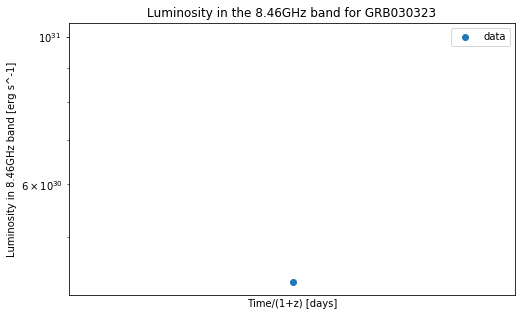

030329
[1980.0, 8500.0, 6110.0, 9680.0, 15560.0, 12550.0, 13580.0, 17700.0, 17280.0, 19150.0, 17770.0, 15920.0, 16080.0, 15340.0, 12670.0, 13550.0, 13100.0, 10640.0, 8040.0, 8680.0, 4480.0, 4930.0, 3454.0, 3572.0, 3016.0, 2130.0, 2299.0, 1525.0, 1277.0, 1122.0, 1002.0, 1050.0, 931.0, 874.0, 637.0, 696.0, 686.0, 675.0, 547.0, 447.0, 528.0, 470.0, 362.0, 270.0, 267.0, 267.0, 298.0, 394.0, 387.0, 233.0, 271.0, 334.0, 304.0, 114.0, 232.0]
[170.0, 50.0, 40.0, 30.0, 60.0, 210.0, 90.0, 50.0, 100.0, 80.0, 100.0, 70.0, 60.0, 60.0, 90.0, 70.0, 60.0, 60.0, 80.0, 80.0, 90.0, 60.0, 69.0, 54.0, 31.0, 55.0, 65.0, 56.0, 51.0, 45.0, 91.0, 38.0, 41.0, 44.0, 33.0, 31.0, 38.0, 24.0, 27.0, 33.0, 29.0, 47.0, 29.0, 39.0, 29.0, 29.0, 21.0, 38.0, 41.0, 29.0, 41.0, 82.0, 35.0, 28.0, 52.0]
[1.05, 2.65, 3.57, 4.73, 6.89, 7.68, 9.49, 11.9, 12.69, 14.87, 16.66, 18.72, 20.58, 25.7, 28.44, 31.51, 33.58, 36.52, 42.55, 44.55, 59.55, 66.53, 72.52, 77.54, 87.53, 93.46, 101.54, 135.48, 149.4, 173.3, 177.26, 182.27, 191.25

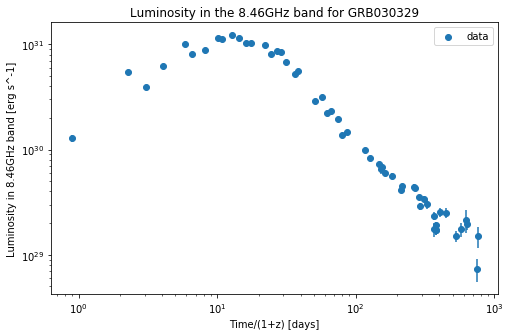

[9.127867863183886e+30, 7.715221646262569e+30]
[5.867915054903928e+30, 3.585948089107955e+30]
[1.5390924002186988, 4.559868780754511]
2.658
6.98129352331091e+28


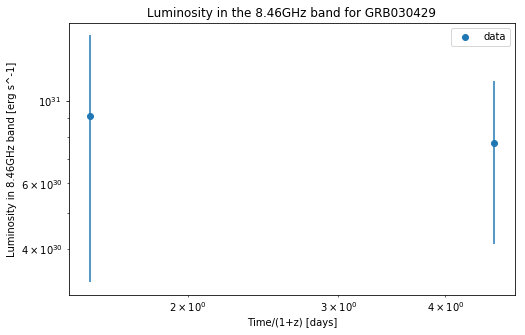

030723
[80.0, 170.0, 165.0, 219.0, 105.0, 93.0]
[62.0, 34.0, 32.0, 22.0, 34.0, 19.0]
[3.15, 54.01, 77.92, 84.86, 120.77, 134.77]
031203
[540.0, 249.0, 53.0, 280.0, 304.0, 448.0, 457.0, 811.0, 467.0, 675.0, 459.0, 308.0, 647.0, 664.0, 450.0, 533.0, 517.0, 517.0, 304.0, 432.0, 426.0]
[62.0, 43.0, 52.0, 49.0, 42.0, 39.0, 41.0, 40.0, 46.0, 45.0, 47.0, 43.0, 45.0, 61.0, 44.0, 28.0, 42.0, 47.0, 46.0, 42.0, 37.0]
[1.6, 3.6, 4.43, 8.46, 11.45, 13.46, 17.43, 19.45, 22.48, 27.41, 31.41, 35.34, 39.37, 42.43, 52.32, 65.32, 73.3, 86.21, 93.25, 110.21, 137.15]
[1.345537738397567e+29, 6.204424015944336e+28, 1.320620372871686e+28, 6.976862347246643e+28, 7.574879119867783e+28, 1.116297975559463e+29, 1.1387236045327555e+29, 2.0207983441489382e+29, 1.1636409700586363e+29, 1.6819221729969583e+29, 1.1437070776379318e+29, 7.674548581971307e+28, 1.612153549524492e+29, 1.6545130709184896e+29, 1.121281448664639e+29, 1.32809558252945e+29, 1.2882277976880406e+29, 1.2882277976880406e+29, 7.574879119867783e+28, 1.

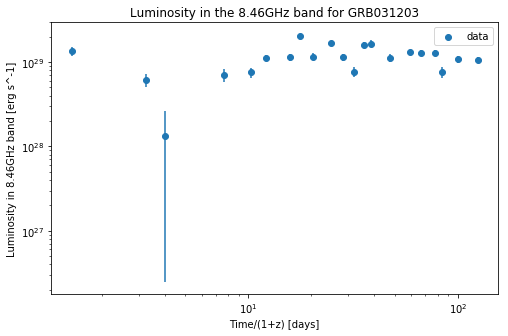

041219
[449.0, 518.0, 379.0, 0.0, 63.0]
[51.0, 150.0, 47.0, 47.0, 42.0]
[1.11, 1.69, 4.65, 8.18, 12.15]
[9.880435146410195e+29, 1.139880936712802e+30, 8.340055502203705e+29, 0.0, 1.38634167978584e+29]
[1.1222765979218707e+29, 3.30081352329962e+29, 1.034254903967214e+29, 1.034254903967214e+29, 9.242277865238937e+28]
[0.8473282442748092, 1.2900763358778624, 3.549618320610687, 6.244274809160305, 9.274809160305344]
0.31
5.01003543077181e+27


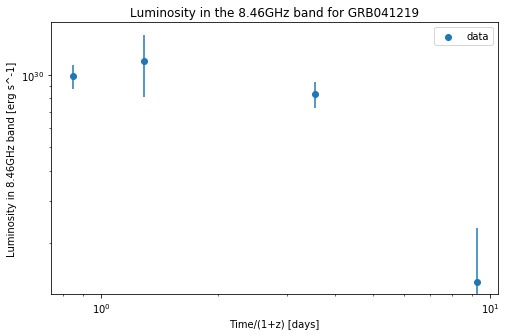

[6.276748125607145e+30]
[1.925578662262531e+31]
[5.375690607734807]
2.62
6.8597579756580384e+28


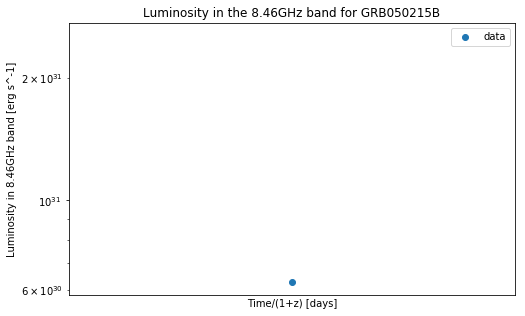

[2.029461696375921e+31]
[4.1942208391769027e+30]
[0.2745762711864407]
1.95
4.772429784172992e+28


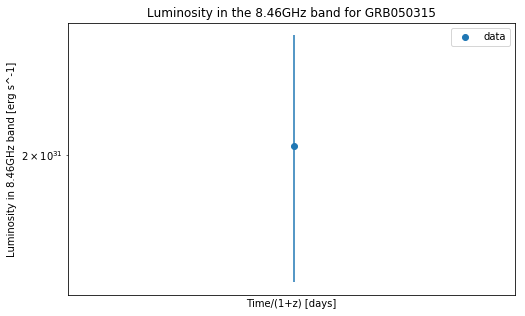

[1.5040317648001177e+31]
[4.0682826424921215e+30]
[1.4592736971686502]
2.8992
7.75938554582824e+28


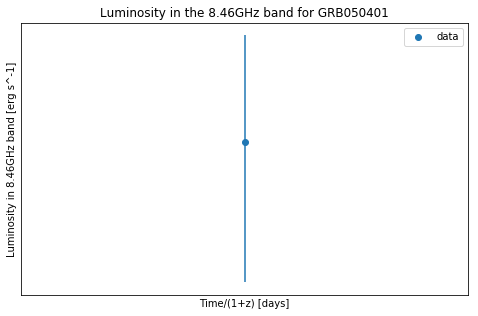

[1.5726216993287847e+29]
[1.226644925476452e+30]
[1.1316366238761908]
1.2357
2.704983055515198e+28


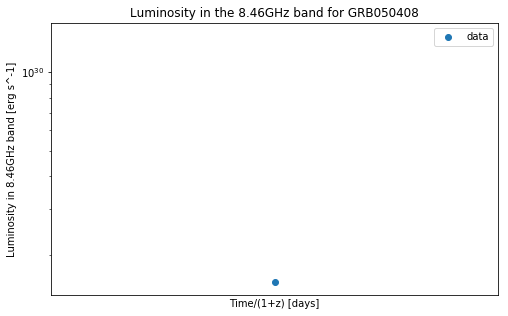

050416A
[20.0, 101.0, 132.0, 431.0, 398.0, 330.0, 286.0, 189.0, 93.0, 72.0, 41.0, 89.0]
[51.0, 34.0, 30.0, 46.0, 33.0, 35.0, 33.0, 36.0, 41.0, 42.0, 47.0, 38.0]
[0.026, 5.56, 11.82, 44.64, 52.57, 61.51, 64.7, 76.46, 104.6, 120.51, 127.42, 182.28]
[1.9238260971701194e+29, 9.715321790709105e+29, 1.2697252241322789e+30, 4.1458452394016074e+30, 3.828413933368538e+30, 3.174313060330698e+30, 2.751071318953271e+30, 1.818015661825763e+30, 8.945791351841056e+29, 6.925773949812432e+29, 3.9438434991987446e+29, 8.561026132407032e+29]
[4.905756547783805e+29, 3.270504365189203e+29, 2.885739145755179e+29, 4.424800023491275e+29, 3.174313060330697e+29, 3.3666956700477094e+29, 3.174313060330697e+29, 3.462886974906216e+29, 3.9438434991987446e+29, 4.040034804057251e+29, 4.5209913283497806e+29, 3.655269584623227e+29]
[0.01573088092933204, 3.3639883833494673, 7.151500484027106, 27.008712487899324, 31.806631171345593, 37.21563407550823, 39.145692158760895, 46.260890609874146, 63.286544046466595, 72.912633107

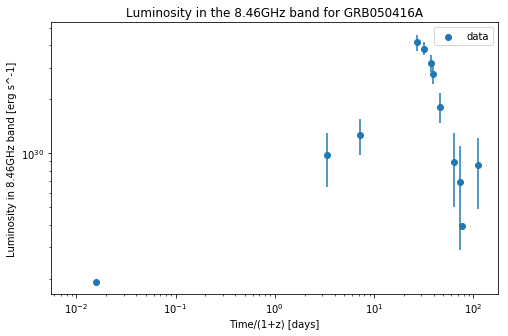

050509C
[310.0, 404.0, 223.0, 203.0, 227.0]
[49.0, 58.0, 55.0, 48.0, 59.0]
[29.18, 44.14, 50.12, 71.06, 90.99]
050525A
[80.0, 164.0, 164.0, 88.0, 56.0, 178.0]
[34.0, 46.0, 48.0, 42.0, 59.0, 46.0]
[0.44, 3.33, 13.47, 19.44, 23.54, 32.47]
[6.667642728313488e+29, 1.3668667593042647e+30, 1.3668667593042647e+30, 7.334407001144836e+29, 4.667349909819441e+29, 1.4835505070497506e+30]
[2.8337481595332317e+29, 3.833894568780255e+29, 4.000585636988092e+29, 3.50051243236458e+29, 4.9173865121311966e+29, 3.833894568780255e+29]
[0.27392143435223804, 2.0730872190748926, 8.385731183465106, 12.102347008653428, 14.654796737844736, 20.214156757766293]
0.6063
1.1170021470784377e+28


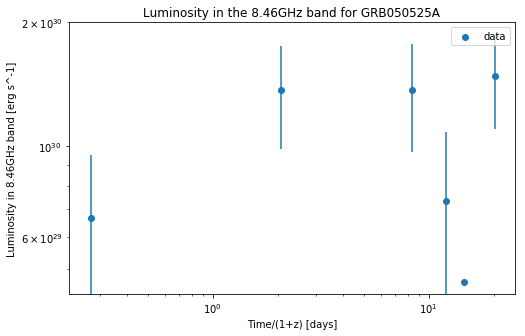

050603
[262.0, 158.0, 241.0, 167.0, 122.0, 316.0, 79.0]
[41.0, 42.0, 39.0, 40.0, 38.0, 45.0, 49.0]
[0.35, 1.46, 6.46, 25.24, 31.2, 36.19, 52.15]
[3.1003575009893465e+31, 1.869681241054644e+31, 2.851855563887147e+31, 1.9761820712413005e+31, 1.4436779203080162e+31, 3.739362482109288e+31, 9.34840620527322e+30]
[4.851704486281037e+30, 4.9700387420439907e+30, 4.615035974755134e+30, 4.733370230518086e+30, 4.496701718992181e+30, 5.325041509332846e+30, 5.798378532384655e+30]
[0.09167103195390255, 0.3823991618648507, 1.6919853326348873, 6.610790990047144, 8.171817705605028, 9.478784704033524, 13.658983761131482]
2.818
7.496195871240019e+28


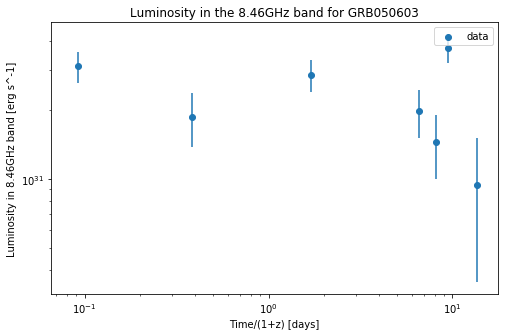

050713B
[426.0, 216.0, 206.0, 260.0, 299.0, 244.0, 226.0, 296.0, 296.0, 188.0, 243.0, 36.0, 134.0, 46.0, 72.0]
[45.0, 44.0, 58.0, 37.0, 38.0, 38.0, 38.0, 40.0, 40.0, 50.0, 43.0, 78.0, 56.0, 39.0, 42.0]
[5.96, 7.66, 8.57, 10.95, 11.91, 16.94, 17.95, 21.01, 21.01, 23.92, 25.92, 33.06, 33.88, 36.95, 46.86]
050724
[173.0, 465.0, 208.0, 122.0, 0.0]
[30.0, 29.0, 40.0, 37.0, 24.0]
[0.57, 1.69, 2.62, 5.56, 9.69]
[2.634360450757806e+29, 7.080795431227629e+29, 3.1673235477319296e+29, 1.8577570808812274e+29, 0.0]
[4.568255116921052e+28, 4.415979946357016e+28, 6.091006822561402e+28, 5.634181310869297e+28, 3.6546040935368415e+28]
[0.4530281354315689, 1.3431886822444763, 2.082339850580194, 4.419011285964076, 7.701478302336671]
0.2582
4.0570410549131417e+27


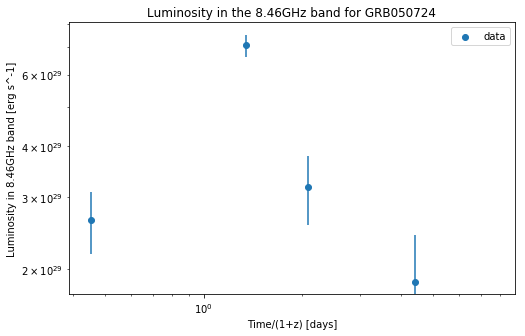

050730
[145.0, 169.0, 212.0]
[28.0, 28.0, 35.0]
[2.2, 2.2, 9.14]
[2.7558006364786916e+31, 3.211933155619992e+31, 4.029170585748156e+31]
[5.321546056648507e+30, 5.321546056648507e+30, 6.651932570810635e+30]
[0.4427851183947027, 0.4427851183947027, 1.8395709009670829]
3.96855
1.1323692689730939e+29


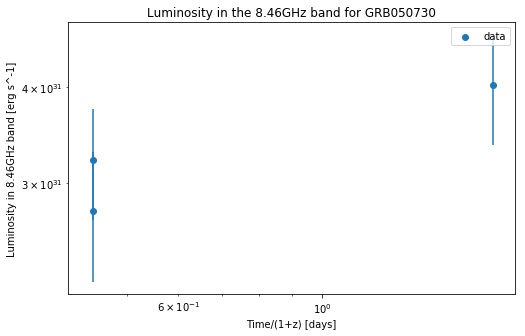

[5.300103721006404e+30]
[1.906512129858418e+30]
[8.033613445378153]
1.38
3.10513979344015e+28


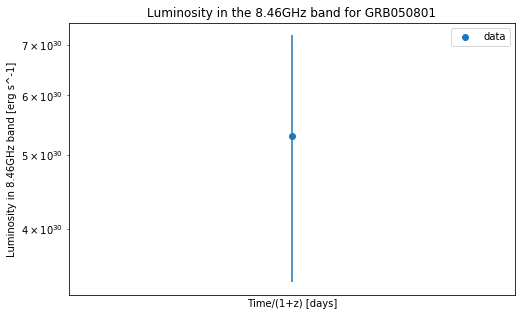

[2.225113583640452e+31]
[1.0973162878226887e+31]
[0.3751846381093058]
5.77
1.762525907915087e+29


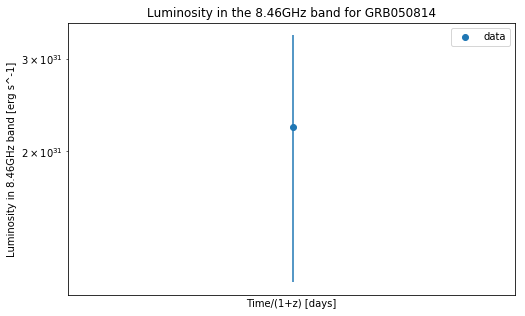

050820A
[110.0, 634.0, 419.0, 74.0, 34.0, 69.0, 166.0, 89.0, 106.0, 76.0]
[40.0, 62.0, 50.0, 36.0, 57.0, 60.0, 45.0, 39.0, 33.0, 30.0]
[0.116, 0.93, 2.15, 4.11, 5.05, 6.13, 8.1, 12.06, 14.91, 25.93]
[1.1667433823110428e+31, 6.724684585320009e+31, 4.444231610802972e+31, 7.849000935547015e+30, 3.606297727143222e+30, 7.31866303449654e+30, 1.7607218314875737e+31, 9.440014638698433e+30, 1.1243163502270047e+31, 8.061136095967203e+30]
[4.242703208403792e+30, 6.576189973025875e+30, 5.303379010504738e+30, 3.8184328875634123e+30, 6.045852071975402e+30, 6.364054812605686e+30, 4.7730411094542655e+30, 4.1366356281936963e+30, 3.5002301469331277e+30, 3.182027406302843e+30]
[0.03209127200396161, 0.25728347382486466, 0.5947951276596333, 1.1370269649679503, 1.3970769277586736, 1.6958577360714198, 2.2408560623455953, 3.3363856928256643, 4.12483504809541, 7.173505888471764]
2.61469
6.8427987961049475e+28


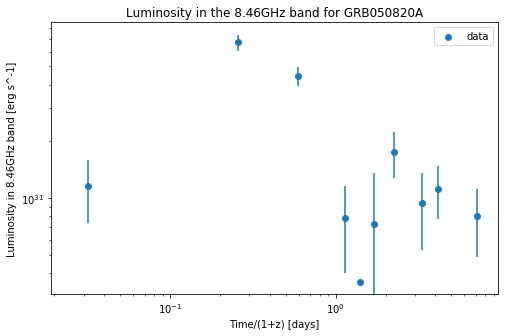

050824
[44.0, 152.0, 36.0]
[50.0, 34.0, 27.0]
[0.35, 7.36, 68.24]
[6.664659846881974e+29, 2.302337038013773e+30, 5.452903511085252e+29]
[7.573477098729516e+29, 5.14996442713607e+29, 4.0896776333139396e+29]
[0.1914556096493627, 4.026037962912313, 37.32837372135003]
0.8281
1.641437520739885e+28


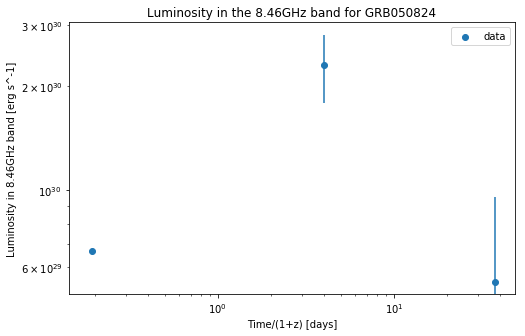

050904
[89.0, 41.0, 27.0, 89.0, 40.0, 64.0, 116.0, 67.0, 13.0]
[58.0, 25.0, 24.0, 37.0, 30.0, 23.0, 18.0, 17.0, 27.0]
[0.5, 1.4, 6.23, 20.12, 29.28, 34.18, 35.26, 37.35, 44.29]
[3.009600477007447e+31, 1.3864451635652286e+31, 9.13024863811248e+30, 3.009600477007447e+31, 1.352629427868516e+31, 2.1642070845896246e+31, 3.9226253408186954e+31, 2.265654291679764e+31, 4.3960456405726765e+30]
[1.9613126704093477e+31, 8.453933924178221e+30, 8.115776567211094e+30, 1.251182220778377e+31, 1.0144720709013867e+31, 7.777619210243964e+30, 6.08683242540832e+30, 5.748675068441192e+30, 9.13024863811248e+30]
[0.06854009595613433, 0.19191226867717615, 0.8540095956134339, 2.7580534612748457, 4.013708019191227, 4.685400959561344, 4.833447566826593, 5.119945167923236, 6.07128169979438]
6.295
1.951213021838852e+29


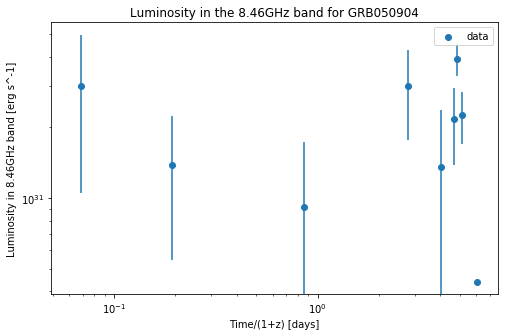

[4.3367545633379364e+30]
[3.126497475894791e+30]
[0.8816942137045332]
2.5273
6.564548498011572e+28


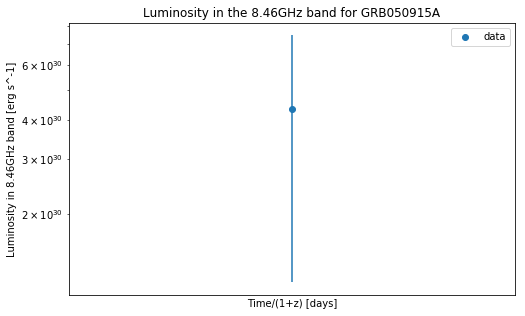

[1.1435434765136703e+31]
[3.430630429541011e+30]
[0.41885471367841964]
2.1992
5.535433672608987e+28


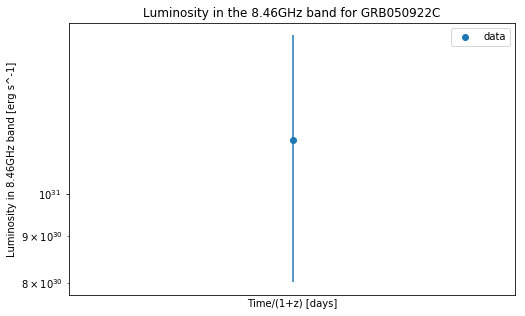

[6.668089532102975e+29]
[2.4767189690668197e+29]
[9.21813674860566]
0.9364
1.912897970302023e+28


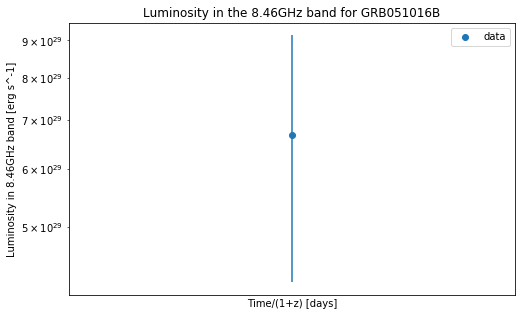

051022
[585.0, 184.0, 240.0, 199.0, 41.0]
[49.0, 78.0, 29.0, 34.0, 23.0]
[1.11, 2.46, 4.15, 9.19, 17.14]
[8.479690413274233e+30, 2.66711630092728e+30, 3.478847349035583e+30, 2.8845442602420036e+30, 5.943030887935788e+29]
[7.102646670947647e+29, 1.1306253884365644e+30, 4.203607213417996e+29, 4.928367077800409e+29, 3.3338953761591e+29]
[0.6135986733001658, 1.3598673300165836, 2.2940851299060254, 5.080154781647318, 9.474847982310669]
0.809
1.5945305506453502e+28


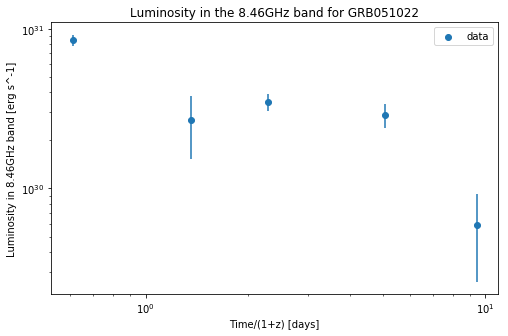

051109A
[117.0, 77.0, 63.0]
[24.0, 29.0, 21.0]
[1.1, 4.05, 22.03]
[1.1236898741267698e+31, 7.395223957928311e+30, 6.050637783759527e+30]
[2.3050048700036295e+30, 2.785214217921053e+30, 2.016879261253176e+30]
[0.3192106790481718, 1.175275681950087, 6.392919326755659]
2.446
6.307184754778847e+28


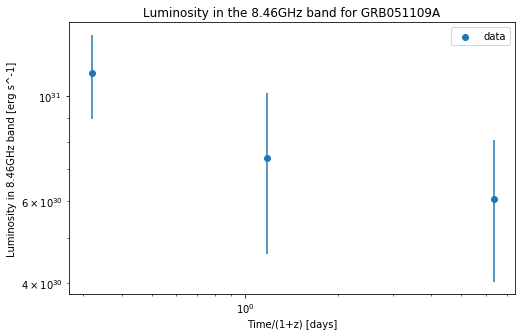

[3.575132171639143e+27, 2.860105737311314e+26]
[3.2891215979080114e+27, 4.004148032235841e+27]
[0.7314814814814815, 3.4907407407407405]
0.08
1.1229324146736976e+27


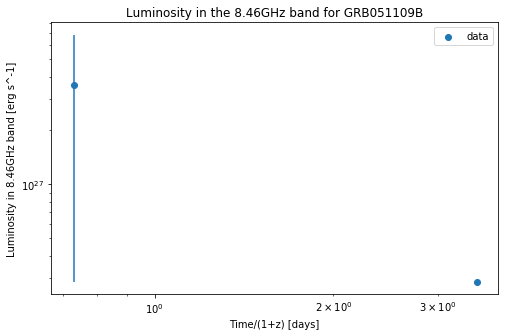

051111
[98.0, 80.0, 70.0]
[28.0, 32.0, 49.0]
[1.9, 16.77, 22.65]
[4.5511803493553544e+30, 3.715249264779881e+30, 3.250843106682396e+30]
[1.3003372426729585e+30, 1.4860997059119524e+30, 2.2755901746776772e+30]
[0.7452500117671054, 6.577811945965451, 8.884164613960493]
1.54948
3.587664246099968e+28


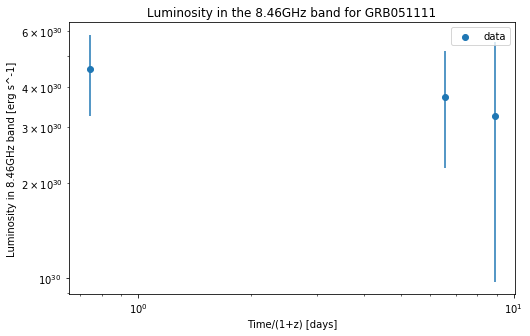

[5.985155155155478e+29, 7.481443943944347e+28]
[1.768341295841391e+29, 2.1764200564201733e+29]
[0.5884635281945163, 4.449042938437661]
0.5464
9.837981447229511e+27


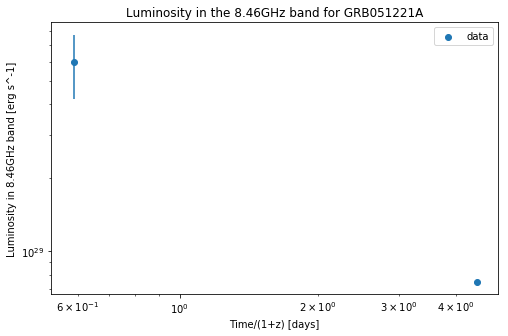

[2.0573659137014796e+29]
[2.8574526579187214e+29]
[0.851808634772462]
0.714
1.365909096393905e+28


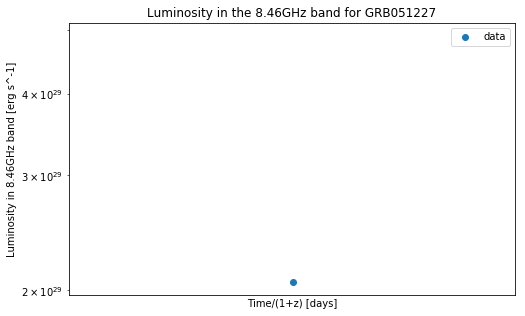

060116
[80.0, 89.2, 117.0, 363.0, 85.0]
[23.0, 19.8, 27.0, 28.0, 26.0]
[4.85, 6.95, 10.87, 14.95, 17.72]
[2.8597056849428613e+31, 3.1885718387112907e+31, 4.182319564228934e+31, 1.2975914545428233e+32, 3.03843729025179e+31]
[8.221653844210726e+30, 7.077771570233581e+30, 9.651506686682157e+30, 1.0008969897300014e+31, 9.294043476064299e+30]
[0.638157894736842, 0.9144736842105263, 1.430263157894737, 1.9671052631578947, 2.331578947368421]
6.6
2.0616731044601584e+29


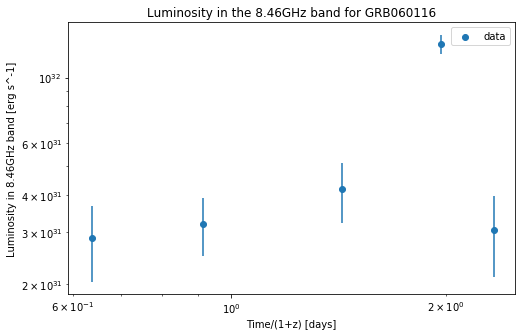

060218
[453.0, 381.0, 269.0, 280.0, 164.0, 30.0, 39.0, 15.0, 75.0, 48.0, 87.0, 20.0, 32.0, 15.0, 22.0, 25.0]
[77.0, 60.0, 40.0, 47.0, 39.0, 30.0, 25.0, 15.0, 13.0, 14.0, 39.0, 20.0, 20.0, 18.0, 22.0, 22.0]
[1.87, 3.0, 3.83, 4.85, 6.97, 7.94, 9.95, 12.88, 16.74, 19.86, 21.96, 24.91, 30.71, 34.81, 41.74, 50.7]
[1.11953140267967e+28, 9.41592636690848e+27, 6.647990007082365e+27, 6.919840899565288e+27, 4.0530496697453826e+27, 7.414115249534238e+26, 9.638349824394508e+26, 3.707057624767119e+26, 1.8535288123835594e+27, 1.1862584399254778e+27, 2.1500934223649285e+27, 4.942743499689492e+26, 7.908389599503186e+26, 3.707057624767119e+26, 5.437017849658441e+26, 6.178429374611864e+26]
[1.902956247380454e+27, 1.4828230499068476e+27, 9.885486999378985e+26, 1.1615447224270304e+27, 9.638349824394508e+26, 7.414115249534238e+26, 6.178429374611864e+26, 3.707057624767119e+26, 3.21278327479817e+26, 3.4599204497826444e+26, 9.638349824394508e+26, 4.942743499689492e+26, 4.942743499689492e+26, 4.448469149720542

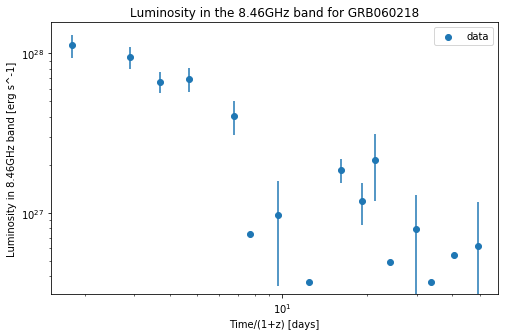

060418
[216.0, 21.0, 36.0, 4.0, 111.0, 42.0]
[48.0, 67.0, 45.0, 34.0, 47.0, 34.0]
[4.3, 7.29, 16.02, 18.07, 23.04, 68.29]
[9.39092592109822e+30, 9.130066867734378e+29, 1.5651543201830363e+30, 1.7390603557589293e+29, 4.825892487231029e+30, 1.8260133735468757e+30]
[2.0868724269107148e+30, 2.9129260958962063e+30, 1.9564429002287954e+30, 1.4782013023950897e+30, 2.0433959180167416e+30, 1.4782013023950897e+30]
[1.726838279587165, 2.9275932693466125, 6.433476567206136, 7.256736677241878, 9.252640456206578, 27.424601421629657]
1.4901
3.4171726778745034e+28


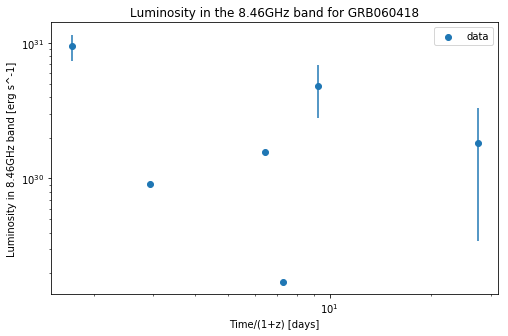

060522
[38.0, 16.0, 25.0, 28.0, 21.0]
[17.0, 29.0, 26.0, 24.0, 28.0]
[9.66, 15.52, 16.6, 26.68, 33.45]
[9.984270596295439e+30, 4.2039034089665003e+30, 6.568599076510157e+30, 7.356830965691375e+30, 5.517623224268532e+30]
[4.466647372026906e+30, 7.619574928751782e+30, 6.831343039570562e+30, 6.30585511344975e+30, 7.356830965691375e+30]
[1.5810147299509, 2.5400981996726677, 2.716857610474632, 4.366612111292962, 5.474631751227496]
5.11
1.5282306817255938e+29


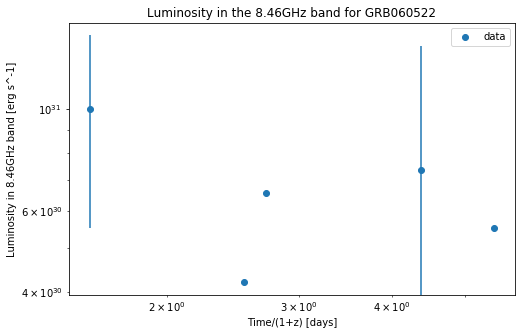

[1.0147345047507525e+31]
[5.073672523753763e+30]
[24.756832605159932]
2.1357
5.339360897403412e+28


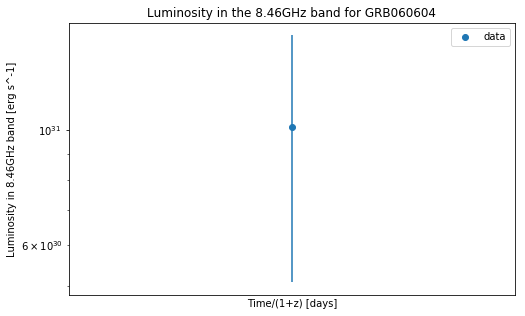

[1.6702678648169725e+31]
[8.351339324084862e+30]
[15.85376073748167]
3.773
1.0659867999565726e+29


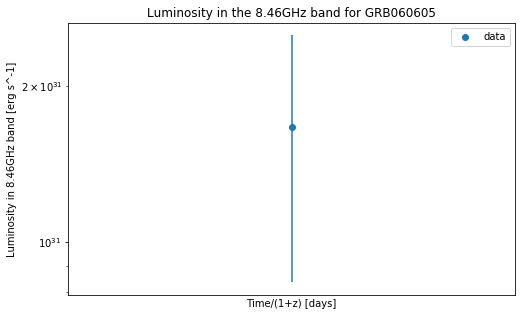

[1.2776911883142396e+31]
[6.388455941571198e+30]
[9.828248587570622]
3.425
9.49095559865337e+28


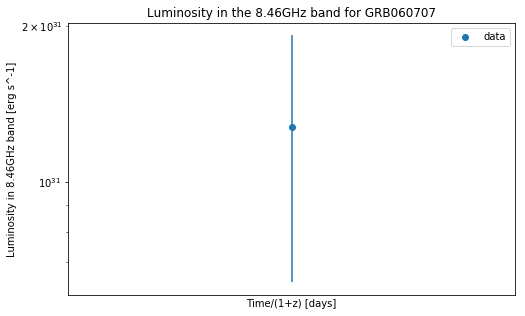

[2.8189209200662236e+30]
[9.396403066887416e+29]
[0.23000375516334962]
1.1304
2.420003349446897e+28


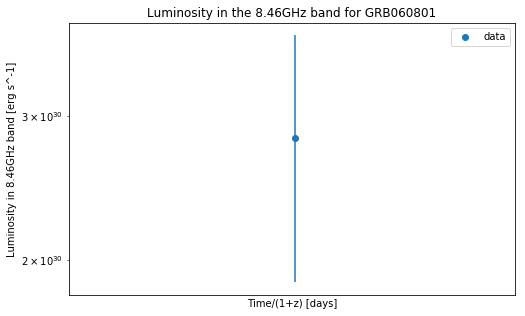

[3.2642756228328554e+30]
[1.6641405136010634e+30]
[0.32944929948675267]
1.8836
4.572215961145301e+28


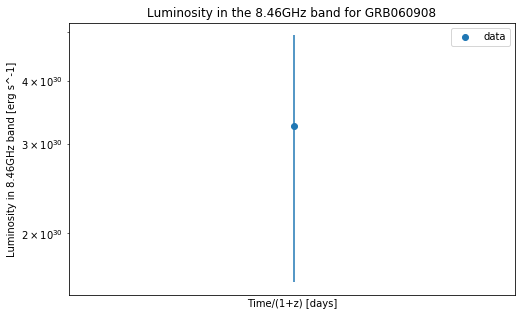

[1.2378703348316604e+30]
[6.094130879171251e+29]
[0.90899700444169]
0.9362
1.9123884460892165e+28


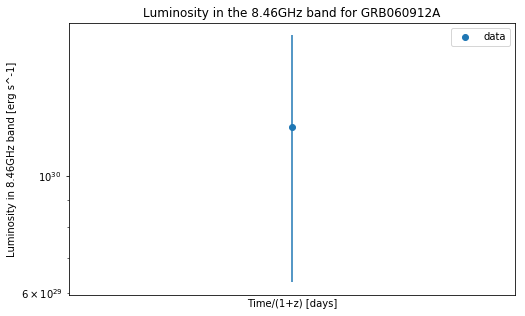

[1.6260762903160142e+30]
[8.130381451580071e+29]
[0.913978494623656]
0.86
1.7204451165118524e+28


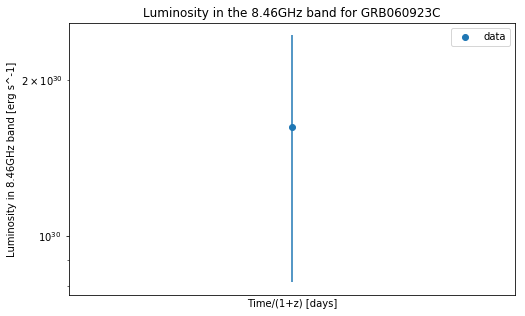

[1.309480970962304e+31, 1.3379479485919192e+31]
[8.255423512588439e+30, 7.970753736292287e+30]
[1.0478543933849735, 1.2830870123081308]
3.2086
8.772886636432453e+28


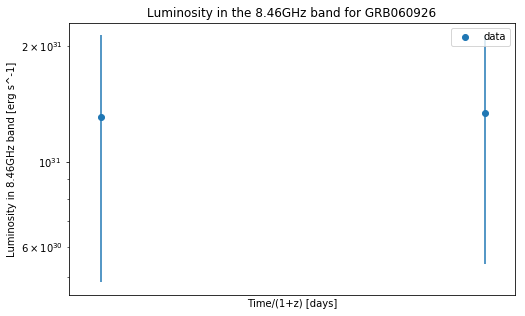

[1.0301325038404626e+30]
[5.150662519202313e+29]
[1.875]
0.76
1.4756104825012618e+28


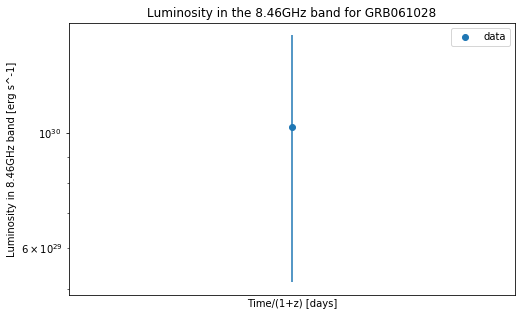

061121
[304.0, 96.0, 54.0, 35.0]
[48.0, 78.0, 25.0, 23.0]
[0.74, 3.72, 4.9, 6.77]
[1.0655169699845255e+31, 3.364790431530081e+30, 1.8926946177356708e+30, 1.2267465114953419e+30]
[1.6823952157650406e+30, 2.733892225618191e+30, 8.762475082109585e+29, 8.06147707554082e+29]
[0.31972348239360554, 1.607258587167855, 2.1170879239576585, 2.9250378051414994]
1.3145
2.922199878657607e+28


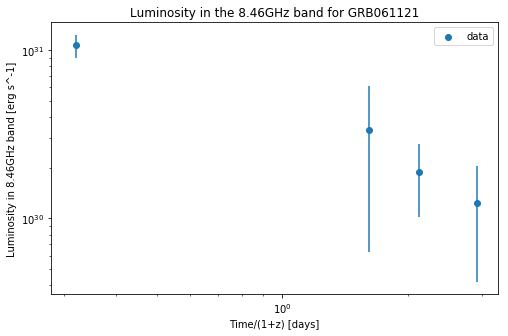

[2.8065029552333965e+29]
[1.0103410638840228e+30]
[5.989438576987214]
1.1588
2.496238590425835e+28


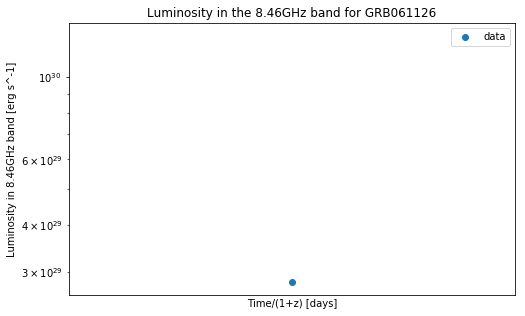

[2.6132828828089794e+29]
[1.3066414414044897e+29]
[1.3479957431713374]
0.4095
6.952012489722715e+27


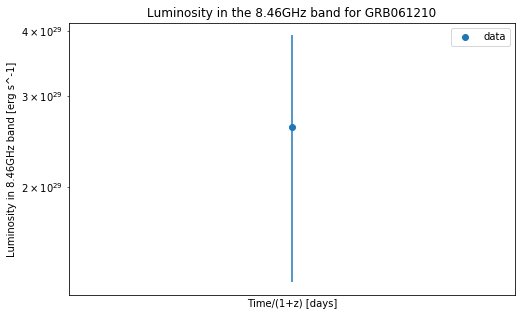

[2.147602767230352e+31]
[5.124104848128559e+30]
[0.27525906735751293]
2.088
5.1927945845227165e+28


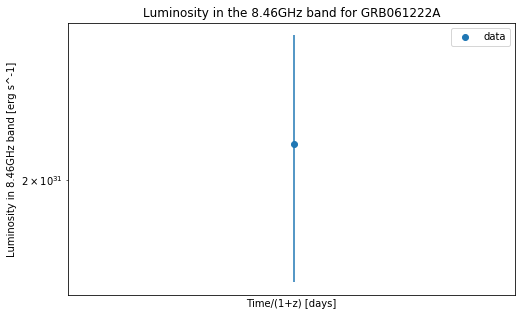

070125
[360.0, 454.0, 382.0, 563.0, 482.0, 489.0, 405.0, 559.0, 399.0, 385.0, 596.0, 660.0, 581.0, 303.0, 414.0, 443.0, 473.0, 345.0, 403.0, 267.0, 145.0, 166.0, 148.0, 111.0, 64.0]
[42.0, 38.0, 52.0, 62.0, 52.0, 43.0, 20.0, 26.0, 69.0, 42.0, 109.0, 39.0, 14.0, 63.0, 66.0, 59.0, 44.0, 48.0, 56.0, 42.0, 33.0, 46.0, 60.0, 19.0, 18.0]
[4.01, 4.93, 5.8, 7.75, 10.72, 11.93, 12.81, 13.93, 14.94, 16.77, 17.85, 18.86, 19.87, 23.87, 34.97, 48.91, 54.95, 66.81, 86.87, 109.72, 160.45, 198.41, 252.21, 297.08, 341.96]
[1.6674577268233197e+31, 2.1028494666049642e+31, 1.7693579212403003e+31, 2.6077186116709143e+31, 2.232540623135667e+31, 2.2649634122683424e+31, 1.8758899426762349e+31, 2.5891913035950988e+31, 1.8480989805625127e+31, 1.7832534022971613e+31, 2.7605689032963843e+31, 3.0570058325094196e+31, 2.6910914980120796e+31, 1.403443586742961e+31, 1.9175763858468175e+31, 2.0518993693964742e+31, 2.190854179965084e+31, 1.5979803215390146e+31, 1.866626288638327e+31, 1.2366978140606288e+31, 6.7161491774

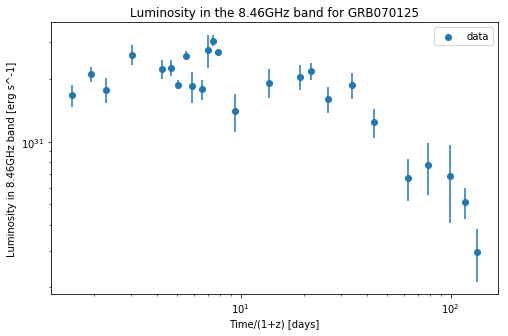

[7.1140036462166815e+28]
[1.7785009115541704e+30]
[0.27861010355884985]
0.9023
1.826451394731214e+28


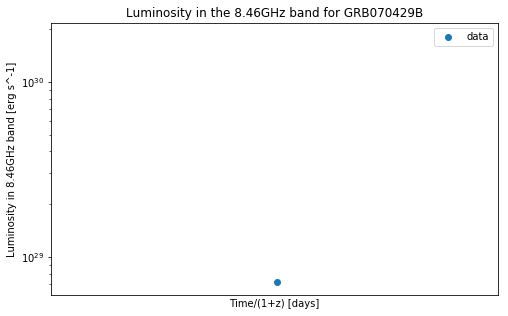

070612A
[588.0, 589.0, 609.0, 528.0, 626.0, 870.0, 803.0, 775.0, 883.0, 984.0, 1230.0, 714.0, 779.0, 645.0, 541.0, 513.0, 190.0, 174.0, 101.0, 68.0]
[47.0, 54.0, 54.0, 65.0, 45.0, 48.0, 61.0, 24.0, 35.0, 61.0, 42.0, 42.0, 40.0, 41.0, 45.0, 43.0, 37.0, 43.0, 39.0, 49.0]
[3.89, 5.82, 30.89, 37.87, 38.85, 40.64, 52.79, 53.64, 54.77, 70.53, 74.66, 75.64, 133.16, 140.33, 146.34, 154.42, 317.02, 368.65, 488.54, 814.59]
[5.964444142905053e+30, 5.974587755392986e+30, 6.177460005151661e+30, 5.355827393629027e+30, 6.349901417446535e+30, 8.824942864502376e+30, 8.145320827810812e+30, 7.861299678148667e+30, 8.956809826845513e+30, 9.981314688126823e+30, 1.247664336015853e+31, 7.242539316384709e+30, 7.901874128100402e+30, 6.542630054717278e+30, 5.487694355972166e+30, 5.203673206310021e+30, 1.9272863727074154e+30, 1.7649885729004745e+30, 1.0245048612813102e+30, 6.897656491794959e+29]
[4.767497869328869e+29, 5.4775507434842334e+29, 5.4775507434842334e+29, 6.593348117156945e+29, 4.564625619570194e+29, 4

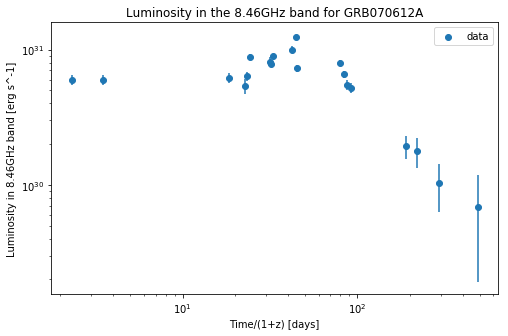

071003
[393.0, 430.0, 431.0, 332.0, 260.0, 109.0]
[55.0, 50.0, 51.0, 67.0, 42.0, 45.0]
[1.76, 3.82, 8.72, 11.3, 21.66, 32.68]
[1.934583128278886e+31, 2.1167194533331323e+31, 2.121642056712977e+31, 1.634304322108372e+31, 1.2798768787595681e+31, 5.365637684030497e+30]
[2.707431858914471e+30, 2.4613016899222464e+30, 2.510527723720692e+30, 3.29814426449581e+30, 2.0674934195346875e+30, 2.2151715209300222e+30]
[0.6757924242133353, 1.46677673891758, 3.348244283602434, 4.3388945418242555, 8.31685449344366, 12.548236604143067]
1.60435
3.7464970073061132e+28


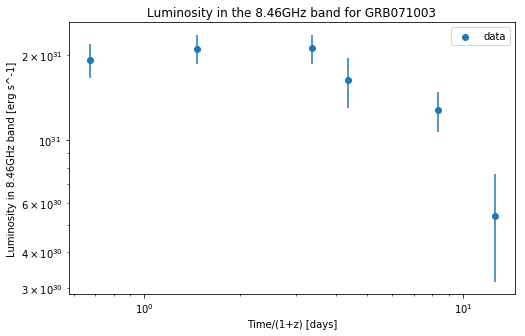

071010B
[276.0, 330.0, 280.0, 116.0, 136.0, 17.0]
[49.0, 52.0, 40.0, 46.0, 40.0, 47.0]
[2.9, 3.79, 4.75, 12.62, 19.53, 25.62]
[5.368787836798827e+30, 6.419202848346422e+30, 5.446596356172721e+30, 2.2564470618429845e+30, 2.645489658712465e+30, 3.3068620733905815e+29]
[9.531543623302263e+29, 1.0115107518606485e+30, 7.780851937389604e+29, 8.947979727998042e+29, 7.780851937389604e+29, 9.142501026432782e+29]
[1.4894709809964046, 1.9465844889573702, 2.4396507447354905, 6.481766820749871, 10.030816640986133, 13.158705701078583]
0.947
1.9399443968306914e+28


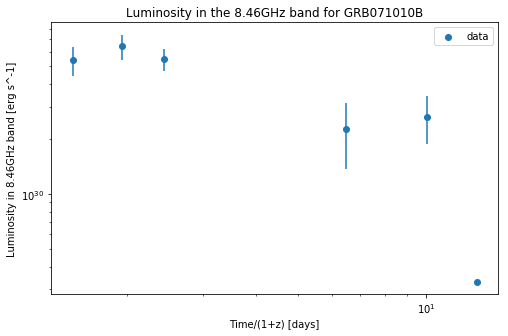

071020
[186.0, 141.0, 13.0]
[26.0, 40.0, 36.0]
[2.18, 3.15, 56.96]
[1.4629600244310527e+31, 1.1090180830364434e+31, 1.0224989418066499e+30]
[2.0449978836132998e+30, 3.146150590174307e+30, 2.831535531156877e+30]
[0.692899370669379, 1.0012078062424512, 18.104379886847628]
2.1462
5.371707749117656e+28


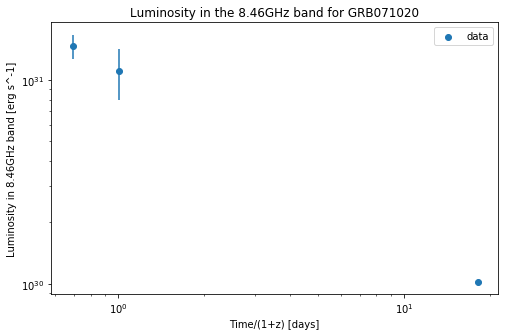

071021
[149.0, 17.0, 46.0]
[44.0, 35.0, 42.0]
[1.86, 2.88, 14.63]
[1.4362972345403987e+31, 1.6387283884017972e+30, 4.434206227440157e+30]
[4.241414652334063e+30, 3.373852564356641e+30, 4.048623077227969e+30]
[0.5388180764774044, 0.8342989571263035, 4.238122827346466]
2.452
6.326127693616553e+28


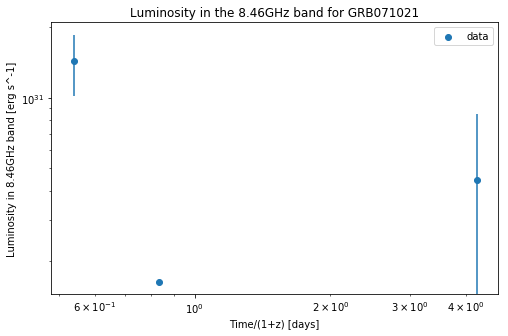

[6.950430658921812e+30, 4.279284758630292e+30]
[1.2265465868685552e+30, 1.5536256767001695e+30]
[1.3457943925233646, 11.08411214953271]
1.14
2.445719713435679e+28


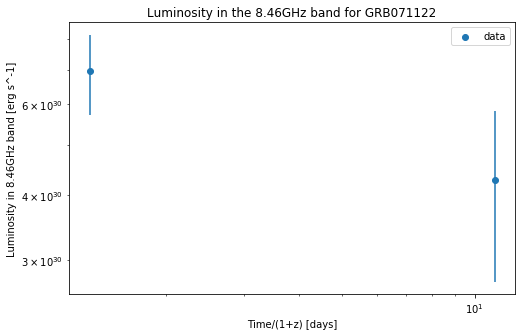

[4.426103434076025e+30, 1.5262425634744914e+29]
[8.012773458241082e+29, 1.049291762388713e+30]
[1.187341902844458, 3.7788446647049714]
0.9371
1.914681535026004e+28


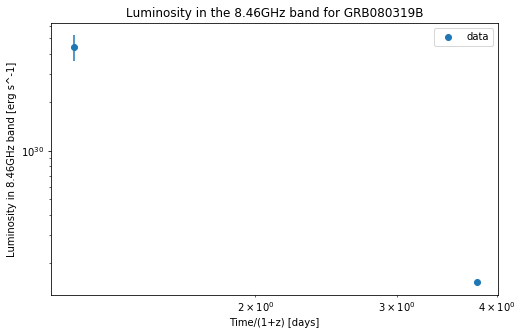

[2.2035021547433124e+30]
[9.223962508227817e+29]
[0.5805653373941182]
1.1014
2.3426553531543717e+28


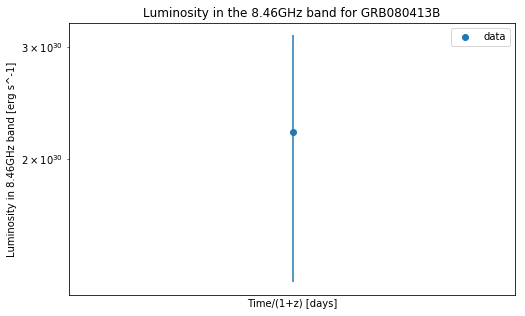

[8.712340250673005e+29]
[5.893641934278797e+29]
[0.19340159271899887]
0.758
1.470801077783982e+28


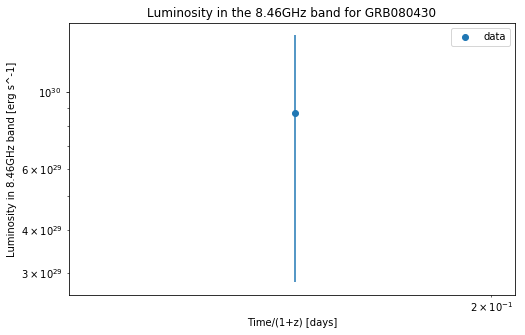

080603A
[116.0, 154.0, 230.0]
[41.0, 28.0, 29.0]
[1.92, 3.95, 4.79]
[6.208575014480433e+30, 8.242418553706783e+30, 1.231010563215948e+31]
[2.1944101344284288e+30, 1.498621555219415e+30, 1.5521437536201082e+30]
[0.7144398716985064, 1.4698111943797398, 1.7823786382478364]
1.68742
3.989199320347847e+28


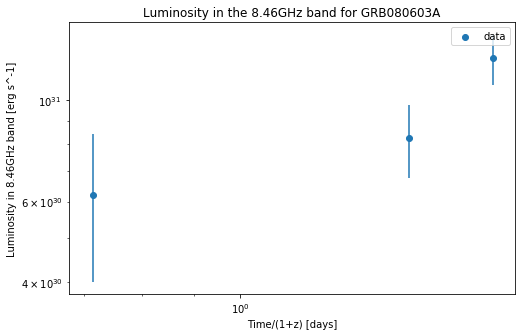

[1.2160257504882305e+30]
[4.5324596154561313e+30]
[0.3632125335429486]
2.6893
7.081622288378623e+28


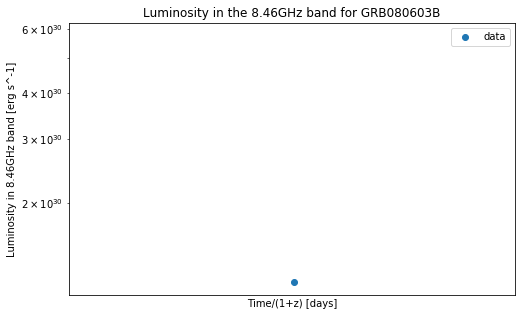

[9.734731666680501e+30]
[5.024377634415742e+30]
[0.757364815949212]
2.5914
6.768484494778908e+28


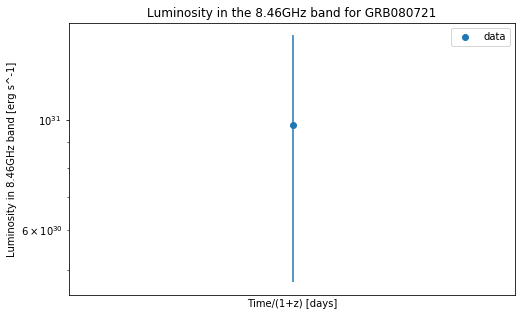

[2.283066157808694e+31]
[7.559821714598322e+30]
[0.6458226079282195]
3.35104
9.244736983838312e+28


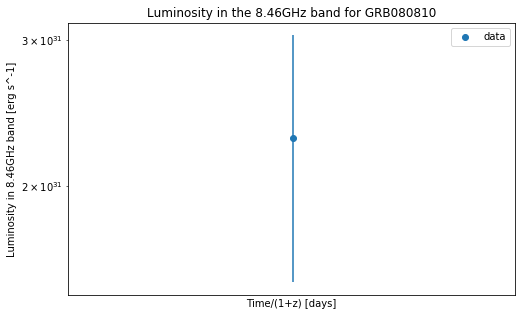

[4.061091184134631e+31]
[1.8659067602780738e+31]
[1.5750678908573645]
6.733
2.1100218656576673e+29


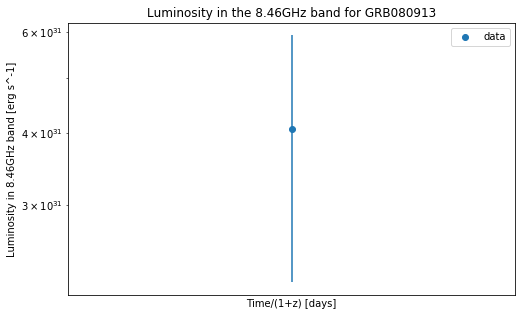

[5.564385540185087e+30]
[3.9536423574999307e+30]
[0.239344262295082]
2.05
5.07648886708923e+28


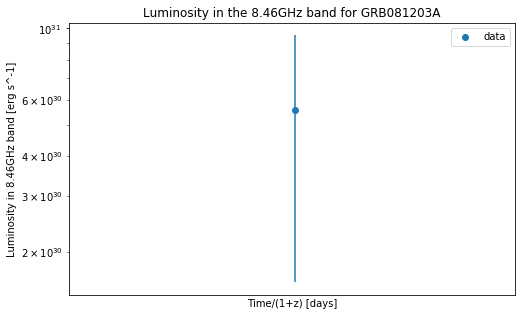

081203B
[160.0, 162.0, 39.0, 66.0]
[41.0, 44.0, 40.0, 43.0]
[2.12, 6.96, 10.04, 14.09]
081221
[97.0, 167.0, 108.0]
[38.0, 27.0, 27.0]
[5.46, 6.45, 14.36]
[8.262567932603725e+30, 1.4225245822111567e+31, 9.19956017238353e+30]
[3.236882282875686e+30, 2.2998900430958824e+30, 2.2998900430958824e+30]
[1.6748466257668713, 1.9785276073619633, 4.404907975460123]
2.26
5.724160324523736e+28


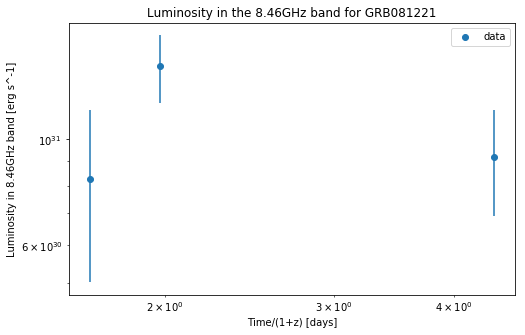

[6.236061764742095e+30]
[6.120579139469094e+30]
[0.25722619994696366]
2.771
7.344424099622485e+28


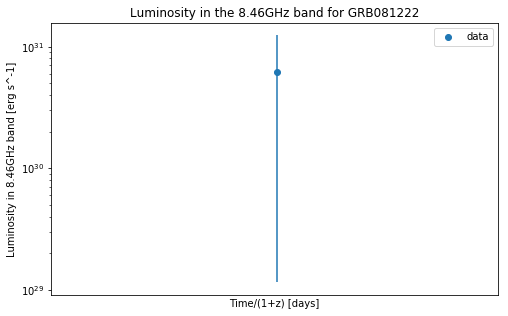

[4.219314223825731e+30]
[2.2719384282138554e+30]
[0.5612244897959183]
1.548
3.5833969725929415e+28


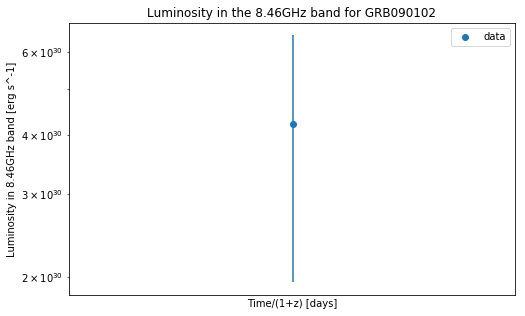

[4.9017525062275437e+30]
[1.0970588942509264e+31]
[0.27255189989912043]
4.6503
1.3672316872508836e+29


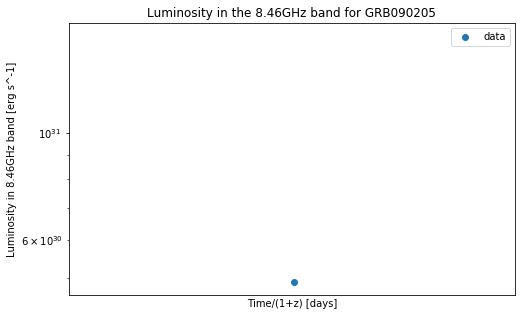

090313
[269.0, 339.0, 576.0, 418.0, 443.0, 265.0, 305.0, 296.0, 353.0, 265.0]
[31.0, 39.0, 44.0, 41.0, 61.0, 41.0, 52.0, 37.0, 37.0, 41.0]
[5.85, 7.01, 7.87, 8.9, 9.88, 10.88, 11.73, 12.93, 18.83, 28.06]
[4.105055455914578e+31, 5.173285500204618e+31, 8.790007221586608e+31, 6.378859407331948e+31, 6.760370137435534e+31, 4.0440137390980056e+31, 4.654430907263743e+31, 4.517087044426451e+31, 5.3869315090626255e+31, 4.0440137390980056e+31]
[4.730733053284459e+30, 5.951567389615933e+30, 6.714588849823103e+30, 6.2567759736988e+30, 9.308861814527483e+30, 6.2567759736988e+30, 7.935423186154576e+30, 5.646358805533063e+30, 5.646358805533063e+30, 6.2567759736988e+30]
[1.337570879824401, 1.6027986098408633, 1.7994329614047926, 2.0349368940918238, 2.2590085970367664, 2.4876531918785445, 2.6820010974940556, 2.956374611304189, 4.305377720870679, 6.415767331260289]
3.3736
9.31975472403152e+28


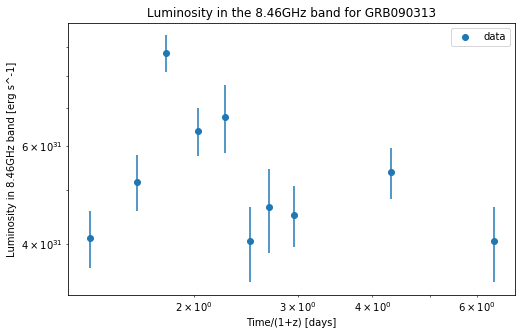

090323
[27.0, 225.0, 100.0, 157.0, 219.0, 281.0, 164.0, 166.0, 183.0, 123.0, 312.0, 43.0, 127.0, 295.0, 178.0, 167.0, 78.0, 77.0, 61.0]
[38.0, 35.0, 40.0, 31.0, 39.0, 38.0, 35.0, 27.0, 35.0, 29.0, 27.0, 27.0, 30.0, 27.0, 56.0, 33.0, 32.0, 31.0, 29.0]
[3.38, 4.38, 5.43, 6.16, 7.18, 8.32, 9.3, 11.29, 12.41, 13.14, 14.28, 15.42, 17.44, 18.42, 22.09, 25.04, 33.46, 41.41, 49.35]
[4.464970885120643e+30, 3.7208090709338684e+31, 1.6536929204150528e+31, 2.596297885051633e+31, 3.6215874957089657e+31, 4.646877106366297e+31, 2.7120563894806866e+31, 2.745130247888988e+31, 3.026258044359547e+31, 2.034042292110515e+31, 5.159521911694965e+31, 7.110879557784728e+30, 2.100190008927117e+31, 4.878394115224406e+31, 2.943573398338794e+31, 2.7616671770931385e+31, 1.2898804779237413e+31, 1.2733435487195908e+31, 1.0087526814531824e+31]
[6.284033097577201e+30, 5.787925221452686e+30, 6.614771681660212e+30, 5.126448053286664e+30, 6.449402389618706e+30, 6.284033097577201e+30, 5.787925221452686e+30, 4.4649708851206

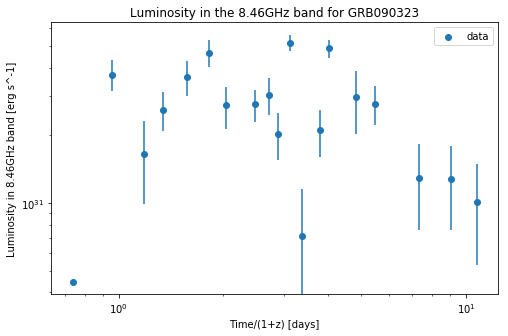

090328
[172.0, 337.0, 783.0, 195.0, 674.0, 214.0, 523.0, 809.0, 603.0, 643.0, 886.0, 410.0, 78.0, 21.0]
[57.0, 60.0, 57.0, 34.0, 155.0, 41.0, 57.0, 39.0, 67.0, 59.0, 58.0, 59.0, 43.0, 64.0]
[1.62, 2.59, 3.62, 5.63, 6.61, 7.69, 8.62, 9.57, 13.74, 16.6, 19.59, 27.57, 42.56, 44.46]
[2.0801618714710348e+30, 4.075665992358947e+30, 9.469574100940818e+30, 2.3583230519584408e+30, 8.151331984717893e+30, 2.5881083749697757e+30, 6.32514336499623e+30, 9.784017174535276e+30, 7.29266051451764e+30, 7.776419089278347e+30, 1.0715252430949635e+31, 4.958525391297235e+30, 9.433292207833765e+29, 2.539732517493706e+29]
[6.893559690340058e+29, 7.256378621410587e+29, 6.893559690340058e+29, 4.111947885465999e+29, 1.874564477197735e+30, 4.958525391297235e+29, 6.893559690340058e+29, 4.7166461039168825e+29, 8.102956127241821e+29, 7.13543897772041e+29, 7.014499334030235e+29, 7.13543897772041e+29, 5.200404678677587e+29, 7.740137196171293e+29]
[0.9335023625677078, 1.4924513080557795, 2.0859744151204334, 3.2442088279

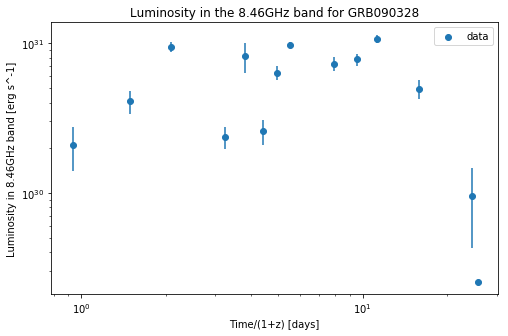

[1.0821411937500617e+31]
[2.1741649554795758e+30]
[0.3834355828220859]
1.608
3.757105296352664e+28


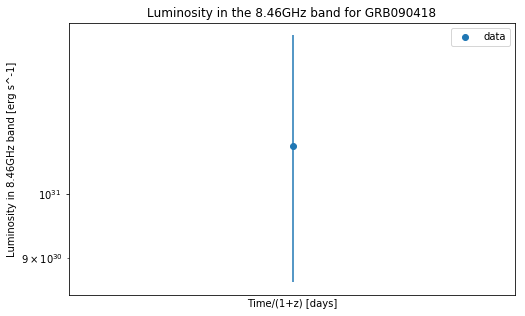

090423
[100.0, 31.9, 63.4, 67.9, 65.5, 92.4, 24.9, 32.9, 64.9, 23.2, 52.4, 29.9, 50.7, 50.1, 24.9]
[49.8, 39.3, 21.7, 18.7, 21.7, 22.7, 19.3, 19.1, 19.1, 19.3, 23.2, 14.9, 18.1, 19.0, 20.6]
[1.67, 2.75, 7.7, 9.71, 10.67, 12.7, 14.76, 15.76, 16.75, 19.69, 20.76, 21.71, 26.81, 33.79, 63.75]
[4.59555090614023e+31, 1.4659807390587335e+31, 2.913579274492906e+31, 3.1203790652692167e+31, 3.0100858435218514e+31, 4.246289037273574e+31, 1.1442921756289174e+31, 1.5119362481201357e+31, 2.982512538085009e+31, 1.0661678102245333e+31, 2.4080686748174807e+31, 1.374069720935929e+31, 2.329944309413097e+31, 2.3023710039762553e+31, 1.1442921756289174e+31]
[2.2885843512578348e+31, 1.8060515061131106e+31, 9.9723454663243e+30, 8.59368019448223e+30, 9.9723454663243e+30, 1.043190055693832e+31, 8.869413248850644e+30, 8.777502230727839e+30, 8.777502230727839e+30, 8.869413248850644e+30, 1.0661678102245333e+31, 6.847370850148943e+30, 8.317947140113818e+30, 8.731546721666438e+30, 9.466834866648873e+30]
[0.180931744

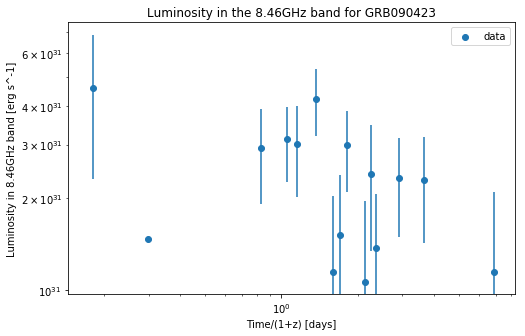

090424
[673.0, 186.0, 214.0, 309.0]
[39.0, 50.0, 40.0, 35.0]
[1.5, 2.8, 4.52, 5.71]
[4.5461028391160985e+30, 1.2564266390424881e+30, 1.4455661330918945e+30, 2.087289416473811e+30]
[2.6344429528310235e+29, 3.377490965167978e+29, 2.7019927721343834e+29, 2.3642436756175847e+29]
[0.9711880867594691, 1.8128844286176755, 2.926513434768533, 3.6969893169310457]
0.5445
9.796383366175594e+27


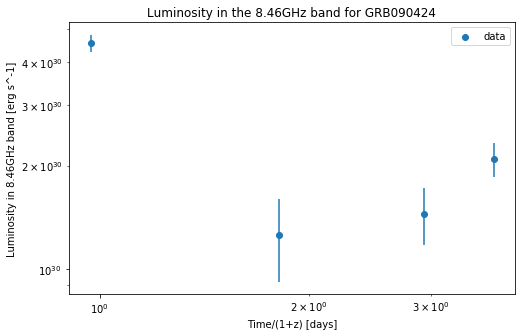

[2.9235132959780075e+31]
[1.9667271263852047e+31]
[0.10096153846153846]
9.4
3.0987638873435913e+29


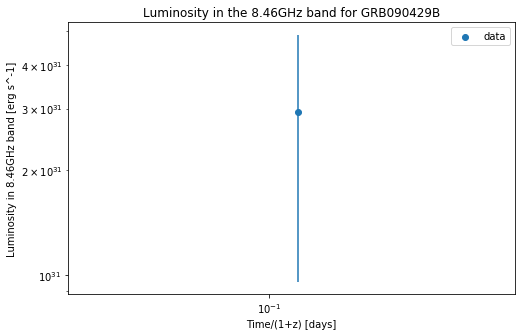

090618
[389.0, 551.0, 165.0, 20.0]
[51.0, 51.0, 51.0, 44.0]
[0.98, 1.69, 5.03, 9.0]
[2.585226139071057e+30, 3.661849878221472e+30, 1.0965612158013484e+30, 1.3291651100622405e+29]
[3.389371030658713e+29, 3.389371030658713e+29, 3.389371030658713e+29, 2.924163242136929e+29]
[0.6363636363636364, 1.0974025974025974, 3.2662337662337664, 5.844155844155844]
0.54
9.698026140912202e+27


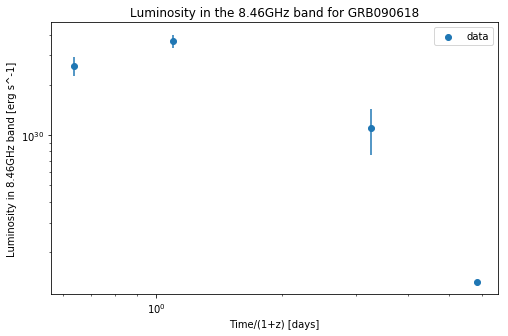

090715B
[209.0, 71.0, 196.0, 257.0, 41.0, 36.0]
[41.0, 48.0, 58.0, 57.0, 100.0, 41.0]
[4.2, 6.11, 7.25, 9.19, 12.1, 16.27]
[2.7223172152385425e+31, 9.248063267078304e+30, 2.552986479362461e+31, 3.3475383938579214e+31, 5.34043090070719e+30, 4.6891588396453366e+30]
[5.34043090070719e+30, 6.252211786193783e+30, 7.554755908317486e+30, 7.424501496105117e+30, 1.3025441221237043e+31, 5.34043090070719e+30]
[1.046598554697234, 1.5225517069524048, 1.8066284575130824, 2.2900573137303764, 3.015200598056317, 4.054323448791428]
3.013
8.130253047349521e+28


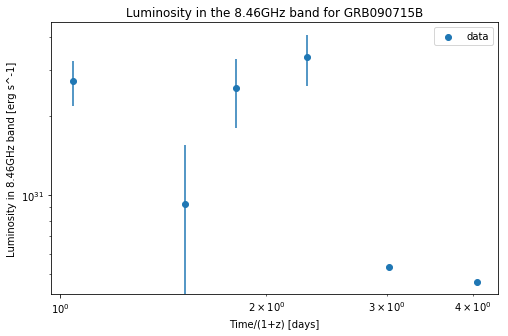

[9.074326042266561e+29]
[4.423733945604949e+30]
[0.43884765029194067]
2.73706
7.23509066945176e+28


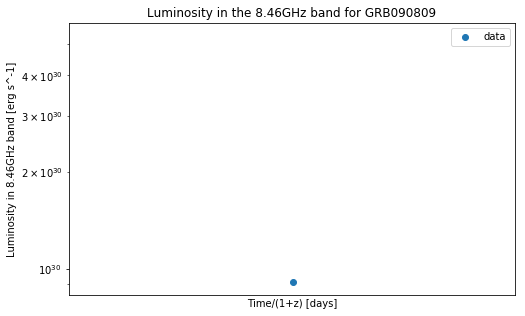

090812
[104.0, 62.0, 58.0]
[43.0, 62.0, 59.0]
[1.12, 3.16, 7.2]
[1.0025775547250742e+31, 5.976904653168712e+30, 5.591297901351375e+30]
[4.145272582036364e+30, 5.976904653168712e+30, 5.687699589305709e+30]
[0.3244401958228325, 0.9153848382144202, 2.08568697314678]
2.4521
6.326443478626009e+28


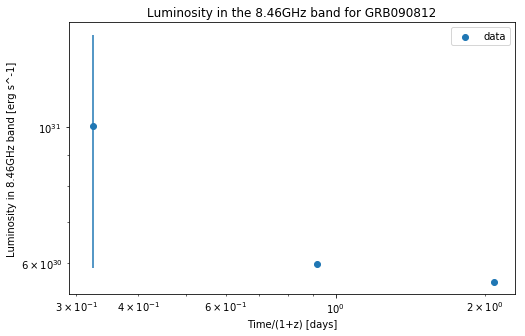

090902B
[141.0, 13.0, 130.0, 10.0, 80.0, 99.0, 71.0, 52.0, 89.0, 26.0, 67.0, 38.0, 66.0, 21.0, 8.6, 21.8, 48.3, 30.9, 18.0]
[39.0, 31.0, 34.0, 32.0, 32.0, 31.0, 33.0, 32.0, 36.0, 29.0, 29.0, 28.0, 27.0, 31.0, 19.9, 19.2, 19.4, 21.0, 16.0]
[1.48, 4.59, 5.59, 7.69, 8.59, 10.64, 11.6, 15.5, 16.46, 22.51, 24.5, 34.43, 36.43, 39.23, 65.44, 66.31, 67.54, 73.42, 199.16]
[8.560806156679523e+30, 7.892941846583956e+29, 7.892941846583956e+30, 6.071493728141505e+29, 4.857194982513204e+30, 6.01077879086009e+30, 4.3107605469804685e+30, 3.1571767386335824e+30, 5.40362941804594e+30, 1.5785883693167912e+30, 4.0679007978548075e+30, 2.3071676166937718e+30, 4.0071858605733924e+30, 1.2750136829097159e+30, 5.221484606201695e+29, 1.323585632734848e+30, 2.9325314706923466e+30, 1.876091561995725e+30, 1.0928688710654709e+30]
[2.3678825539751872e+30, 1.8821630557238668e+30, 2.0643078675681113e+30, 1.9428779930052816e+30, 1.9428779930052816e+30, 1.8821630557238668e+30, 2.0035929302866962e+30, 1.9428779930052816e+

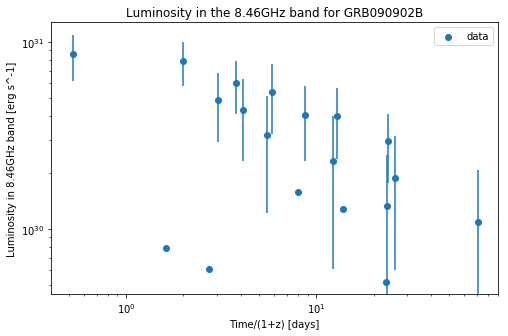

091020
[101.0, 62.0, 121.0, 119.0, 253.0, 451.0, 429.0, 267.0, 348.0, 348.0, 325.0, 253.0, 330.0, 232.0, 119.0, 189.0, 151.0, 115.0, 85.0, 112.0]
[44.0, 46.0, 45.0, 60.0, 42.0, 44.0, 41.0, 40.0, 50.0, 45.0, 42.0, 39.0, 40.0, 39.0, 46.0, 29.0, 33.0, 31.0, 31.0, 43.0]
[0.76, 1.64, 1.87, 2.09, 3.76, 5.81, 6.73, 8.76, 9.58, 10.82, 13.73, 14.66, 16.76, 19.63, 20.63, 22.63, 30.59, 37.57, 58.72, 64.6]
[5.525261586577024e+30, 3.3917447363146086e+30, 6.619372791839802e+30, 6.509961671313523e+30, 1.384050674657413e+31, 2.4672207678675625e+31, 2.346868535288657e+31, 1.4606384590258072e+31, 1.9037534971572316e+31, 1.9037534971572316e+31, 1.777930708552013e+31, 1.384050674657413e+31, 1.8052834886835823e+31, 1.2691689981048215e+31, 6.509961671313523e+30, 1.0339350889733241e+31, 8.260539599733966e+30, 6.291139430260968e+30, 4.6499726223668027e+30, 6.127022749471552e+30]
[2.4070446515781094e+30, 2.5164557721043868e+30, 2.4617502118412484e+30, 3.282333615788331e+30, 2.297633531051832e+30, 2.40704465157

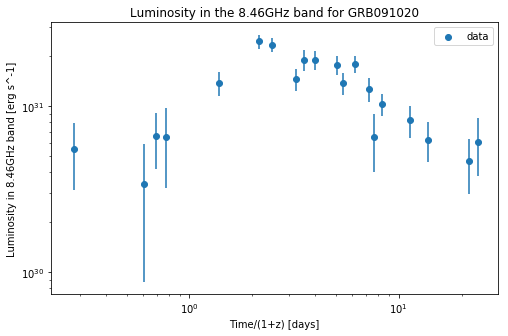

100414A
[415.0, 396.0, 169.0, 179.0, 156.0, 193.0, 117.0, 65.0, 119.0, 135.0, 20.0]
[15.0, 15.0, 19.0, 22.0, 21.0, 20.0, 21.0, 24.0, 22.0, 23.0, 16.0]
[5.04, 13.08, 17.1, 19.18, 22.11, 26.06, 28.16, 30.01, 35.01, 35.97, 64.11]
[1.5587428336508237e+31, 1.4873787039174126e+31, 6.347651539445523e+30, 6.723252222252952e+30, 5.859370651795868e+30, 7.24909317818335e+30, 4.3945279888469015e+30, 2.4414044382482782e+30, 4.469648125408386e+30, 5.07060921790027e+30, 7.51201365614855e+29]
[5.634010242111412e+29, 5.634010242111412e+29, 7.136412973341122e+29, 8.263215021763404e+29, 7.887614338955975e+29, 7.51201365614855e+29, 7.887614338955975e+29, 9.014416387378257e+29, 8.263215021763404e+29, 8.638815704570831e+29, 6.0096109249188384e+29]
[2.128378378378378, 5.523648648648648, 7.221283783783783, 8.099662162162161, 9.336993243243242, 11.005067567567565, 11.89189189189189, 12.673141891891891, 14.784628378378375, 15.19003378378378, 27.073479729729726]
1.368
3.0714684119333275e+28


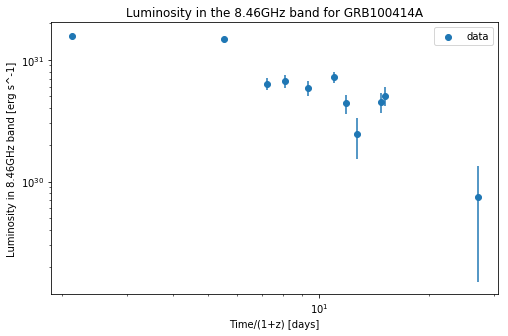

100418A
[458.0, 289.0, 516.0, 537.0, 847.0, 1028.0, 1454.0, 923.0, 526.0, 641.0, 366.0]
[20.0, 22.0, 22.0, 20.0, 23.0, 37.0, 21.0, 32.0, 41.0, 37.0, 53.0]
[2.53, 5.42, 11.6, 17.46, 25.64, 32.5, 47.58, 57.57, 79.28, 94.24, 156.24]
[4.035557933135963e+30, 2.5464546783325174e+30, 4.5466111211750145e+30, 4.7316476202926026e+30, 7.463138797742708e+30, 9.05797719489906e+30, 1.281157474842727e+31, 8.132794699311121e+30, 4.634723739802437e+30, 5.648018854017798e+30, 3.2249218417636737e+30]
[1.7622523725484554e+29, 1.9384776098033007e+29, 1.9384776098033007e+29, 1.7622523725484554e+29, 2.0265902284307233e+29, 3.260166889214642e+29, 1.850364991175878e+29, 2.819603796077528e+29, 3.612617363724333e+29, 3.260166889214642e+29, 4.669968787253407e+29]
[1.557977707986945, 3.3376439435925858, 7.143297001046863, 10.751893589506745, 15.789149578175998, 20.013547632243366, 29.299833733604288, 35.4516903750231, 48.820740193361665, 58.033130118849684, 96.21282098651396]
0.6239
1.156876439971379e+28


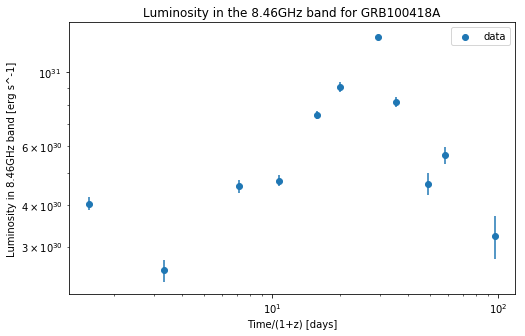

100906A
[107.0, 26.0, 215.0, 98.6]
[33.0, 30.0, 28.0, 25.0]
[0.85, 1.66, 4.97, 38.87]
[5.949274610465059e+30, 1.4456181296457154e+30, 1.1954149918224185e+31, 5.482228753194904e+30]
[1.834823010704177e+30, 1.668020918821979e+30, 1.5568195242338472e+30, 1.3900174323516495e+30]
[0.3116978364503116, 0.6087275394206086, 1.8225155848918222, 14.25375870920425]
1.727
4.105744744949214e+28


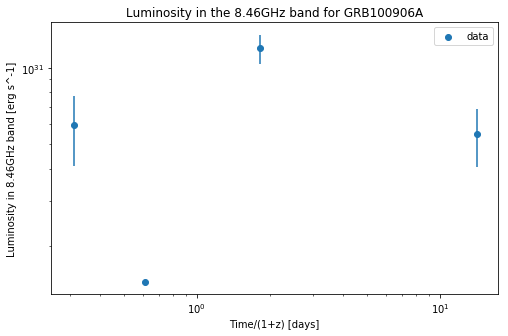

[4.9238537351305884e+29]
[1.040250789112096e+29]
[11.818152527628316]
0.55185
9.957530051903662e+27


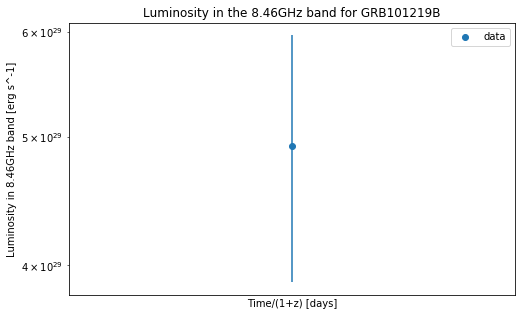

In [99]:
"""
ALL FLUX AND LUMINOSITY CURVES (8GHz)
"""

# first GRB in the radio data with a redshift
first_GRB =  GRB_sample[0]

# empty arrays to store data
time_ind = []
flux_ind = []
flux_err_ind = []

# loop through rows in data for 8.46GHz
for row in data_freq_8:
    
    # get name of GRB for that row
    GRB = row[0]
    
    # if GRB matches previous, add it to the array
    if re.match(GRB, first_GRB):

        # Adds data to array for that GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        
        time_ind.append(t)
        flux_ind.append(f)
        flux_err_ind.append(f_err)
                
    # when it stops matching, store data for that GRB and reset
    else:
        
        if len(flux_ind) >= 3:

            """
            # plot scatter graph of the individual flux curves
            f = plt.figure()
            f.set_figwidth(8) 
            f.set_figheight(5)
            plt.title(f'Flux in the 8GHz band for GRB{first_GRB}')
            plt.scatter(time_ind, flux_ind, label=flux)
            plt.errorbar(time_ind, flux_ind, yerr = flux_err_ind, fmt = ' ')
            plt.xscale("log")
            plt.xlabel("Time [days]")
            plt.yscale("log")
            plt.ylabel(r'Flux in 8.5GHz band [$\mu$Jy]')
            plt.legend()
            plt.show()
            """
        
            print(first_GRB)
            print(flux_ind)
            print(flux_err_ind)
            print(time_ind)
        
        # identify redshift and luminosity distance for that GRB
        for j in GRB_z_d_l:

            x = j[0]

            if re.match(first_GRB, x):

                z = j[1]
                d_l = j[2]

                # call on luminosity function to plot lum curves
                lum = L(flux_ind, d_l, z, beta)
                lum_err = L_err(flux_err_ind, d_l, z, beta)
                time_rest = T_rest(time_ind, z)

                print(lum)
                print(lum_err)
                print(time_rest)
                print(z)
                print(d_l)

                # defining min and max values for plotting of T_s line
                #ymin_T_s = 0.5*min(lum)
                #ymax_T_s = 2*max(lum)


                # plot scatter graph of the individual luminosity curves
                f = plt.figure()
                f.set_figwidth(8) 
                f.set_figheight(5)
                plt.title(f'Luminosity in the 8.46GHz band for GRB{first_GRB}')
                plt.scatter(time_rest, lum, label='data')
                plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
                plt.xscale("log")
                plt.xlabel("Time/(1+z) [days]")
                plt.yscale("log")
                plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
                #plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='black', linestyles='solid', label='T_s')
                plt.legend()
                plt.show()
            
            else:
                continue
        
        # reset arrays
        time_ind = []
        flux_ind = []
        flux_err_ind = []
        
        # store first data point for next GRB
        t = float(row[1])
        f = float(row[2])
        f_err = float(row[3])
        time_ind.append(t)
        flux_ind.append(f)
        flux_err_ind.append(f_err)
        
        # move to next GRB
        first_GRB = GRB
        
        continue

In [100]:
"""
SELECTION CRITERIA
"""

data_cut = []
GRB_dot_plot = []

# loop through measured fluxes to find those with more than three points past T_s with error
for burst in data_dot:
    name = burst[0]
    lum = burst[1]
    lum_err = burst[2]
    time_rest = burst[3]
    
    # more than three points in lightcurve
    if len(lum) >= 3:
        
        # not one of the GRB to be excluded
        if name in GRB_keep:
            
            # 3 or more points after T_s with error
            if time_rest[-3] > T_s:
                
                GRB_dot_plot.append(name)
                
                
                
# loop through all data to keep the upper limits and apply other conditions
for burst in data_all:
    name = burst[0]
    lum = burst[1]
    lum_err = burst[2]
    time_rest = burst[3]
        
    # require three or more points for GRB minimum
    if name in GRB_dot_plot:
        
        # only loop through if more than three points after T_s
        if time_rest[-3] > T_s:
            
            # removes lightcurves where less than three of the points have an error
            test_list = list(zip(lum, lum_err))
            x = 0
            for y in test_list:
                if y[0] > y[1]:
                    x+=1

            if x >= 3:
                
                data_cut.append([name, lum, lum_err, time_rest])

            else:
                continue
                            
print(f'The number of GRB that fulfill the criteria is {len(data_cut)}.')


The number of GRB that fulfill the criteria is 16.


The number of points in GRB970508 is 71.


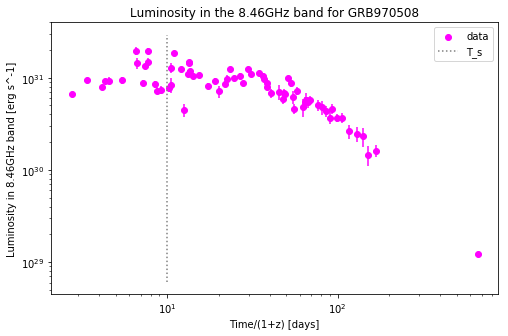

The number of points in GRB980703 is 33.


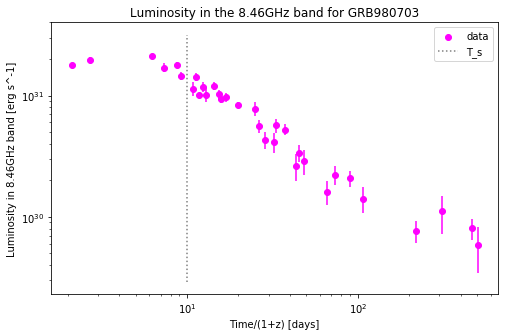

The number of points in GRB991216 is 16.


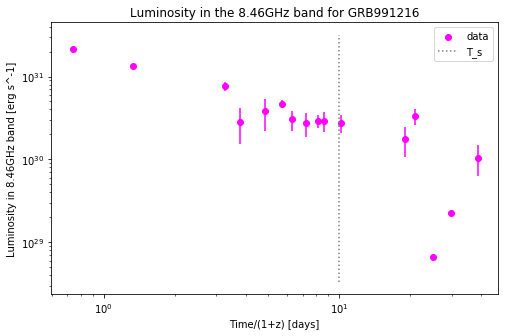

The number of points in GRB000210 is 16.


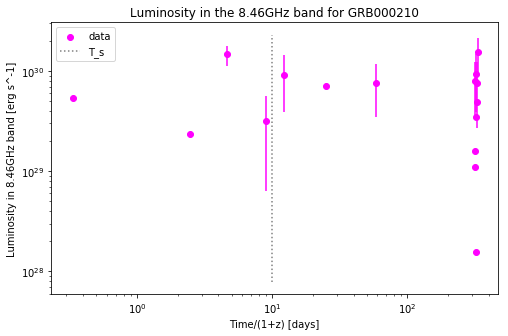

The number of points in GRB000301C is 32.


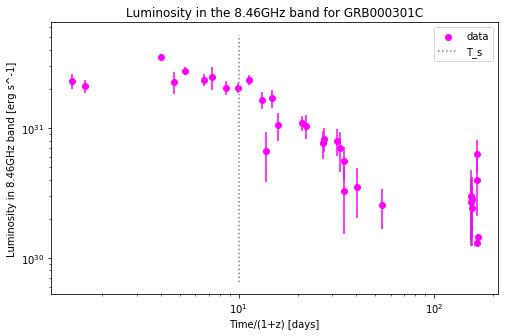

The number of points in GRB000418 is 35.


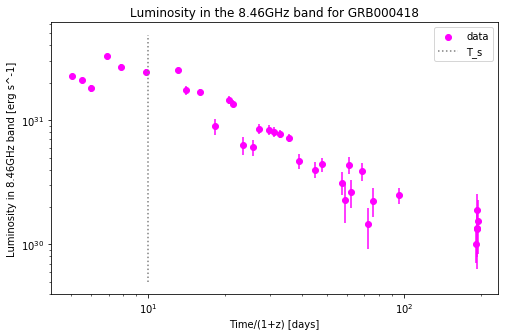

The number of points in GRB000926 is 21.


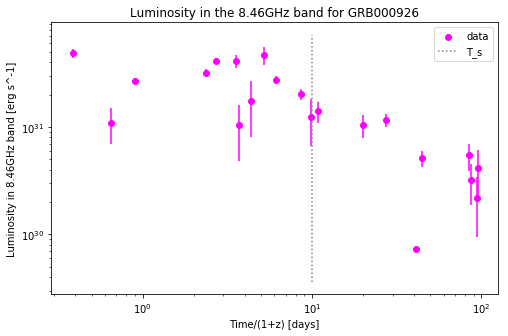

The number of points in GRB010222 is 25.


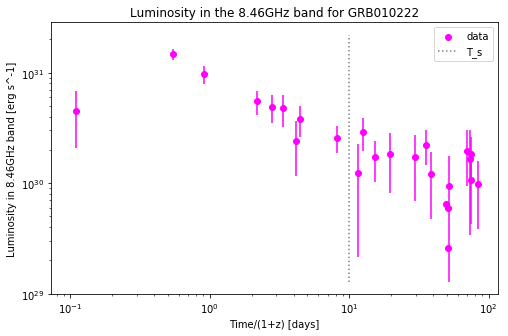

The number of points in GRB010921 is 18.


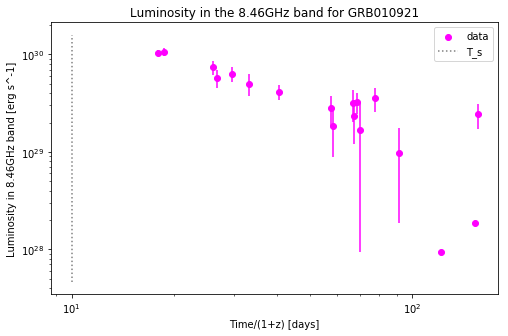

The number of points in GRB020813 is 12.


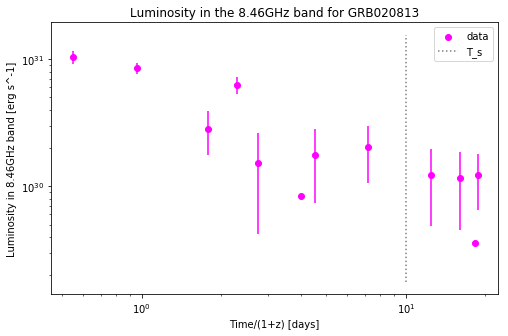

The number of points in GRB021004 is 28.


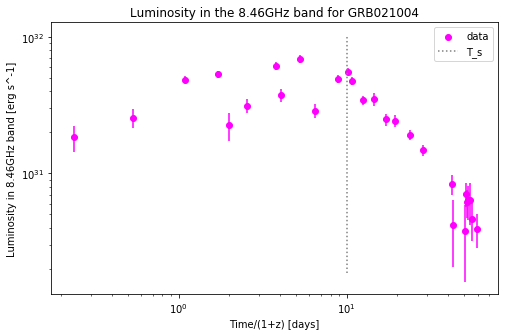

The number of points in GRB070125 is 25.


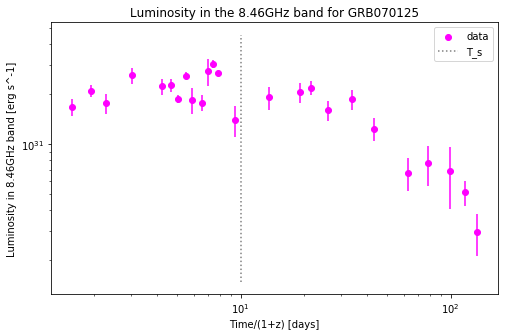

The number of points in GRB070612A is 20.


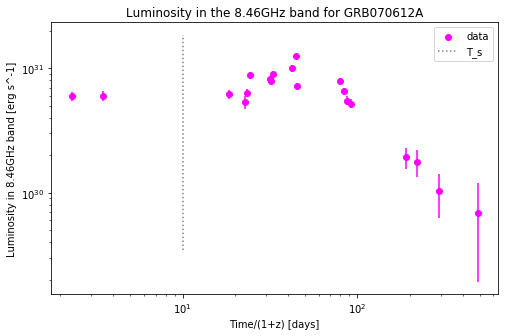

The number of points in GRB090902B is 19.


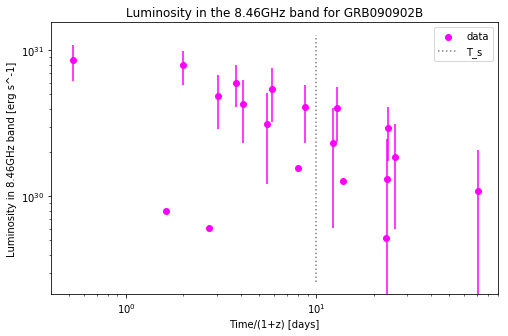

The number of points in GRB091020 is 20.


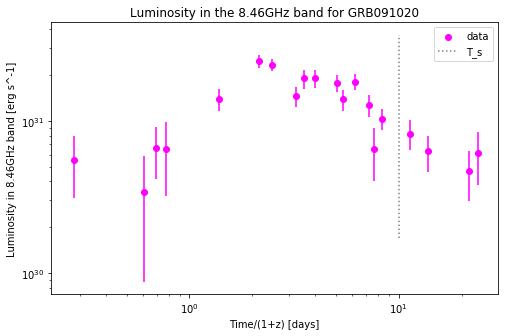

The number of points in GRB100414A is 11.


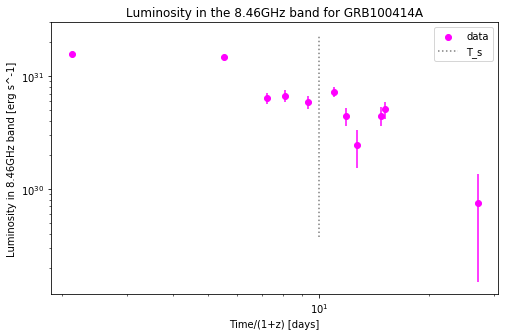

The number of analysable GRBs is 16


In [105]:
"""
LUMINOSITY LIGHT CURVES THAT FILL CRITERIA
"""

# empty list to store names of plottable GRBs
GRB_plot = []

for burst in data_cut:
    name = burst[0]
    lum = burst[1]
    lum_err = burst[2]
    time_rest = burst[3]
    
    print(f'The number of points in GRB{name} is {len(lum)}.')
    
    ymin_T_s = min(lum) - 0.5*min(lum)
    ymax_T_s = max(lum) + 0.5*max(lum)

    # plot scatter graph of the individual luminosity curves
    f = plt.figure()
    f.set_figwidth(8) 
    f.set_figheight(5)
    plt.title(f'Luminosity in the 8.46GHz band for GRB{name}')
    plt.scatter(time_rest, lum, label='data', c='magenta')
    plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ', c='magenta')
    plt.xscale("log")
    plt.xlabel("Time/(1+z) [days]")
    plt.yscale("log")
    plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
    plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='T_s')
    plt.legend()
    plt.show()

    # adds GRB to list if luminosity curve is plot
    GRB_plot.append(name)

print(f'The number of analysable GRBs is {len(GRB_plot)}')

The average length of a plottbale GRB is 188.26088994570432 days.
The average number of points of a plottbale GRB is 25.0.


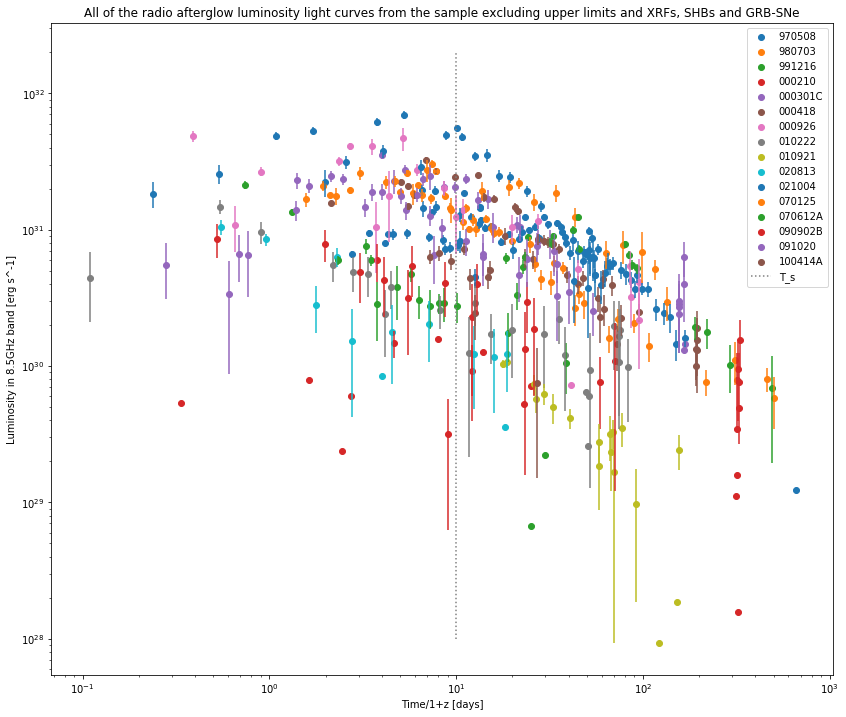

The plottable GRBs are: ['970508', '980703', '991216', '000210', '000301C', '000418', '000926', '010222', '010921', '020813', '021004', '070125', '070612A', '090902B', '091020', '100414A'].
The number of plottable GRBs is 16.


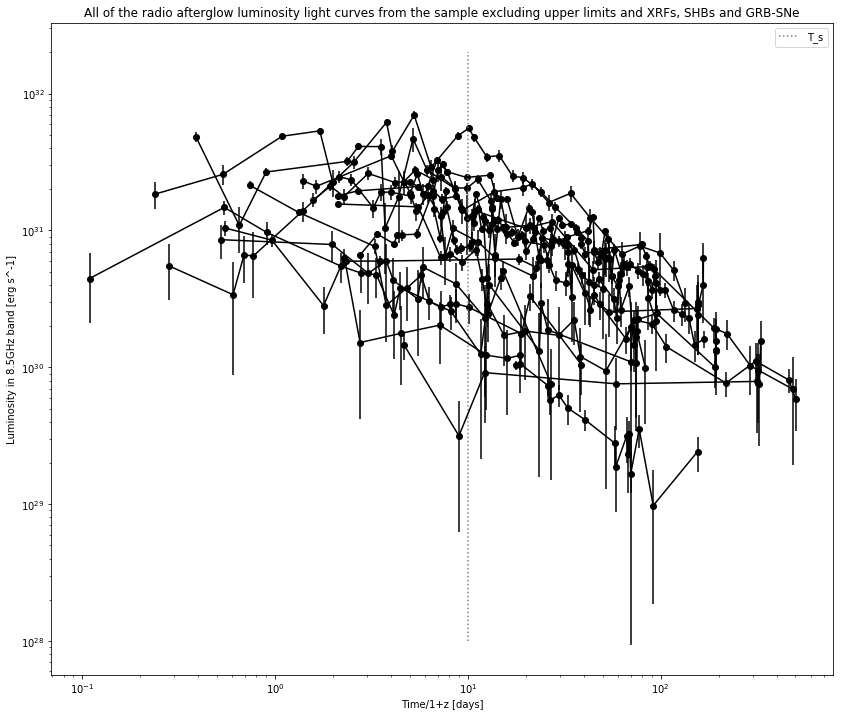

In [106]:
"""
PLOT OF ALL PLOTTABLE GRBS
"""

duration = []
no_points = []

for burst in data_cut:
    name = burst[0]
    lum = burst[1]
    lum_err = burst[2]
    time = burst[3]
    
    start = time[0]
    end = time[-1]
    length = end - start
    
    no_points.append(len(time))
    duration.append(length)
    
print(f'The average length of a plottbale GRB is {sum(duration)/len(duration)} days.')
print(f'The average number of points of a plottbale GRB is {round(sum(no_points)/len(no_points), 0)}.')

    
plottable_GRBs = []

# plot scatter graph of all data points in same colour excluding upper limits and GRB with SNe connection
plt.figure(figsize = (14,12))
plt.title('All of the radio afterglow luminosity light curves from the sample excluding upper limits and XRFs, SHBs and GRB-SNe')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")        
for gammarayburst in data_cut:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]

    plt.scatter(time, lum, label = f'{name}')
    plt.errorbar(time, lum, lum_err, fmt = ' ')
    #plt.plot(time, lum)
    plottable_GRBs.append(name)
    
plt.vlines(x=T_s, ymin=1e28, ymax=2e32, colors='grey', linestyles=':', label='T_s')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()

print(f'The plottable GRBs are: {plottable_GRBs}.')
print(f'The number of plottable GRBs is {len(plottable_GRBs)}.')

# plot scatter graph of only measured fluxes of GRBs
plt.figure(figsize = (14,12))
plt.title('All of the radio afterglow luminosity light curves from the sample excluding upper limits and XRFs, SHBs and GRB-SNe')
plt.xscale("log")
plt.xlabel("Time/1+z [days]")
plt.yscale("log")
plt.ylabel("Luminosity in 8.5GHz band [erg s^-1]")        
for gammarayburst in data_dot:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]
    
    if name in GRB_plot:

        plt.scatter(time, lum, c = "black")
        plt.errorbar(time, lum, lum_err, fmt = ' ', c = "black")
        plt.plot(time, lum, c = "black")
    
plt.vlines(x=T_s, ymin=1e28, ymax=2e32, colors='grey', linestyles=':', label='T_s')
plt.legend(bbox_to_anchor = (1 , 1))
plt.show()

The decay index of GRB970508 is -0.552.


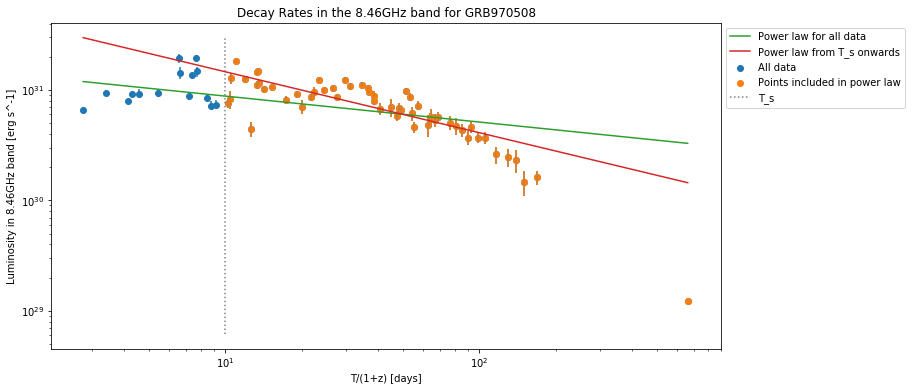

The decay index of GRB980703 is -0.864.


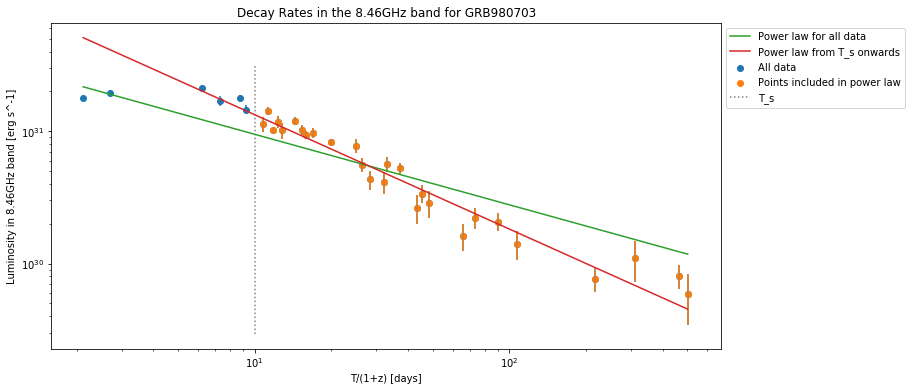

The decay index of GRB991216 is -0.992.


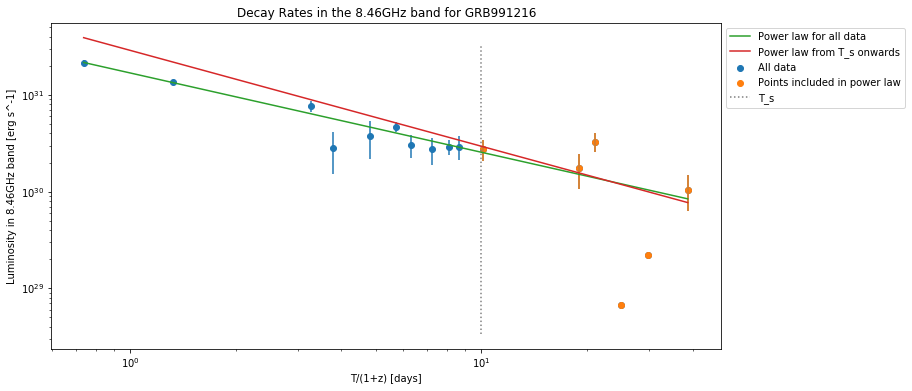

The decay index of GRB000210 is -0.198.


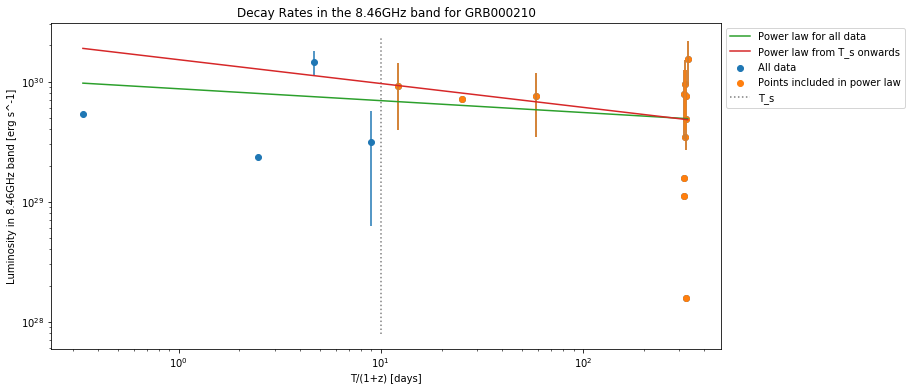

The decay index of GRB000301C is -1.056.


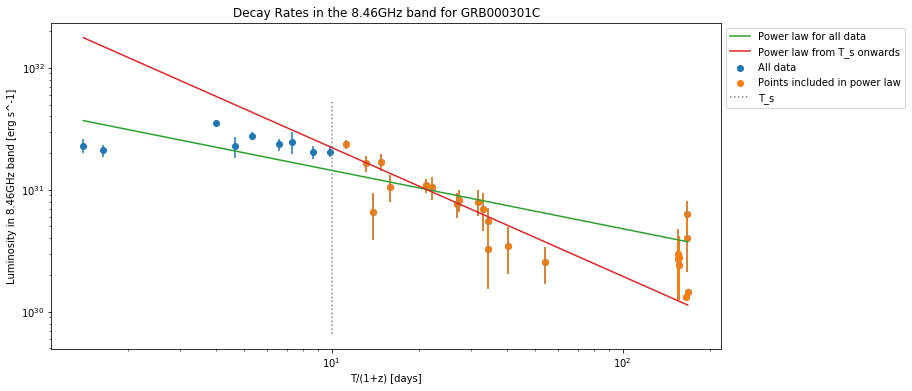

The decay index of GRB000418 is -1.267.


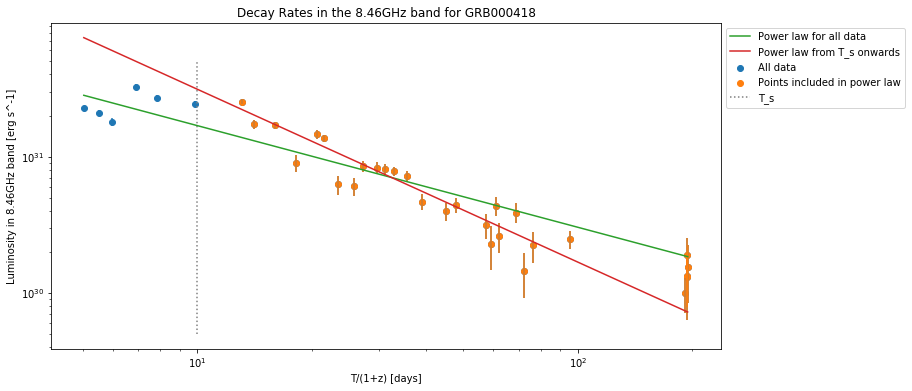

The decay index of GRB000926 is -0.732.


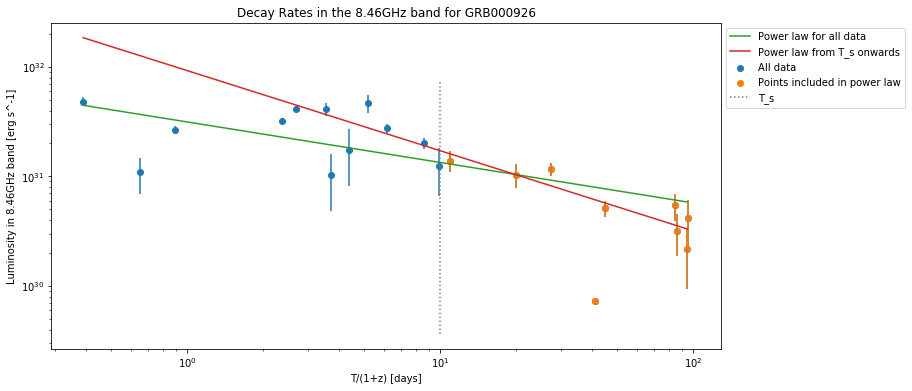

The decay index of GRB010222 is -0.446.


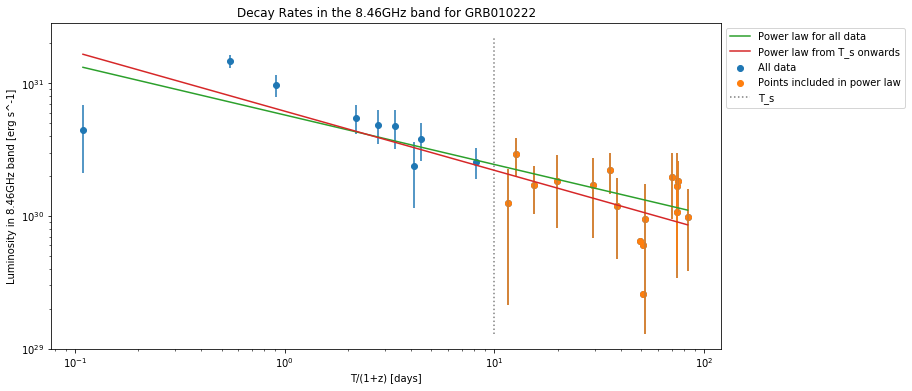

The decay index of GRB010921 is -1.105.


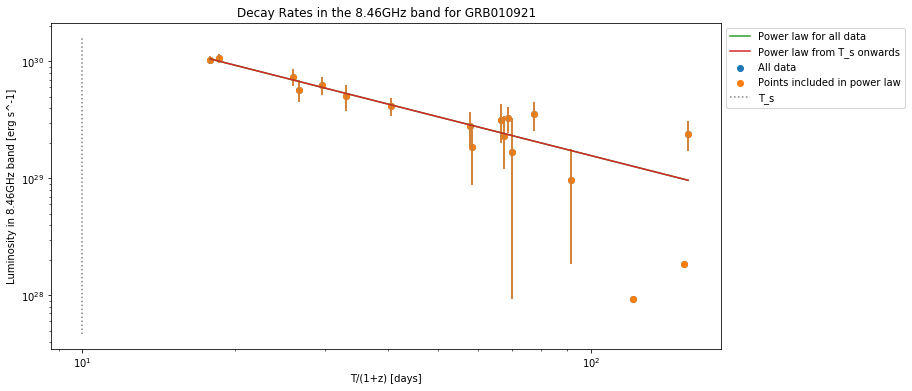

/Applications/anaconda3/lib/python3.6/site-packages/lmfit/confidence.py:310: UserWarning: maxiter=200 reached and prob(pow_amplitude=1.3026538565718438e+33) = 0.5022649679462258 < max(sigmas).
  warn(errmsg)


The decay index of GRB020813 is -1.275.


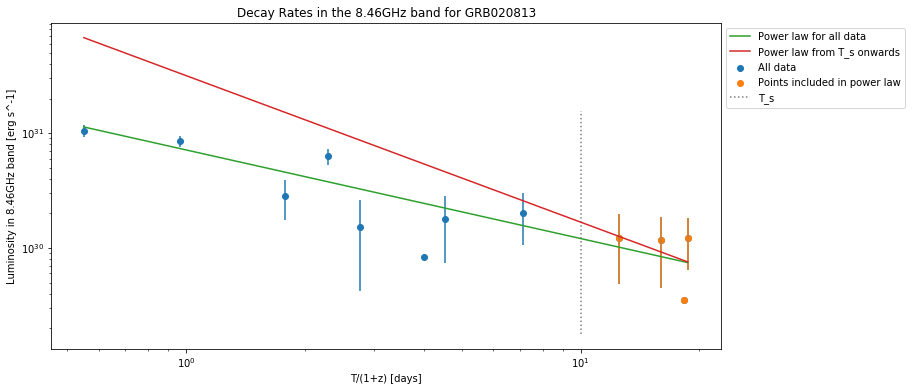

The decay index of GRB021004 is -1.323.


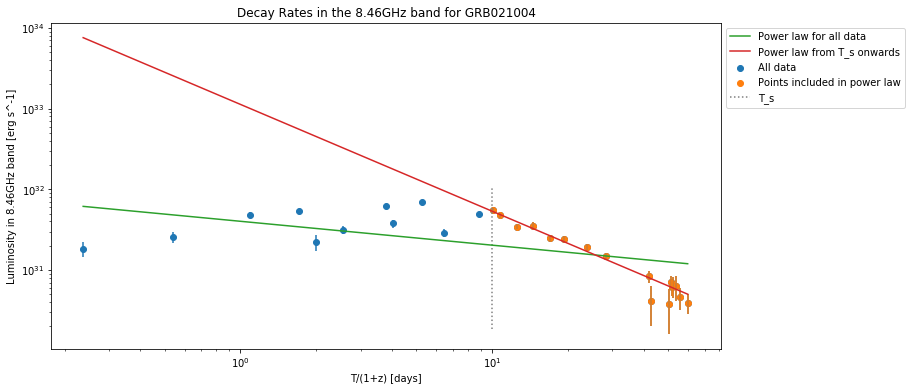

The decay index of GRB070125 is -0.781.


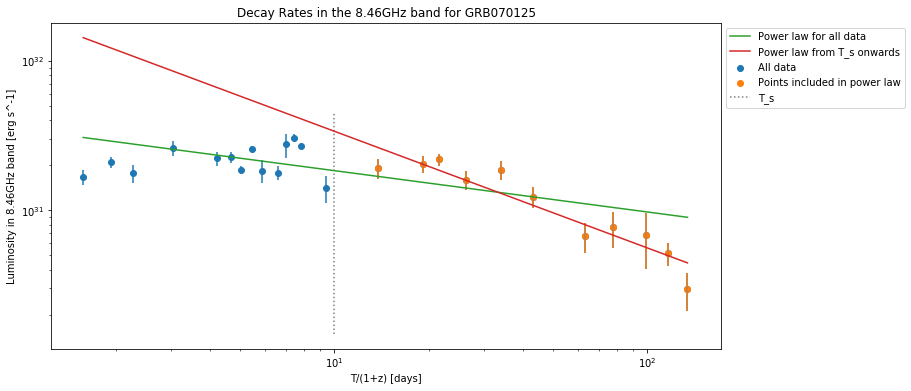

The decay index of GRB070612A is -0.396.


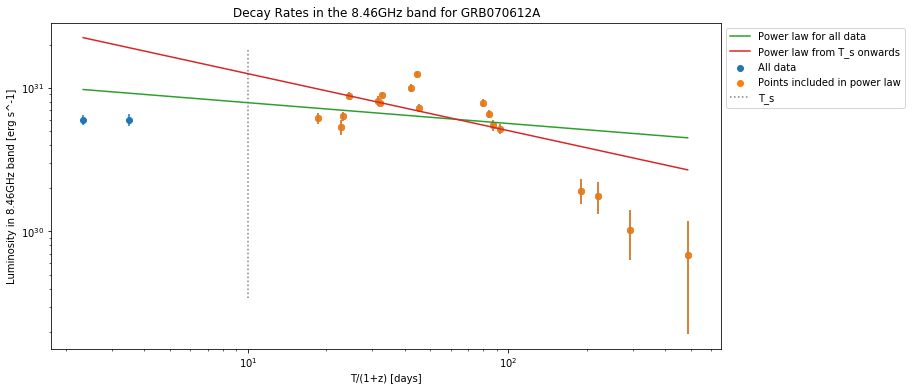

The decay index of GRB090902B is -0.584.


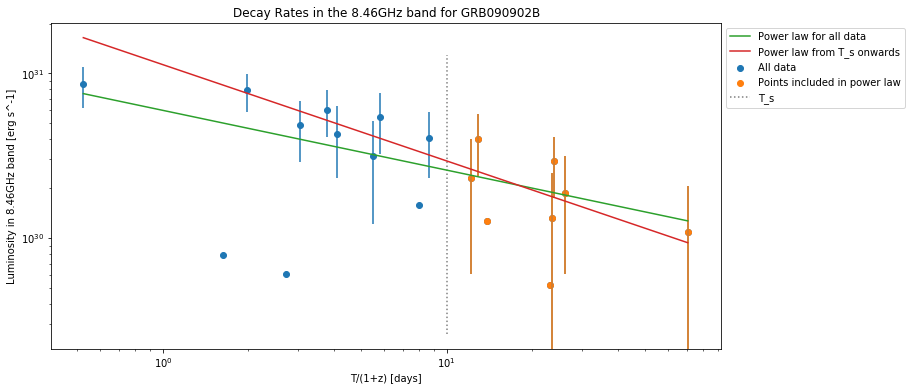

The decay index of GRB091020 is -0.642.


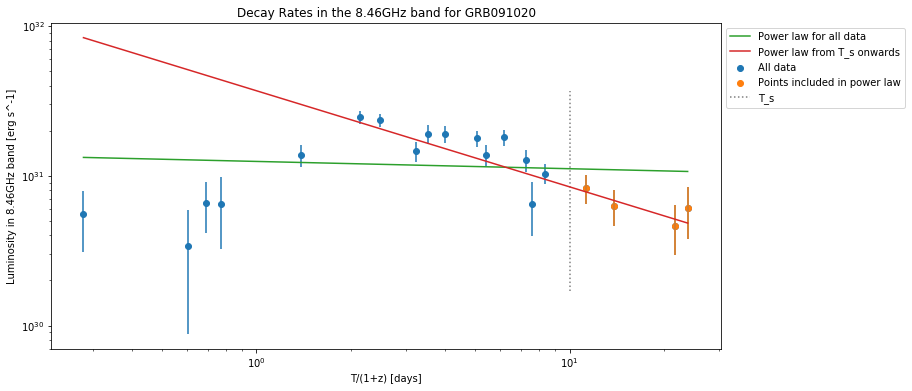

The decay index of GRB100414A is -1.858.


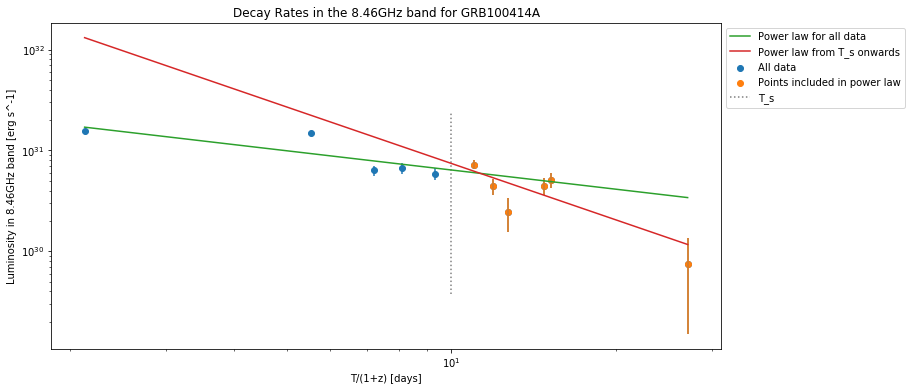

In [110]:
"""
DECAY INDEX CALCULATION
"""

decay_constant_data = []
decay_constant = []
a_error = []
decay_lines = []

for burst in data_cut:
    name = burst[0]
    lum = burst[1]
    lum_err = burst[2]
    time_rest = burst[3]

    # calculating best fit parameters and covariances for all the data

    # call on weight function to get the weights of the luminosity errorss
    weight_lum = weight(lum_err)

    # making power law model for linear fits
    model1 = PowerLawModel(prefix='pow_')

    # make parameters with starting values
    par1 = model1.make_params(pow_amplitude=1e31, pow_exponent=-0.5)

    # create results for these parameters using the weights
    result1 = model1.fit(lum, par1, x=time_rest, weights=weight_lum)

    # get a and N from the results
    a1_all = result1.best_values['pow_exponent']
    N1_all = result1.best_values['pow_amplitude']

    # call on power law function to create line with these parameters
    decay_line_all = power_law1(time_rest, N1_all, a1_all)

    # calculate best fit parameters for data beyond T_s

    # empty array to store the differences between the time values and T_s
    diff = []

    # skip ones with only data before T_s
    if time_rest[-1]<T_s:
        continue

    # if data before and after T_s, then find index of point after T_s
    if time_rest[0]<T_s:

        l_b = T_s

        for T in time_rest:
            if T<l_b:
                l_b_idx = 1+ time_rest.index(T)

        time_new = time_rest[l_b_idx:]
        lum_new = lum[l_b_idx:]
        lum_err_new = lum_err[l_b_idx:]

    # if data doesn't extend beyond T_s
    if time_rest[0]>T_s:

        time_new = time_rest
        lum_new = lum
        lum_err_new = lum_err



    # call on weight function to get the weights of the luminosity errorss
    weight_lum_new = weight(lum_err_new)

    # making power law model for linear fits
    model1 = PowerLawModel(prefix='pow_')

    # make parameters with starting values
    par1 = model1.make_params(pow_amplitude=1e31, pow_exponent=-0.5)

    # create results for these parameters using the weights
    result1 = model1.fit(lum_new, par1, x=time_new, weights=weight_lum_new)

    # get a and N from the results
    a1 = result1.best_values['pow_exponent']
    N1 = result1.best_values['pow_amplitude']

    # call on power law function to create line with these parameters
    decay_line = power_law1(time_rest, N1, a1)
    #decay_line_plot_all = power_law1(time_new, N1, a1)
    
    # store decay lines to plot later
    decay_lines.append([name, time_rest, decay_line])
    #decay_lines.append([name, time_new, decay_line_plot_all])
 
    # get error on decay rate
    ci = lmfit.conf_interval(result1, result1, sigmas=[0.68])

    normcon = []

    for key, value in ci.items():
        normcon.append(value)

    # extract errors on a and N
    errors = []
    for thing in normcon:
        for stuff in thing:
            errors.append(stuff[1])
    
    upper_a = (-errors[3]) - (-a1)
    lower_a = (-a1) - (-errors[5])
    
    alpha_err_avg = (upper_a + lower_a)/2

    ymin_T_s = min(lum) - 0.5*min(lum)
    ymax_T_s = max(lum) + 0.5*max(lum)
    
    print(f'The decay index of GRB{name} is {round(a1, 3)}.')
    
    # plot scatter graph of the individual luminosity curves
    plt.figure(figsize = (12, 6))
    plt.title(f'Decay Rates in the 8.46GHz band for GRB{name}')
    plt.xscale("log")
    plt.xlabel("T/(1+z) [days]")
    plt.yscale("log")
    plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
    plt.scatter(time_rest, lum, label='All data')
    plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
    plt.scatter(time_new, lum_new, label = 'Points included in power law')
    plt.errorbar(time_new, lum_new, yerr = lum_err_new, fmt = ' ')
    # plot the decay line for all data
    plt.plot(time_rest, decay_line_all, label='Power law for all data')
    # plot the decay line for data beyond T_s
    plt.plot(time_rest, decay_line, label='Power law from T_s onwards')
    # plot a line showing T
    plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='T_s')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()
    
    # only stores the decay constants if there are points beyond T_s
    decay_constant_data.append([name, a1, alpha_err_avg])
    decay_constant.append(a1)
    a_error.append([name, errors[3], errors[5]])


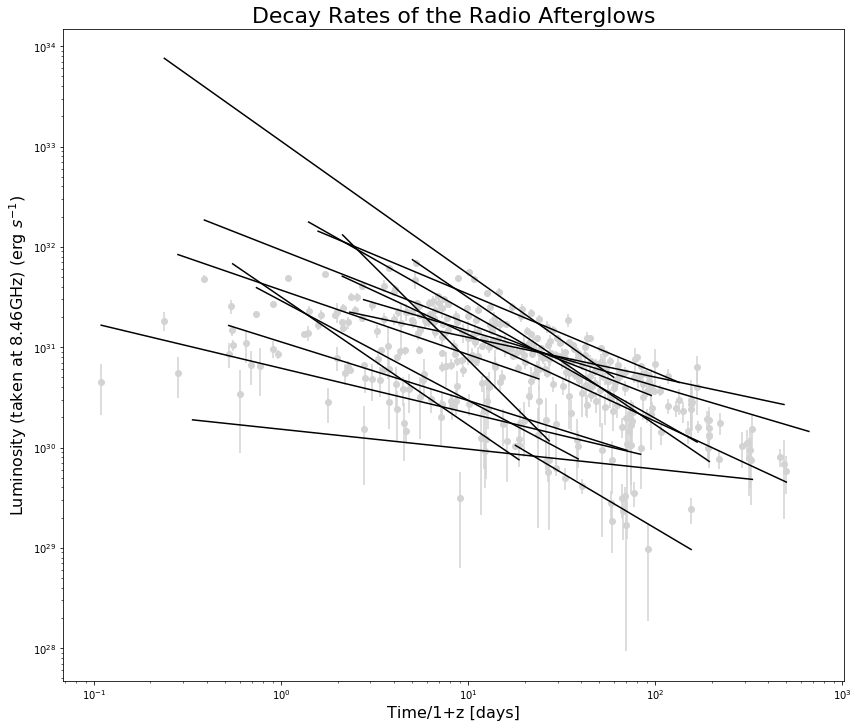

In [111]:
"""
PLOT OF ALL DECAY LINES OVER DATA
"""

# plot scatter graph of only measured fluxes of GRBs
fig = plt.figure(figsize = (14,12))
plt.title('Decay Rates of the Radio Afterglows', fontsize=22)
plt.xscale("log")
plt.xlabel("Time/1+z [days]", fontsize=16)
plt.yscale("log")
plt.ylabel("Luminosity (taken at 8.46GHz) (erg $s^{-1}$)", fontsize=16)        
for gammarayburst in data_dot:
    name = gammarayburst[0]
    lum = gammarayburst[1]
    lum_err = gammarayburst[2]
    time = gammarayburst[3]
    
    if name in GRB_plot:

        plt.scatter(time, lum, c = "lightgray")
        plt.errorbar(time, lum, lum_err, fmt = ' ', c = "lightgray")
        
for line in decay_lines:
    name = line[0]
    time = line[1]
    decay = line[2]
    
    if name in GRB_plot:
    
        plt.plot(time, decay, c = "black")

#plt.vlines(x=T_s, ymin=1e28, ymax=1e34, colors='red', linestyles=':', label='$T_s$')    
plt.legend(prop={'size': 14})
fig.savefig('all_decay.png', bbox_inches='tight', dpi=300)
plt.show()

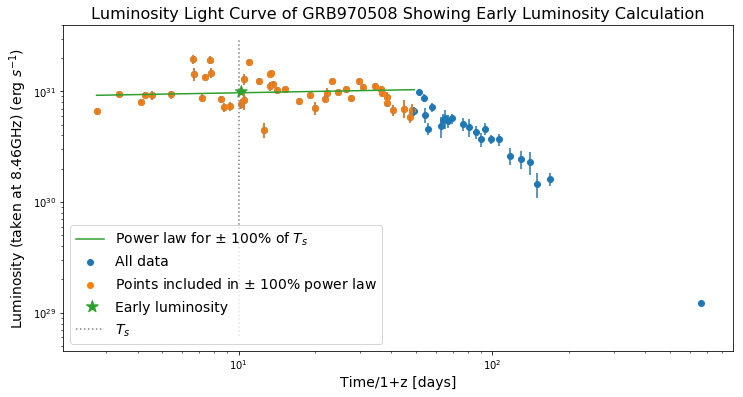

The early-time luminosity of GRB970508 is 9.708002405104191e+30erg s^-1.


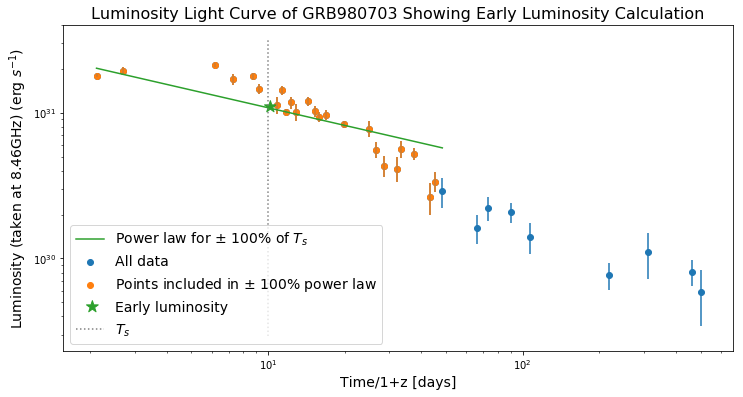

The early-time luminosity of GRB980703 is 1.084206712474684e+31erg s^-1.


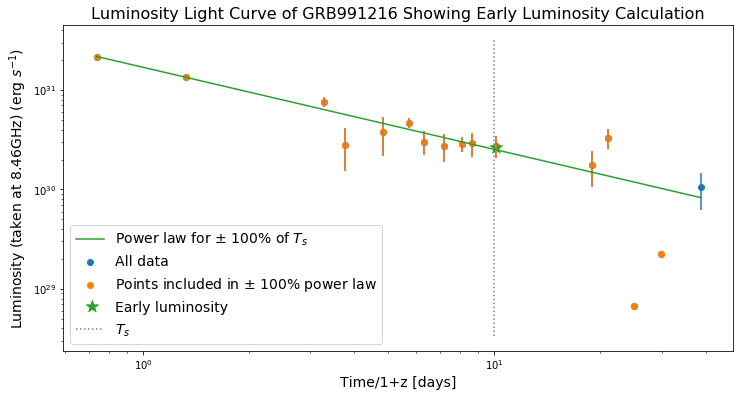

The early-time luminosity of GRB991216 is 2.5304162713109512e+30erg s^-1.


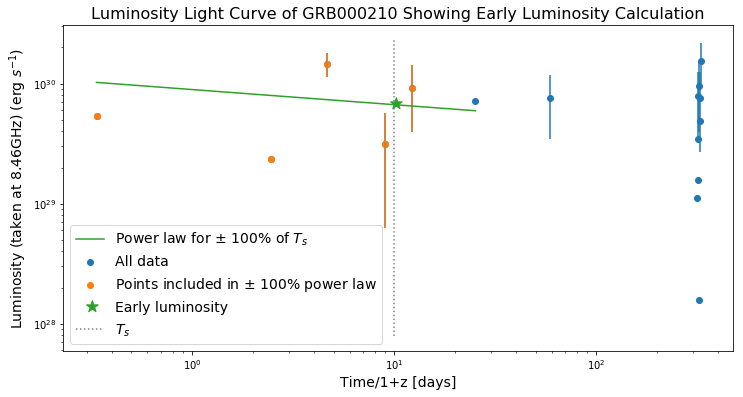

The early-time luminosity of GRB000210 is 6.670759493292768e+29erg s^-1.


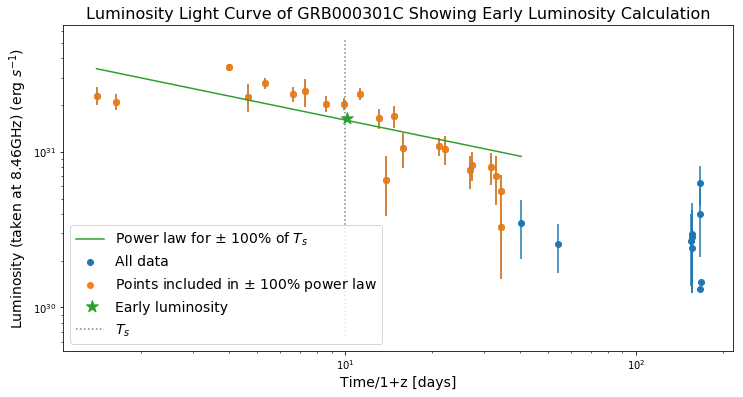

The early-time luminosity of GRB000301C is 1.603506890390254e+31erg s^-1.


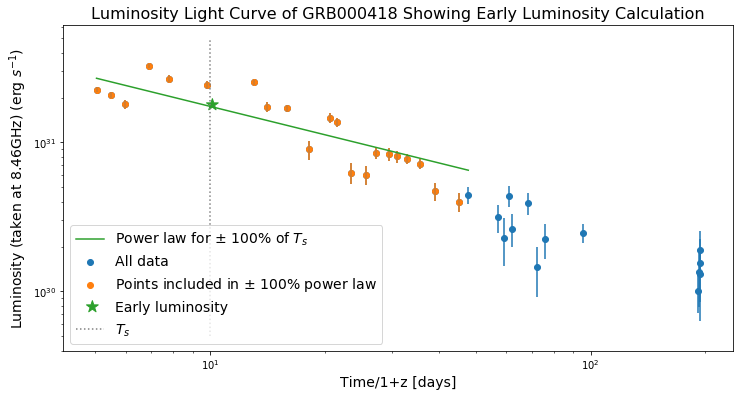

The early-time luminosity of GRB000418 is 1.7479336551604978e+31erg s^-1.


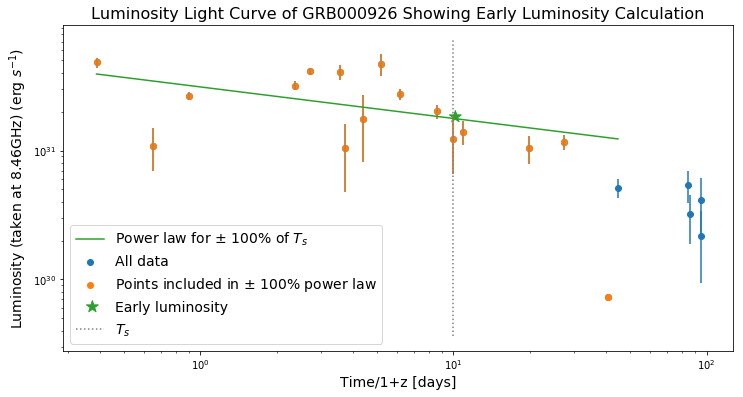

The early-time luminosity of GRB000926 is 1.7746737321180288e+31erg s^-1.


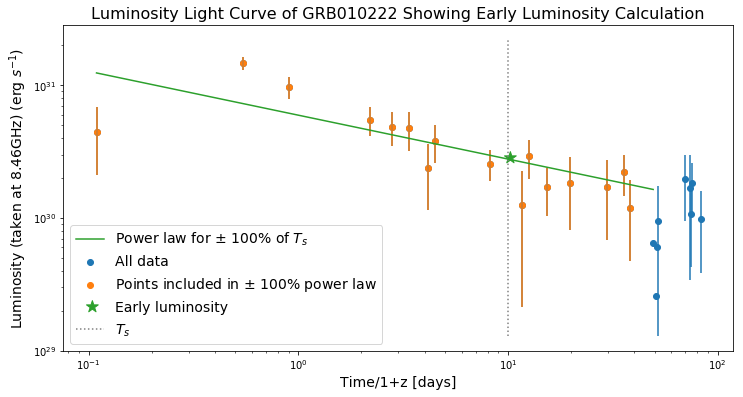

The early-time luminosity of GRB010222 is 2.780812980169928e+30erg s^-1.


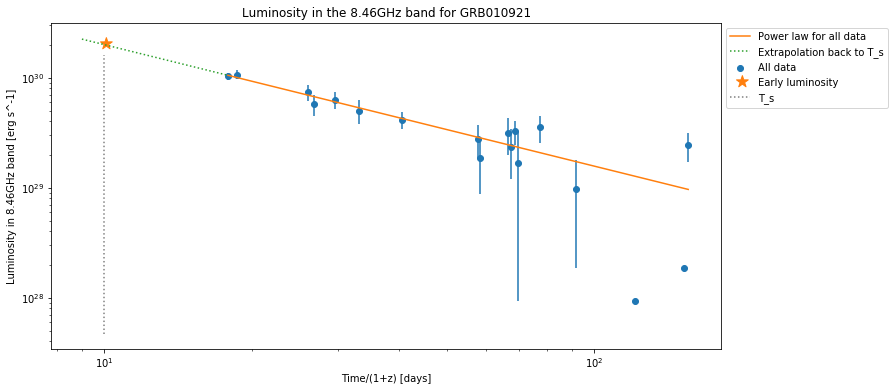

The early-time luminosity of GRB010921 is 1.9967164585522385e+30erg s^-1.


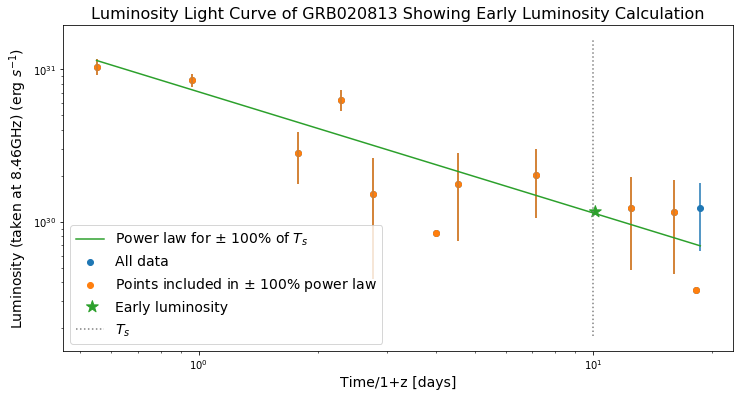

The early-time luminosity of GRB020813 is 1.1407720468959452e+30erg s^-1.


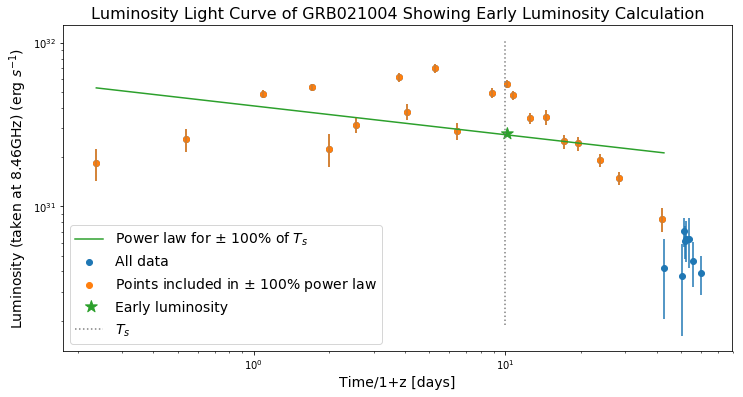

The early-time luminosity of GRB021004 is 2.7400570278130626e+31erg s^-1.


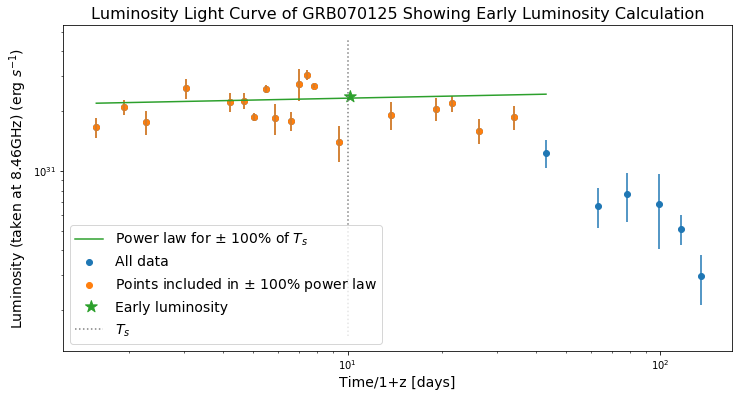

The early-time luminosity of GRB070125 is 2.329902904088596e+31erg s^-1.


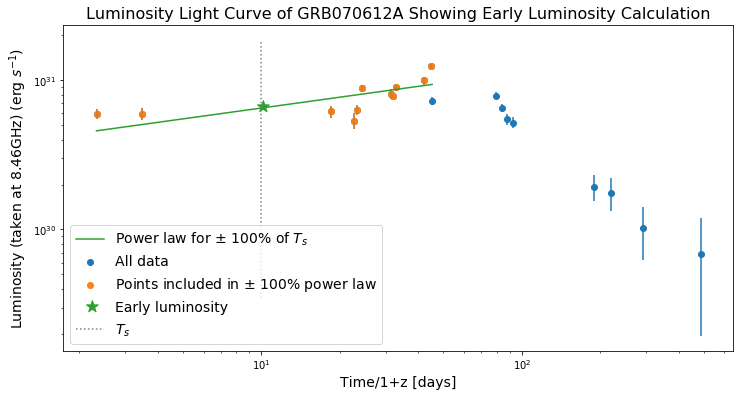

The early-time luminosity of GRB070612A is 6.512746422152468e+30erg s^-1.


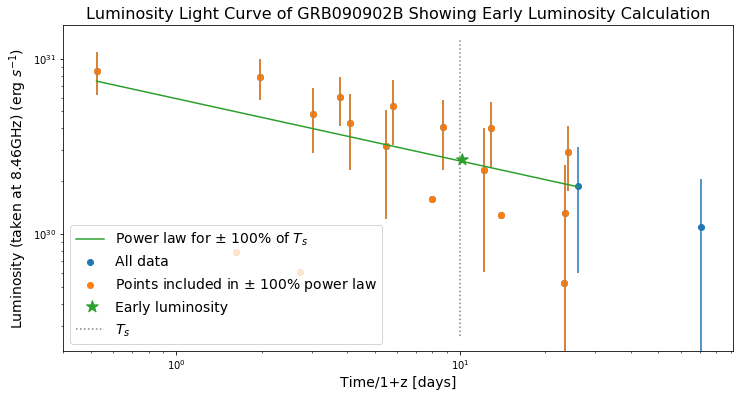

The early-time luminosity of GRB090902B is 2.611767426195715e+30erg s^-1.


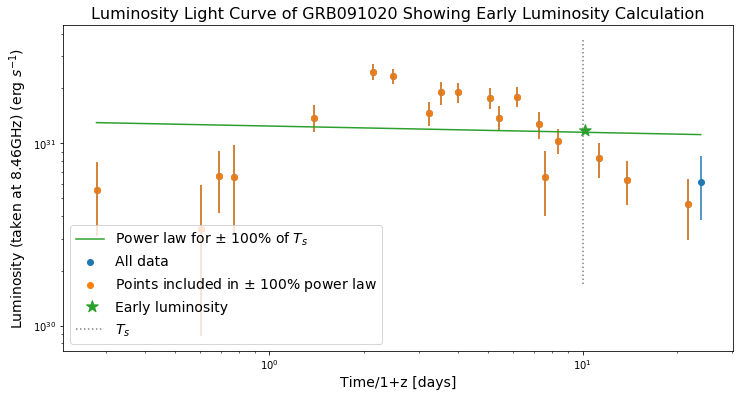

The early-time luminosity of GRB091020 is 1.1495258750169915e+31erg s^-1.


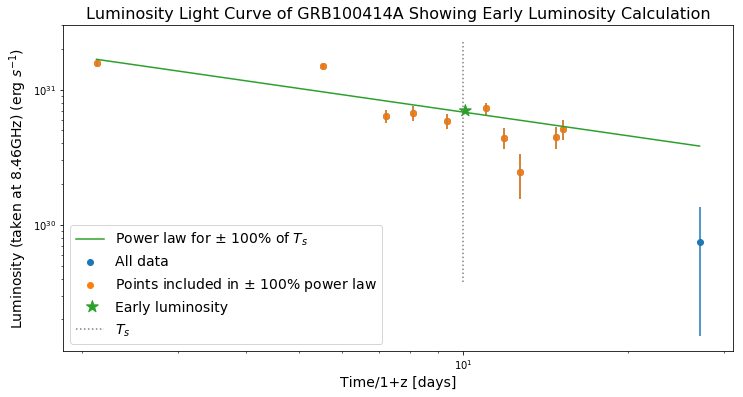

The early-time luminosity of GRB100414A is 6.815654646203621e+30erg s^-1.


In [115]:
"""
FINDING THE EARLY LUMINOSITY
"""

early_lums_data_2 = []
early_lums_data_100p = []
N_error_2 = []
N_error_100p = []

for burst in data_cut:
    name = burst[0]
    lum = burst[1]
    lum_err = burst[2]
    time_rest = burst[3]
    
    ymin_T_s = min(lum) - 0.5*min(lum)
    ymax_T_s = max(lum) + 0.5*max(lum)
    
    # if there are only points beyond T_s, then extrapolate power law back
    if time_rest[0]>T_s:

        # call on weight function to get the weights of the luminosity errorss
        weight_lum = weight(lum_err)

        # making power law model for linear fits
        model1 = PowerLawModel(prefix='pow_')

        # make parameters with starting values
        par1 = model1.make_params(pow_amplitude=1e30, pow_exponent=-0.5)

        # create results for these parameters using the weights
        result1 = model1.fit(lum, par1, x=time_rest, weights=weight_lum)

        # get a and N from the results
        a1 = result1.best_values['pow_exponent']
        N1 = result1.best_values['pow_amplitude']

        # call on power law function to create line with these parameters
        decay_line = power_law1(time_rest, N1, a1)

        # create power law that extrapolates back to T_s
        time_extrap = np.linspace(T_s - 1, time_rest[0], num = 1000)
        decay_line_extrap = power_law1(time_extrap, N1, a1)
        
        # get error on early luminosity
        ci = lmfit.conf_interval(result1, result1, sigmas=[0.68])

        normcon = []

        for key, value in ci.items():
            normcon.append(value)

        # extract error on N
        errors = []
        for thing in normcon:
            for stuff in thing:
                errors.append(stuff[1])
        
        N_err_upper_100p = errors[2]
        N_100p = errors[1]
        N_err_lower_100p = errors[0]
        
        N_err_lower = N_100p - N_err_lower_100p
        N_err_upper = N_err_upper_100p - N_100p
        
        early_L_err = (N_err_upper + N_err_lower)/2

        # Finding the luminosity at T_s
        diff = []
        for T in time_extrap:
            diff.append(abs(T-T_s))

        idx_T_s = np.argmin(diff)
        early_lum = decay_line_extrap[idx_T_s]
        early_lum_round = round(early_lum, 3)
        
        #early_L_err = N_err_avg*early_lum
        
        # plot scatter graph of the individual luminosity curves
        plt.figure(figsize = (12, 6))
        plt.title(f'Luminosity in the 8.46GHz band for GRB{name}')
        plt.xscale("log")
        plt.xlabel("Time/(1+z) [days]")
        plt.yscale("log")
        plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
        plt.scatter(time_rest, lum, label='All data')
        plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
        # plot the decay line for data beyond T_s
        plt.plot(time_rest, decay_line, label='Power law for all data')
        # plot extrapolated line to get early luminosity from
        plt.plot(time_extrap, decay_line_extrap, linestyle=':', label='Extrapolation back to T_s')
        # plot the early luminosity point
        plt.scatter(T_s, early_lum, marker=r'$\star$', s=250, label = 'Early luminosity')
        # plot a line showing T
        plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='T_s')
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.show()
        
        print(f'The early-time luminosity of GRB{name} is {early_lum}erg s^-1.')

        # add luminositites to an array, with type 'E' for extrapolated
        #early_lums_data_2.append([name, early_lum, 'E', N_err_upper, N_err_lower])
        early_lums_data_100p.append([name, early_lum, 'E', early_L_err])

    # if there are points before and after T_s, then find the luminosity at T_s
    if time_rest[0]<T_s:

        # fitting power law to the two points arond T_s
        for T in time_rest:
            if T<T_s:
                l_b_idx = time_rest.index(T)

        u_b_idx = l_b_idx + 2

        time_2 = time_rest[l_b_idx:u_b_idx]
        lum_2 = lum[l_b_idx:u_b_idx]
        lum_err_2 = lum_err[l_b_idx:u_b_idx]


        # fitting power law to T_s + 100% T_s
        u_b_100p = 5*T_s

        for T in time_rest:
            if T<u_b_100p:
                u_b_idx_100p = time_rest.index(T)

        l_b_idx_100p = 0

        time_100p = time_rest[l_b_idx_100p:u_b_idx_100p]
        lum_100p = lum[l_b_idx_100p:u_b_idx_100p]
        lum_err_100p = lum_err[l_b_idx_100p:u_b_idx_100p]

        # calculating best fit parameters and covariances for the data lmfit

        # making power law model for linear fits
        model = PowerLawModel(prefix='pow_')

        # make parameters with starting values
        par = model.make_params(pow_amplitude=1e31, pow_exponent=-0.3)

        # call on weight function to get the weights of the luminosity errorss
        weight_lum_2 = weight(lum_err_2)
        weight_lum_100p = weight(lum_err_100p)

        # create results for these parameters using the weights
        result_2 = model.fit(lum_2, par, x=time_2, weights=weight_lum_2)
        result_100p = model.fit(lum_100p, par, x=time_100p, weights=weight_lum_100p)

        # get a and N from the results
        a_2 = result_2.best_values['pow_exponent']
        N_2 = result_2.best_values['pow_amplitude']

        a_100p = result_100p.best_values['pow_exponent']
        N_100p = result_100p.best_values['pow_amplitude']

        time_plot_2 = np.linspace(time_rest[l_b_idx], time_rest[l_b_idx+1], num=1000)
        time_plot_100p = np.linspace(time_rest[l_b_idx_100p], time_rest[u_b_idx_100p], num=1000)

        # call on power law function to create line with these parameters
        decay_line_2 = power_law1(time_plot_2, N_2, a_2)
        decay_line_100p = power_law1(time_plot_100p, N_100p, a_100p)
        
        # get error on early luminosity
        #ci_2 = lmfit.conf_interval(result_2, result_2, sigmas=[0.68])
        ci_100p = lmfit.conf_interval(result_100p, result_100p, sigmas=[0.68])

        #normcon_2 = []
        normcon_100p = []

        #for key, value in ci_2.items():
            #normcon_2.append(value)
        for key, value in ci_100p.items():
            normcon_100p.append(value)

        # extract error on N
        #errors_2 = []
        #for thing in normcon_2:
            #for stuff in thing:
                #errors_2.append(stuff[1])
                
        errors_100p = []
        for thing in normcon_100p:
            for stuff in thing:
                errors_100p.append(stuff[1])
        
        #N_err_upper_2 = errors[5]
        #N_err_lower_2 = errors[3]
        N_err_upper_100p = errors_100p[2]
        N_100p = errors_100p[1]
        N_err_lower_100p = errors_100p[0]
        
        #print(N_err_upper_100p)
        #print(N_100p)
        #print(N_err_lower_100p)
        
        N_err_lower = N_100p - N_err_lower_100p
        N_err_upper = N_err_upper_100p - N_100p
        
        L_err_avg = (N_err_lower + N_err_upper)/2
        
        #print(name)
        #print(N_err_lower)
        #print(N_err_upper)
        #print(L_err_avg)
        
        #N_err_avg = (N_err - N_100p)/N_100p
        
        # Finding the luminosity at T_s for 100p
        diff_100p = []
        for T in time_plot_100p:
            diff_100p.append(abs(T-T_s))

        idx_T_s_100p = np.argmin(diff_100p)
        early_lum_100p = decay_line_100p[idx_T_s_100p]
        
        #L_err_avg = early_lum_100p*N_err_avg

        # plot scatter graph of the individual luminosity curves
        plt.figure(figsize = (12, 6))
        plt.title(f"Luminosity Light Curve of GRB{name} Showing Early Luminosity Calculation", fontsize=16)
        plt.xscale("log")
        plt.xlabel("Time/1+z [days]", fontsize=14)
        plt.yscale("log")
        plt.ylabel("Luminosity (taken at 8.46GHz) (erg $s^{-1}$)", fontsize=14)
        plt.scatter(time_rest, lum, label='All data')
        plt.errorbar(time_rest, lum, yerr = lum_err, fmt = ' ')
        # colour in points used in the fits
        #plt.scatter(time_2, lum_2, label = 'Points included in two point power law')
        #plt.errorbar(time_2, lum_2, yerr = lum_err_2, fmt = ' ')
        plt.scatter(time_100p, lum_100p, label = 'Points included in $\pm$ 100% power law')
        plt.errorbar(time_100p, lum_100p, yerr = lum_err_100p, fmt = ' ')
        # plot the early luminosity point
        #plt.scatter(T_s, early_lum_2, marker=r'$\star$', s=200, label = 'Early luminosity (two points)')
        plt.scatter(T_s, early_lum_100p, marker=r'$\star$', s=250, label = 'Early luminosity')
        # plot the decay line between the two points around T_s
        #plt.plot(time_plot_2, decay_line_2, label='Power law for two points either side of T_s')
        plt.plot(time_plot_100p, decay_line_100p, label='Power law for $\pm$ 100% of $T_s$')
        # plot a line showing T_s
        plt.vlines(x=T_s, ymin=ymin_T_s, ymax=ymax_T_s, colors='grey', linestyle=':', label='$T_s$')
        plt.legend(loc="lower left", prop={'size': 14})
        plt.show()

        print(f'The early-time luminosity of GRB{name} is {early_lum_100p}erg s^-1.')

        # add luminositites to an array, with type 'R' for regular method
        #early_lums_data_2.append([name, early_lum_2, 'R', N_err_upper_2, N_err_lower_2])
        early_lums_data_100p.append([name, early_lum_100p, 'R', L_err_avg])


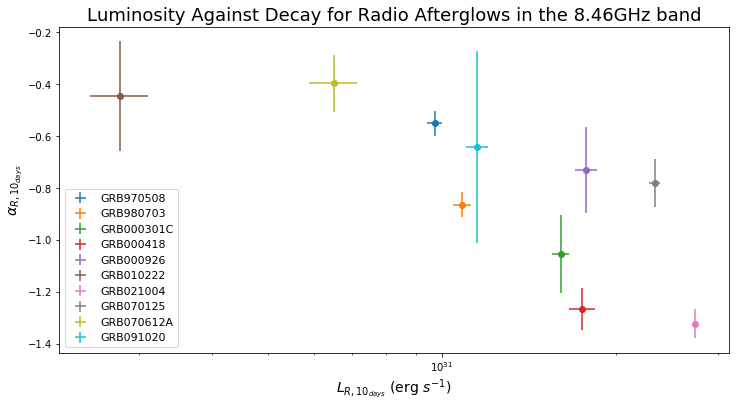

The preliminary Spearman Rank value is -0.77.
The p value is 0.009.


In [124]:
"""
CORRELATION BETWEEN ALPHA AND LUM
"""

# empty list for storing the data for all GRBs
x_all = []
y_all = []
x_err_all = []
y_err_all = []
name_final_all = []

# empty list for storing the data for GRBs not found via extrapolation
x_R = []
y_R = []
x_err_R = []
y_err_R = []
name_final_R = []

# empty lists for storing the data after applying the conditions
two_sig = []
final_data = []
name_final = []

# cycle through the GRBs to match the early luminosity to decay rate
for row in early_lums_data_100p:
    
    GRB = row[0]
    
    for line in decay_constant_data:
        
        # match names in decay list and luminosity list
        if GRB == line[0]:
            
            method = row[2]
            N_err = row[3]
            
            # alpha and early lum with errors
            early_L = row[1]
            alpha = line[1]
            alpha_err_avg = np.abs(line[2])
            #L_err = N_err
            L_err = N_err*((T_s)**alpha)
            
            # add to array to plot (all)
            x_all.append(early_L)
            y_all.append(alpha)
            x_err_all.append(L_err)
            y_err_all.append(alpha_err_avg)
            name_final_all.append([GRB, alpha, alpha_err_avg, early_L, L_err])
            
            # alpha and early lum for GRBs not using extrapolation
            if method == 'R':
                
                # add to new array to be plot (only regular)
                y_R.append(alpha)
                x_R.append(early_L)
                y_err_R.append(alpha_err_avg)
                x_err_R.append(L_err)
                name_final_R.append(GRB)
                
                # applying conditions for plot
                if alpha_err_avg <= 0.5:
                    
                    # finding which points have an error on L less than two times the valaue itself
                    two_sig_ind = 2*L_err
                    diff = early_L - two_sig_ind
                    two_sig.append(diff)
                    
                    if diff > 0:
                        
                        # storing data for the plot
                        final_data.append([GRB, early_L, alpha, L_err, alpha_err_avg])
                        name_final.append(GRB)


x_R = np.asarray(x_R, dtype=float)
y_R = np.asarray(y_R, dtype=float)
x_err_R = np.asarray(x_err_R, dtype=float)
y_err_R = np.asarray(y_err_R, dtype=float)
two_sig = np.asarray(two_sig, dtype=float)

condition_err_a=(y_err_R <= 0.5)

x_1 = x_R[condition_err_a]
y_1 = y_R[condition_err_a]
y_err_1 = y_err_R[condition_err_a]
x_err_1 = x_err_R[condition_err_a]

condition_err_L = (two_sig > 0)

x = x_1[condition_err_L]
y = y_1[condition_err_L]
y_err = y_err_1[condition_err_L]
x_err = x_err_1[condition_err_L]

"""
# plot scatter graph of early luminosity against decay
plt.figure(figsize = (12, 6))
plt.title(f'Luminosity Against Decay for Radio Afterglows')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
plt.scatter(x_all, y_all, c = "black")
plt.errorbar(x_all, y_all, yerr = y_err_all, xerr = x_err_all, fmt = ' ', c = "black")
plt.show()
plt.show()

rho_all, p_all = spearmanr(x_all, y_all)

print(f'Spearman Rank Value is {rho_all}')
print(f'p value is {p_all}')

# plot scatter graph of early luminosity against decay found via regular method only
plt.figure(figsize = (12, 6))
plt.title(f'Luminosity Against Decay for Radio Afterglows (only via regular method)')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
plt.scatter(x_R, y_R, c = "black")
plt.errorbar(x_R, y_R, yerr = y_err_R, xerr = x_err_R, fmt = ' ', c = "black")
plt.show()

rho_R, p_R = spearmanr(x_R, y_R)

print(f'Spearman Rank Value is {rho_R}')
print(f'p value is {p_R}')
"""
"""
# plot scatter graph of early luminosity against decay
plt.figure(figsize = (12, 6))
plt.title(f'Luminosity Against Decay for Radio Afterglows')
plt.xlabel("Decay Index")
plt.yscale("log")
plt.ylabel("Luminosity in 8.46GHz band [erg s^-1]")
plt.scatter(x, y, c = "black")
plt.errorbar(x, y, yerr = y_err, xerr = x_err, fmt = ' ', c = "black")
plt.show()
"""

# plot scatter graph of early luminosity against decay
fig = plt.figure(figsize = (12, 6))
plt.title(f'Luminosity Against Decay for Radio Afterglows in the 8.46GHz band', fontsize=18)
plt.ylabel("$\u03B1_{R, 10_{days}}$", fontsize=14)
plt.xscale("log")
plt.xlabel("$L_{R, 10_{days}}$ (erg $s^{-1}$)", fontsize=14)
for data in final_data:
    name = data[0]
    L = data[1]
    A = data[2]
    L_err = data[3]
    A_err = data[4]
    
    plt.scatter(L, A)
    plt.errorbar(L, A, yerr = A_err, xerr = L_err, fmt = ' ', label = f'GRB{name}')
    
plt.legend(loc="lower left", prop={'size': 11})
fig.savefig('correlation.png', bbox_inches='tight', dpi=300)
plt.show()

rho_cond_a, p_cond_a = spearmanr(np.log10(x), y)

print(f'The preliminary Spearman Rank value is {round(rho_cond_a, 3)}.')
print(f'The p value is {round(p_cond_a, 3)}.')


Analysis finished.


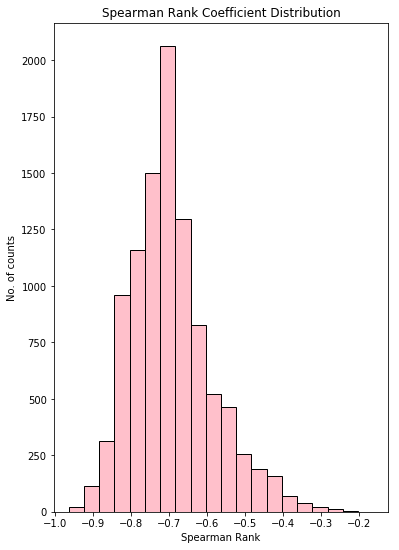

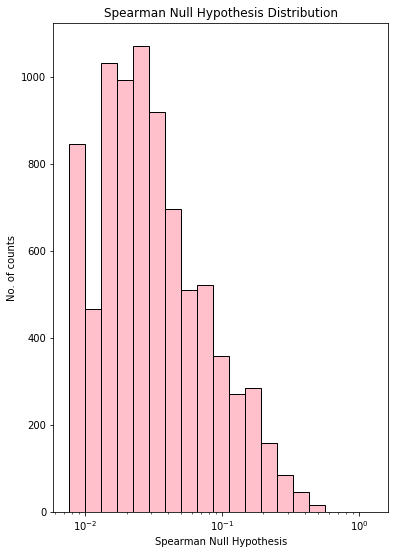

The spearman's rank coefficient is -0.693 +/- 0.097


In [127]:
"""
MCMC SAMPLING FOR ERROR ON SPEARMAN'S RANK (METHOD ONE)
"""

# number of times to sample from the data
trials = 10000

# empty arrays to hold the spearman rank and p-values for each sample
ts_src_data, ts_srp_data = [], []

# run through each trial
for i in range(trials):
    
    # empty array for alpha and L for each run
    ts_A, ts_L = [], []
    
    # sample from each data point
    for j in range(len(x)):
        
        # use value as mean and error as sigma for alpha and L for each GRB
        
        ts_a_mean = y[j]
        ts_a_std = y_err[j]
        ts_l_mean = x[j]
        ts_l_std = x_err[j]

        # draw random alpha and L from normal distribution made with these values
        ts_a = np.random.normal(loc=ts_a_mean, scale=abs(ts_a_std))
        ts_l = np.random.normal(loc=ts_l_mean, scale=abs(ts_l_std))
        
        # add to array
        ts_A.append(ts_a)
        ts_L.append(np.log10(abs(ts_l)))
    
    # run spearman's rank for each randomly sampled point
    ts_src_data.append(spearmanr(ts_A, ts_L)[0])
    ts_srp_data.append(spearmanr(ts_A, ts_L)[1])    
    
print('Analysis finished.')

# plot histogram of spearman's rank coefficients
plt.figure(figsize=(6,9))
plt.title('Spearman Rank Coefficient Distribution')
plt.hist(ts_src_data, bins = 20, color='pink', edgecolor='black')
plt.xlabel("Spearman Rank")
plt.ylabel("No. of counts")
plt.show()

"""
# plot histogram of null hypotheses
plt.figure(figsize=(6,9))
plt.title('Spearman Null Hypothesis Distribution')
plt.hist(ts_srp_data, bins= 20, color='pink', edgecolor='black')
plt.xlabel("Spearman Null Hypothesis")
plt.ylabel("No. of counts")
plt.show()
"""

logbins = np.logspace(np.log10(ts_srp_data[0]), 0.1, 20)

# plot histogram of null hypotheses (log scale)
plt.figure(figsize=(6,9))
plt.title('Spearman Null Hypothesis Distribution')
plt.hist(ts_srp_data, bins=logbins, color='pink', edgecolor='black')
plt.xlabel("Spearman Null Hypothesis")
plt.xscale("log")
plt.ylabel("No. of counts")
plt.show()


ts_src_data.sort()

bottom_src = np.percentile(ts_src_data, 15.9)
top_src = np.percentile(ts_src_data, 84.1)
mean_src = np.average(ts_src_data)

top_error_src = np.abs(top_src - mean_src)
bottom_error_src = np.abs(mean_src - bottom_src)

error_src = (top_error_src + bottom_error_src)/2

print(f"The spearman's rank coefficient is {round(mean_src, 3)} +/- {round(error_src, 3)}")

Analysis Done.


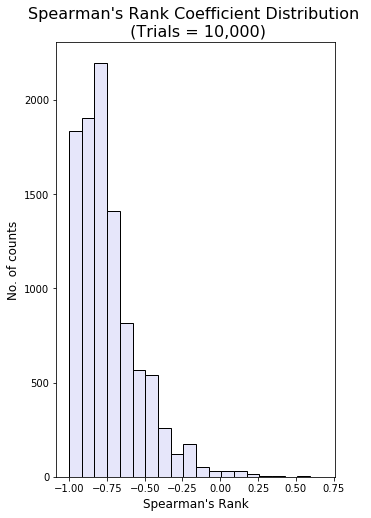

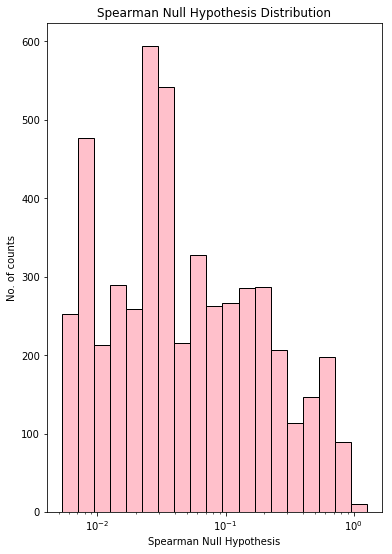

The spearman's rank coefficient is -0.741 +/- 0.184


In [128]:
"""
MCMC SAMPLING FOR ERROR ON SPEARMAN'S RANK (METHOD TWO)
"""

top_rand = len(x) - 1

# number of times to sample from the data
trials = 10000

# empty arrays to hold the spearman rank and p-values for each sample
ts_src_data, ts_srp_data = [], []

# run through each trial
for i in range(trials):
    
    # empty array for alpha and L for each run
    ts_A, ts_L = [], []

    for j in range(len(x)):
        
        rand = random.randint(0,top_rand)
        
        ts_a = y[rand]
        ts_l = x[rand]
        
        # add to array
        ts_A.append(ts_a)
        ts_L.append(np.log10(ts_l))
        
    # run spearman's rank for each randomly sampled point
    ts_src_data.append(spearmanr(ts_A, ts_L)[0])
    ts_srp_data.append(spearmanr(ts_A, ts_L)[1])

print("Analysis Done.")

# plot histogram of spearman's rank coefficients
fig = plt.figure(figsize=(5,8))
plt.title("Spearman's Rank Coefficient Distribution \n (Trials = 10,000)", fontsize=16)
plt.hist(ts_src_data, bins = 20, color='lavender', edgecolor='black')
plt.xlabel("Spearman's Rank", fontsize=12)
plt.ylabel("No. of counts", fontsize=12)
fig.savefig('SR_error.png', bbox_inches='tight', dpi=400)
plt.show()

logbins = np.logspace(np.log10(ts_srp_data[0]), 0.1, 20)

# plot histogram of null hypotheses (log scale)
plt.figure(figsize=(6,9))
plt.title('Spearman Null Hypothesis Distribution')
plt.hist(ts_srp_data, bins=logbins, color='pink', edgecolor='black')
plt.xlabel("Spearman Null Hypothesis")
plt.xscale("log")
plt.ylabel("No. of counts")
plt.show()

ts_src_data.sort()

bottom_src = np.percentile(ts_src_data, 15.9)
top_src = np.percentile(ts_src_data, 84.1)
mean_src = np.average(ts_src_data)

top_error_src = np.abs(mean_src - top_src)
bottom_error_src = np.abs(bottom_src - mean_src)

error_src = (top_error_src + bottom_error_src)/2

print(f"The spearman's rank coefficient is {round(mean_src, 3)} +/- {round(error_src, 3)}")

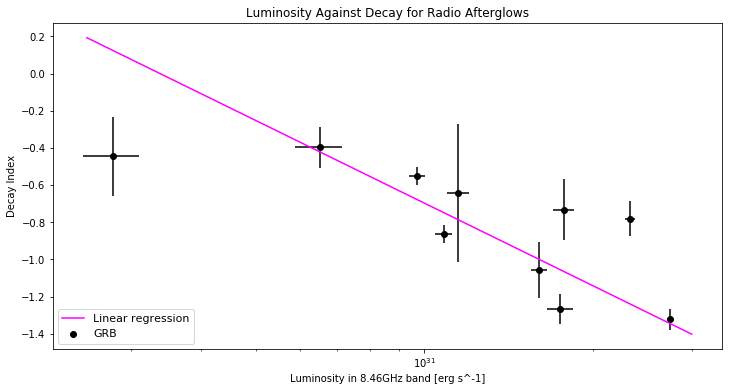

The preliminary linear regression is $α$ = -1.478*log(L) + 45.121


In [132]:
"""
LINEAR REGRESSION
"""

# gets the weights on the data using the errors
mydata = RealData(x=np.log10(x),y=y , sy=y_err, sx=np.log10(x_err))

# defines linear function to use in fit
def f(B, q):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*q + B[1]

# runs linear model using the weights from the data
linear = odr.Model(f)
myodr = odr.ODR(mydata, linear, beta0=[-1, -1])

# gets output from the fit
myoutput = myodr.run()

m = round(myoutput.beta[0], 3)
c = round(myoutput.beta[1], 3)

x_test = np.linspace(2.5e30, 3e31, num = 100)
y_test = m*np.log10(x_test) + c

# plot scatter graph of early luminosity against decay
fig = plt.figure(figsize = (12, 6))
plt.title(f'Luminosity Against Decay for Radio Afterglows')
plt.ylabel("Decay Index")
plt.xscale("log")
plt.xlabel("Luminosity in 8.46GHz band [erg s^-1]")
plt.scatter(x, y, c = "black", label="GRB")
plt.errorbar(x, y, yerr = y_err, xerr = x_err, fmt = ' ', c = "black")
plt.plot(x_test, y_test, c='magenta', linestyle='-', label='Linear regression')
fig.savefig('correlation_regression.png', bbox_inches='tight', dpi=150)
plt.legend(loc="lower left", prop={'size': 11})
plt.show()

print(f'The preliminary linear regression is $\u03B1$ = {m}*log(L) + {c}')

In [133]:
"""
MCMC SAMPLING FOR ERROR ON LINEAR REGRESSION
"""

top_rand = len(x) - 1

# defines linear function to use in fit
def f(B, q):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*q + B[1]

linear = odr.Model(f)

# number of times to sample from the data
trials = 10000

# empty arrays to hold the spearman rank and p-values for each sample
lr_m_data, lr_c_data = [], []

# run through each trial
for i in range(trials):
    
    # empty array for alpha and L for each run
    lr_A, lr_L, lr_A_err, lr_L_err = [], [], [], []

    for j in range(len(x)):
        
        rand = random.randint(0,top_rand)
        
        lr_a = y[rand]
        lr_l = x[rand]
        lr_a_err = y_err[rand]
        lr_l_err = x_err[rand]
        
        # add to array
        lr_A.append(lr_a)
        lr_L.append(lr_l)
        lr_A_err.append(lr_a_err)
        lr_L_err.append(lr_l_err)
    
    # gets the weights on the data using the errors
    mydata = RealData(x=np.log10(lr_L),y=lr_A , sy=lr_A_err, sx=np.log10(lr_L_err))

    # runs linear model using the weights from the data
    myodr = odr.ODR(mydata, linear, beta0=[-1, 30])

    # gets output from the fit
    myoutput = myodr.run()
    #myoutput.pprint()
    
    lr_m_data.append(myoutput.beta[0])
    lr_c_data.append(myoutput.beta[1])       

print('Analysis Done.')

Analysis Done.


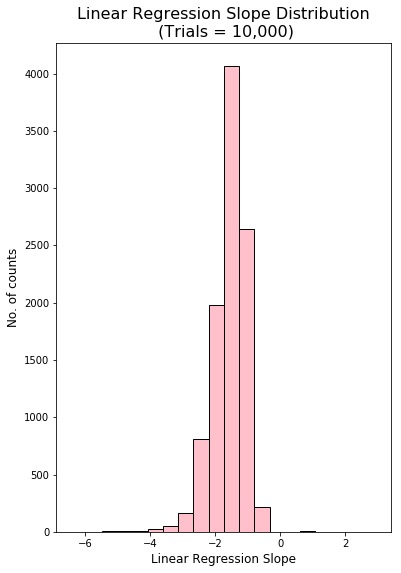

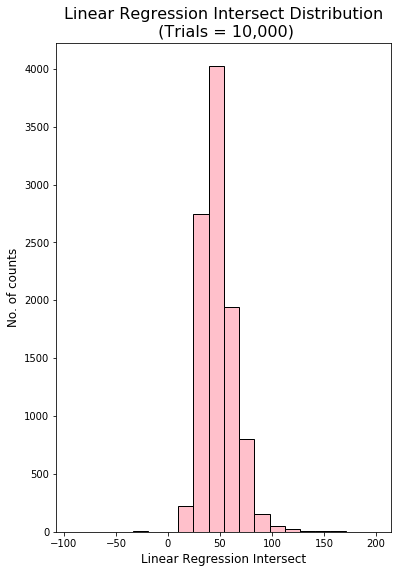

The linear regression slope is -1.571 +/- 0.459
The linear regression intersect is 48.058 +/- 14.316


In [134]:
"""
PLOTS FROM MCMC SAMPLING ON LINEAR REGRESSION
"""

# plot histogram of linear regression slope distribution
fig = plt.figure(figsize=(6,9))
plt.title("Linear Regression Slope Distribution\n (Trials = 10,000)", fontsize=16)
plt.hist(lr_m_data, bins = 20, color='pink', edgecolor='black')
plt.xlabel("Linear Regression Slope", fontsize=12)
plt.ylabel("No. of counts", fontsize=12)
fig.savefig('LR_m_dist.png', bbox_inches='tight', dpi=400)
plt.show()

# plot histogram of linear regression intersect distribution
fig = plt.figure(figsize=(6,9))
plt.title("Linear Regression Intersect Distribution\n (Trials = 10,000)", fontsize=16)
plt.hist(lr_c_data, bins = 20, color='pink', edgecolor='black')
plt.xlabel("Linear Regression Intersect", fontsize=12)
plt.ylabel("No. of counts", fontsize=12)
fig.savefig('LR_c_dist.png', bbox_inches='tight', dpi=400)
plt.show()


# finding the error and mean of the slope
lr_m_data.sort()

bottom_m = np.percentile(lr_m_data, 15.9)
top_m = np.percentile(lr_m_data, 84.1)
mean_m = np.average(lr_m_data)

top_error_m = np.abs(top_m - mean_m)
bottom_error_m = np.abs(mean_m - bottom_m)

error_m = (top_error_m + bottom_error_m)/2

print(f"The linear regression slope is {round(mean_m, 3)} +/- {round(error_m, 3)}")


# finding the error and mean of the slope
lr_c_data.sort()

bottom_c = np.percentile(lr_c_data, 15.9)
top_c = np.percentile(lr_c_data, 84.1)
mean_c = np.average(lr_c_data)

mean_c_10 = np.power(10, mean_c)

top_error_c = np.abs(top_c - mean_c)
bottom_error_c = np.abs(mean_c - bottom_c)

error_c = (top_error_c + bottom_error_c)/2

print(f"The linear regression intersect is {round(mean_c, 3)} +/- {round(error_c, 3)}")

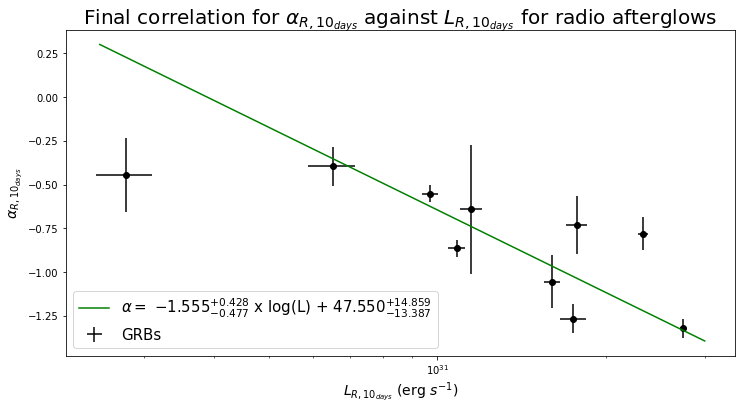

In [135]:
"""
LINEAR REGRESSION PLOT WITH ERROR
"""

# linspace of alpha values to plot line with
x_test_lr = np.linspace(2.5e30, 3e31, num = 100)

# y's using the mean values
y_test_lr = mean_m*np.log10(x_test) + mean_c

# plot scatter graph of early luminosity against decay
fig = plt.figure(figsize = (12, 6))
plt.title("Final correlation for $\u03B1_{R, 10_{days}}$ against $L_{R, 10_{days}}$ for radio afterglows", fontsize=20)
plt.ylabel("$\u03B1_{R, 10_{days}}$", fontsize=14)
plt.xscale("log")
plt.xlabel("$L_{R, 10_{days}}$ (erg $s^{-1}$)", fontsize=14)
plt.scatter(x, y, c = "black")
plt.errorbar(x, y, yerr = y_err, xerr = x_err, fmt = ' ', c = "black", label = "GRBs")
plt.plot(x_test_lr, y_test_lr, c='green', linestyle='-', label="$\u03B1 =$ $-1.555_{-0.477}^{+0.428}$ x log(L) + $47.550_{-13.387}^{+14.859}$", )
#plt.plot(x_test, y_upper_lr, c='green', linestyle=':', label='Linear regression upper limit', )
#plt.plot(x_test, y_lower_lr, c='green', linestyle=':', label='Linear lower limit', )
plt.legend(loc="lower left", prop={'size': 15})
fig.savefig('correlation_final.png', bbox_inches='tight', dpi=150)
plt.show()
